In [1]:
#author: Anonymous

#Imports

import torch
import torch.nn as nn
import torch.nn.functional as nnf
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms.functional as ttf
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

import os
import time

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import random
import itertools
import json as js
import pandas as pd
from scipy import stats

import DatasetFunctions as df

from collections import Counter
from tqdm import tqdm

import pydicom
import SimpleITK as sitk

#device = torch.device("cpu")
device = torch.device("cuda")# if torch.cuda.is_available() else "cpu")

In [2]:
def representation(SEFN):
    """
    Make a ResNet-usable (224x224x3) representation of an arbitrary input image. There is no center-cropping,
    because we might lose valuable parts of the image (like the Abdomen in a CTTA).
    This function is called by MOMO during evaluation.
    """
    # Resample image to correct size
    sitkreader = sitk.ImageSeriesReader()
    sitkreader.SetFileNames(SEFN)
    sitk_image = sitkreader.Execute()
    representation = df.make_representation_from_unknown(current_image = sitk_image, target_size=(224, 224, 224))
    
    # Add a batch dimension
    representation = torch.unsqueeze(torch.Tensor(representation), 0)
    
    # Squeeze to [0,1]
    representation -= representation.min()
    representation /= representation.max()
    
    # Example normalization to ImageNet-mean/std
    ct = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    transformed_representation = ct(representation)
    
    return transformed_representation

In [3]:
class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    PyTorch adaptation by Geoff Pleiss.
    """
    def __init__(self, n_bins=10):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, targets):
        softmaxes = nnf.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(targets)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
    
def ECE_bin_plot(logits, targets, n_bins, title):
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_centers = (bin_uppers-bin_lowers)/2 + bin_lowers
    
    softmaxes = nnf.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(targets)
    
    bin_accs = []
    bin_cons = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        accuracy_in_bin = accuracies[in_bin].float().mean()
        avg_confidence_in_bin = confidences[in_bin].mean()
        bin_accs.append(accuracy_in_bin.item())
        bin_cons.append(avg_confidence_in_bin.item())
    
    plt.figure()
    plt.title(title)
    plt.xlabel('Confidence')
    plt.ylabel('Avg accuracy in bin')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.bar(bin_centers, bin_accs, width=1/n_bins, color='b', edgecolor='k', alpha=0.5, label="Accuracy")
    plt.bar(bin_centers, bin_cons, width=1/n_bins, color='r', edgecolor='k', alpha=0.5, label="Confidence")
    plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), 'k--', linewidth=2.0, label='Optimal behaviour')
    plt.legend(loc='upper left')
    plt.show()

class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda() 
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for data, label, dindex in valid_loader:
                data = data.cuda()
                logits = self.model(data)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        #before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_nll = nnf.nll_loss(nnf.log_softmax(logits, dim=1), labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))
        
        ECE_bin_plot(logits, labels, n_bins=10, title="Uncalibrated network accuracies")

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def evaluate():
            #loss = nll_criterion(self.temperature_scale(logits), labels)
            loss = ece_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(evaluate)

        # Calculate NLL and ECE after temperature scaling
        #after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_nll = nnf.nll_loss(nnf.log_softmax(logits, dim=1), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))
        
        ECE_bin_plot(self.temperature_scale(logits), labels, n_bins=10, title="T-Calibrated network accuracies")

        return self
    
def plot_item(dataloader, idx, classified_as=None, mapping=None):
    data, target, dindex = dataset.__getitem__(idx)
    fig = plt.figure(figsize=(16, 6))
    if classified_as:
        if mapping:
            fig.suptitle("Image "+str(idx)+" (class "+str(target)+"/"+str(mapping["Internal"]["Code"][str(target)])+"), classified as "+str(classified_as)+"/"+str(mapping["Internal"]["Code"][str(classified_as)]), fontsize = 30)
        else:
            fig.suptitle("Image "+str(idx)+" (class "+str(target)+"), classified as "+str(classified_as), fontsize = 30)
    else:
        if mapping:
            fig.text(x=0.25, y=0.9, s="Image "+str(idx)+" (class "+str(target)+"/"+str(mapping["Internal"]["Code"][str(target)])+")", fontsize = 30)
        else:
            fig.text(x=0.25, y=0.9, s="Image "+str(idx)+" (class "+str(target)+")", fontsize = 30)
    for z in range(3):
        ax = fig.add_subplot(1,3,z+1)
        ax.set_title("Image "+str(idx)+" (with class "+str(target)+"), z="+str(z))
        ax.imshow(data[z,:,:].cpu().detach().numpy())

In [4]:
def train_model(model, current_epoch, train_loader, lr, lr_decay, weight_decay, verbose=True):
    
    model.to(device)
    model.train()

    # optimizer, scheduler, no temp
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lr_decay)
    
    bid = 0
    epoch_losses = 0
    
    for data, target, dindex in train_loader:
        
        # forward
        optimizer.zero_grad()
        output = model(data)
        
        nll_loss = nnf.nll_loss(nnf.log_softmax(output, dim=1), target.to(output.device))
        loss = nll_loss

        # backward
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        scheduler.step()
        
        bid += 1
        if verbose==True:
            print('Epoch:'+str(current_epoch)+', Batch ID:'+str(bid)+', Loss:'+str(loss.item()))
        epoch_losses += loss.item()
        
    return epoch_losses / (bid + 1)

def calibrate_model(model, temp_loader):
    
    scaled_model = ModelWithTemperature(model)
    scaled_model.eval()
    scaled_model.set_temperature(temp_loader)
    
    return scaled_model
    
def test_model(model,
               test_loader,
               nc,
               mapfile = './MCMapping.json',
               plot_cm = True,
               print_mistakes = False,
               plot_mistakes = False):
    
    model.eval()
    model.model.eval()
    
    test_loss = 0
    correct = 0
    print("n_classes: ", nc)
    all_predictions = []
    all_probabilities = []
    all_targets = []
    
    with torch.no_grad():
        cmt = torch.zeros(nc, nc, dtype = torch.int64)
        logits_list = []
        labels_list = []

        # load mapping
        with open(mapfile) as json_file:
            mapping = js.load(json_file)
            classes = list(mapping["Internal"]["Code"].values())[0:nc+1]
        
        for data, target, dindex in test_loader:
            # send to device
            #data, target = data.to(device), target.to(device)

            # generate output
            output = model(data)
            #print(output)
            
            # remember raw logits for ECE plot
            logits_list.append(output)
            labels_list.append(target)
            
            # compute loss, accuracy, gather mistakes
            lsm = nnf.log_softmax(output, dim=1).to(output.device) #/model.temperature
            softmax = nnf.softmax(output, dim=1).to(output.device) #/model.temperature
            test_loss += nnf.nll_loss(lsm, target.to(output.device), reduction='sum').item() # sum up batch loss
            pred = lsm.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            prob = softmax.data.max(1, keepdim=True)[0]
            for idx, p in enumerate(pred):
                # populate confusion matrix. grab predictions, targets, probabilities
                t = target.to(output.device).data.view_as(pred)[idx].item()
                d = dindex.to(output.device).data.view_as(pred)[idx].item()
                cmt[p.item(),t] += 1
                all_predictions.append(p.item())
                all_targets.append(t)
                b = prob.data.view_as(pred)[idx].item()
                all_probabilities.append(b)
                # if set to print all mistakes, do
                if p != t:
                    if print_mistakes == True:
                        print("Classified "+str(classes[t])+" as "+str(classes[p.item()]))
                        try:
                            print("Had "+str(trhist[0][t])+" "+str(classes[t])+", "+str(trhist[0][p.item()])+" "+str(classes[p.item()])+" training examples.")
                        except:
                            print("Had "+str(trhist[0][t])+" "+str(classes[t])+", 0 "+str(classes[p.item()])+" training examples.")
                    if plot_mistakes == True:
                        plot_item(dataloader = test_loader, idx = d, classified_as = p.item(), mapping = mapping)
            correct += pred.eq(target.to(output.device).data.view_as(pred)).cuda().sum().item()
        
        # print accuracy
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        print('Loss:'+str(test_loss)+',Accuracy:'+str(accuracy)+'%')
        
        # plot ECE Bin plot
        logits = torch.cat(logits_list).cuda()
        labels = torch.cat(labels_list).cuda()
        ECE_bin_plot(logits, labels, n_bins=10, title="T-Calibrated network accuracies (test set)")

        # plot confusion matrix
        if plot_cm == True:

            cm = cmt.detach().numpy()

            plt.figure(figsize=(40,40)) 
            ax = plt.gca()
            img = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.plasma)
            plt.title("Confusion Matrix")
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation = 90)
            plt.yticks(tick_marks, classes)
            fmt = 'd'
            threshold = cm.max() * 0.33
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="b" if cm[i, j] > threshold else "w")
            plt.tight_layout()
            plt.xlabel('Target')
            plt.ylabel('Prediction')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.5)
            plt.colorbar(img, cax = cax)
        
        return all_predictions, all_probabilities, all_targets, accuracy

In [7]:

def get_indices(lower, upper, length):
    return [i for i in range(length) if i>=lower and i<upper]

# Make dataset

nc = 13 # n_classes
ct = transforms.Compose([transforms.Resize([int(224), int(224)]),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                         ])

dataset = df.LAZY_Dataset(data_root='/home/freddy/Projects/ModalityMapping/training/',
                          p_rotflip=0.2,
                          custom_transform=None)
#'/media/freddy/UNTITLED/DL200/'

dl = dataset.__len__()
vs = int(0.10*dl) # validation set size
ts = int(0.10*dl) # test set size
#vs = min(200, int(0.10*dl)) # validation set size
#ts = min(200, int(0.10*dl)) # test set size
#trainset, tempset, testset = torch.utils.data.random_split(dataset, [dataset.__len__()-vs-ts, vs, ts])
# Randomly shuffle the dataset
dataset = torch.utils.data.random_split(dataset, [dl])[0]


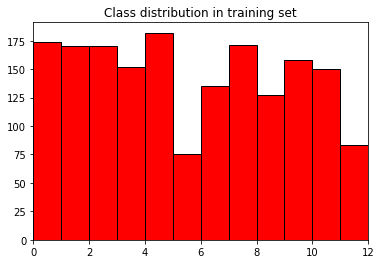

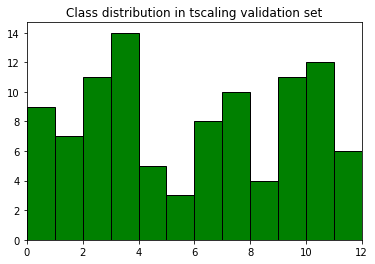

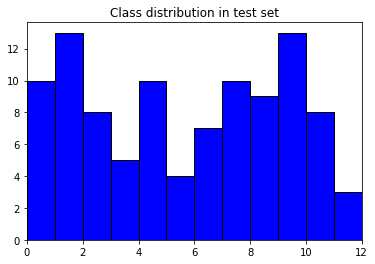

In [5]:

k = 0
temp_inds = get_indices(lower=int(0+k*(vs+ts)), upper=int(vs+k*(vs+ts)), length=dl)
test_inds = get_indices(lower=int(vs+k*(vs+ts)), upper=int((k+1)*(vs+ts)), length=dl)
train_inds = [i for i in range(dl) if not (i in temp_inds or i in test_inds)]

trainset = torch.utils.data.Subset(dataset, train_inds)
tempset = torch.utils.data.Subset(dataset, temp_inds)
testset = torch.utils.data.Subset(dataset, test_inds)

trdist = [targets for _, targets, _ in trainset]
tmdist = [targets for _, targets, _ in tempset]
tedist = [targets for _, targets, _ in testset]

plt.figure()
trhist = plt.hist(trdist, bins=np.arange(0,nc+1), color='r', edgecolor='k') # last bin is nans, it should be empty
plt.title("Class distribution in training set")
plt.xlim(0,nc)

plt.figure()
tmhist = plt.hist(tmdist, bins=np.arange(0,nc+1), color='g', edgecolor='k') # last bin is nans, it should be empty
plt.title("Class distribution in tscaling validation set")
plt.xlim(0,nc)

plt.figure()
tehist = plt.hist(tedist, bins=np.arange(0,nc+1), color='b', edgecolor='k') # last bin is nans, it should be empty
plt.title("Class distribution in test set")
plt.xlim(0,nc)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=24, num_workers=4, shuffle=True, drop_last=False)

tempset.training = False
temp_loader = torch.utils.data.DataLoader(tempset, batch_size=24, num_workers=4, shuffle=True)

testset.training = False
test_loader = torch.utils.data.DataLoader(testset, batch_size=24, shuffle=True)


In [ ]:

# import a resnet, freeze it, swap in final layer
RN_model = torch.nn.DataParallel(torchvision.models.resnet152(pretrained=True)).to(device)
for param in RN_model.parameters():
    param.requires_grad = False
for param in RN_model.module.layer4.parameters():
    param.requires_grad = True
for param in RN_model.module.avgpool.parameters():
    param.requires_grad = True
num_ftrs = RN_model.module.fc.in_features
RN_model.module.fc = nn.Linear(num_ftrs, nc)

# training hyperparameters
lr = 1e-4 # learning rate
lr_decay = lambda current_epoch: 0.99**current_epoch # learning rate decay function
w_decay = 1e-4 # weight decay

# conditions and schedules
esa = True # early stopping allowed
vis = 5   # how many epochs must plateau before break
imp = 0.99 # suggested loss improvement to continue training
def training_converged(lel, vis, imp):
    return sum(x for x in lel[-2*int(vis):-1*int(vis)])/vis * imp < sum(x for x in lel[-1*int(vis):])/vis

wda = 0.5  # at which fraction of average early loss should weight_decay becomes active

# train
lel = []
for epoch in range(1000):
    # weight decay active?
    if epoch != 0:
        if el <= wda * lel[0]:
            weight_decay = w_decay
        else:
            weight_decay = 0
    else:
        weight_decay = 0
        
    # train model
    el = train_model(model = RN_model,
                current_epoch = epoch,
                train_loader = train_loader,
                lr = lr,
                lr_decay = lr_decay,
                weight_decay = weight_decay)
        
    # track average loss during epoch                                                    
    lel.append(el)
    
    # end training due to convergence?
    if epoch > vis:
        print("Recent average training loss: "+str(sum(x for x in lel[-1*int(vis)-1:-1])/vis))
        print("Current average training loss: "+str(sum(x for x in lel[-1*int(vis):])/vis))
    if epoch >=2*vis:
        if training_converged(lel, vis = vis, imp = imp):
            if esa:
                print("Network parameters appear to have converged, aborting training.")
                # training has not improved loss to factor imp compared to avg of the last vis epochs, end training
                break
            else:
                print("Continuing training. Warning: Convergence satisfies user-specified conditions already.")
        else:
            print("Continuing training.")
            
plt.figure()
plt.title("Loss history during training")
plt.xlim(0,len(lel)-1)
plt.ylim(0,max(lel)*1.2)
plt.xlabel("Epoch")
plt.ylabel("Loss (NLL)")
x = np.linspace(0, len(lel), len(lel))
plt.plot(x, lel, color='k', linewidth=2)


Epoch:0, Batch ID:1, Loss:2.4794540405273438
Epoch:0, Batch ID:2, Loss:2.4767074584960938
Epoch:0, Batch ID:3, Loss:2.4696898460388184
Epoch:0, Batch ID:4, Loss:2.4002652168273926
Epoch:0, Batch ID:5, Loss:2.4386606216430664
Epoch:0, Batch ID:6, Loss:2.443575859069824
Epoch:0, Batch ID:7, Loss:2.468247652053833
Epoch:0, Batch ID:8, Loss:2.3743607997894287
Epoch:0, Batch ID:9, Loss:2.44970703125
Epoch:0, Batch ID:10, Loss:2.4648613929748535
Epoch:0, Batch ID:11, Loss:2.452871799468994
Epoch:0, Batch ID:12, Loss:2.426429271697998
Epoch:0, Batch ID:13, Loss:2.3864808082580566
Epoch:0, Batch ID:14, Loss:2.41526198387146
Epoch:1, Batch ID:1, Loss:2.337646007537842
Epoch:1, Batch ID:2, Loss:2.39962100982666
Epoch:1, Batch ID:3, Loss:2.3639678955078125
Epoch:1, Batch ID:4, Loss:2.3391306400299072
Epoch:1, Batch ID:5, Loss:2.355919122695923
Epoch:1, Batch ID:6, Loss:2.2900888919830322
Epoch:1, Batch ID:7, Loss:2.288339376449585
Epoch:1, Batch ID:8, Loss:2.3163516521453857
Epoch:1, Batch ID:9, 

Before temperature - NLL: 1.123, ECE: 0.158


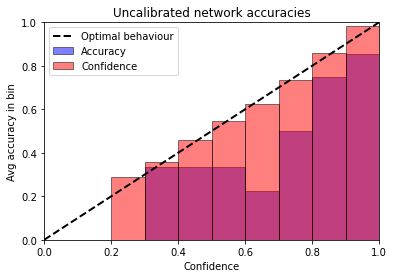

Optimal temperature: 1.967
After temperature - NLL: 1.123, ECE: 0.048


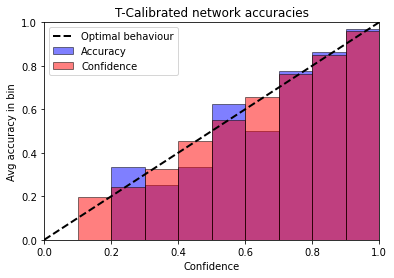

In [7]:
# calibrate temperature
RN_Tmodel = calibrate_model(model = RN_model, temp_loader = temp_loader)

Temperature: T= 1.9668835401535034
n_classes:  12
Classified CTB as CTGE
Had 156.0 CTB, 167.0 CTGE training examples.
Classified CTTA as CTAB
Had 124.0 CTTA, 180.0 CTAB training examples.
Classified CTT as CTGE
Had 172.0 CTT, 167.0 CTGE training examples.
Classified CTWS as CTUE
Had 150.0 CTWS, 165.0 CTUE training examples.
Classified CTSH as CTWS
Had 138.0 CTSH, 150.0 CTWS training examples.
Classified CTUE as CTB
Had 165.0 CTUE, 156.0 CTB training examples.
Classified CTOE as CTUE
Had 180.0 CTOE, 165.0 CTUE training examples.
Classified CTSH as CTGE
Had 138.0 CTSH, 167.0 CTGE training examples.
Classified CTOE as CTUE
Had 180.0 CTOE, 165.0 CTUE training examples.
Classified CTTA as CTWS
Had 124.0 CTTA, 150.0 CTWS training examples.
Classified CTTA as CTGE
Had 124.0 CTTA, 167.0 CTGE training examples.
Classified CTTA as CTWS
Had 124.0 CTTA, 150.0 CTWS training examples.
Classified CTTA as CTGE
Had 124.0 CTTA, 167.0 CTGE training examples.
Classified CTB as CTUE
Had 156.0 CTB, 165.0 CT

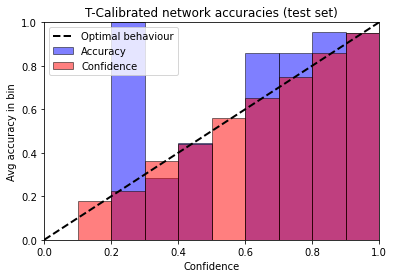

Predicted class 5 with p=0.8615477681159973, target was class 5
Predicted class 0 with p=0.44179782271385193, target was class 0
Predicted class 2 with p=0.37967151403427124, target was class 1
Predicted class 1 with p=0.9708632230758667, target was class 1
Predicted class 0 with p=0.4460294544696808, target was class 0
Predicted class 7 with p=0.8800112009048462, target was class 7
Predicted class 11 with p=0.8713219165802002, target was class 11
Predicted class 0 with p=0.9531176686286926, target was class 8
Predicted class 2 with p=0.4869648814201355, target was class 7
Predicted class 8 with p=0.23232296109199524, target was class 8
Predicted class 9 with p=0.3248435854911804, target was class 10
Predicted class 4 with p=0.912209689617157, target was class 4
Predicted class 1 with p=0.8435391783714294, target was class 1
Predicted class 10 with p=0.5636588931083679, target was class 6
Predicted class 4 with p=0.9876771569252014, target was class 4
Predicted class 3 with p=0.9668068

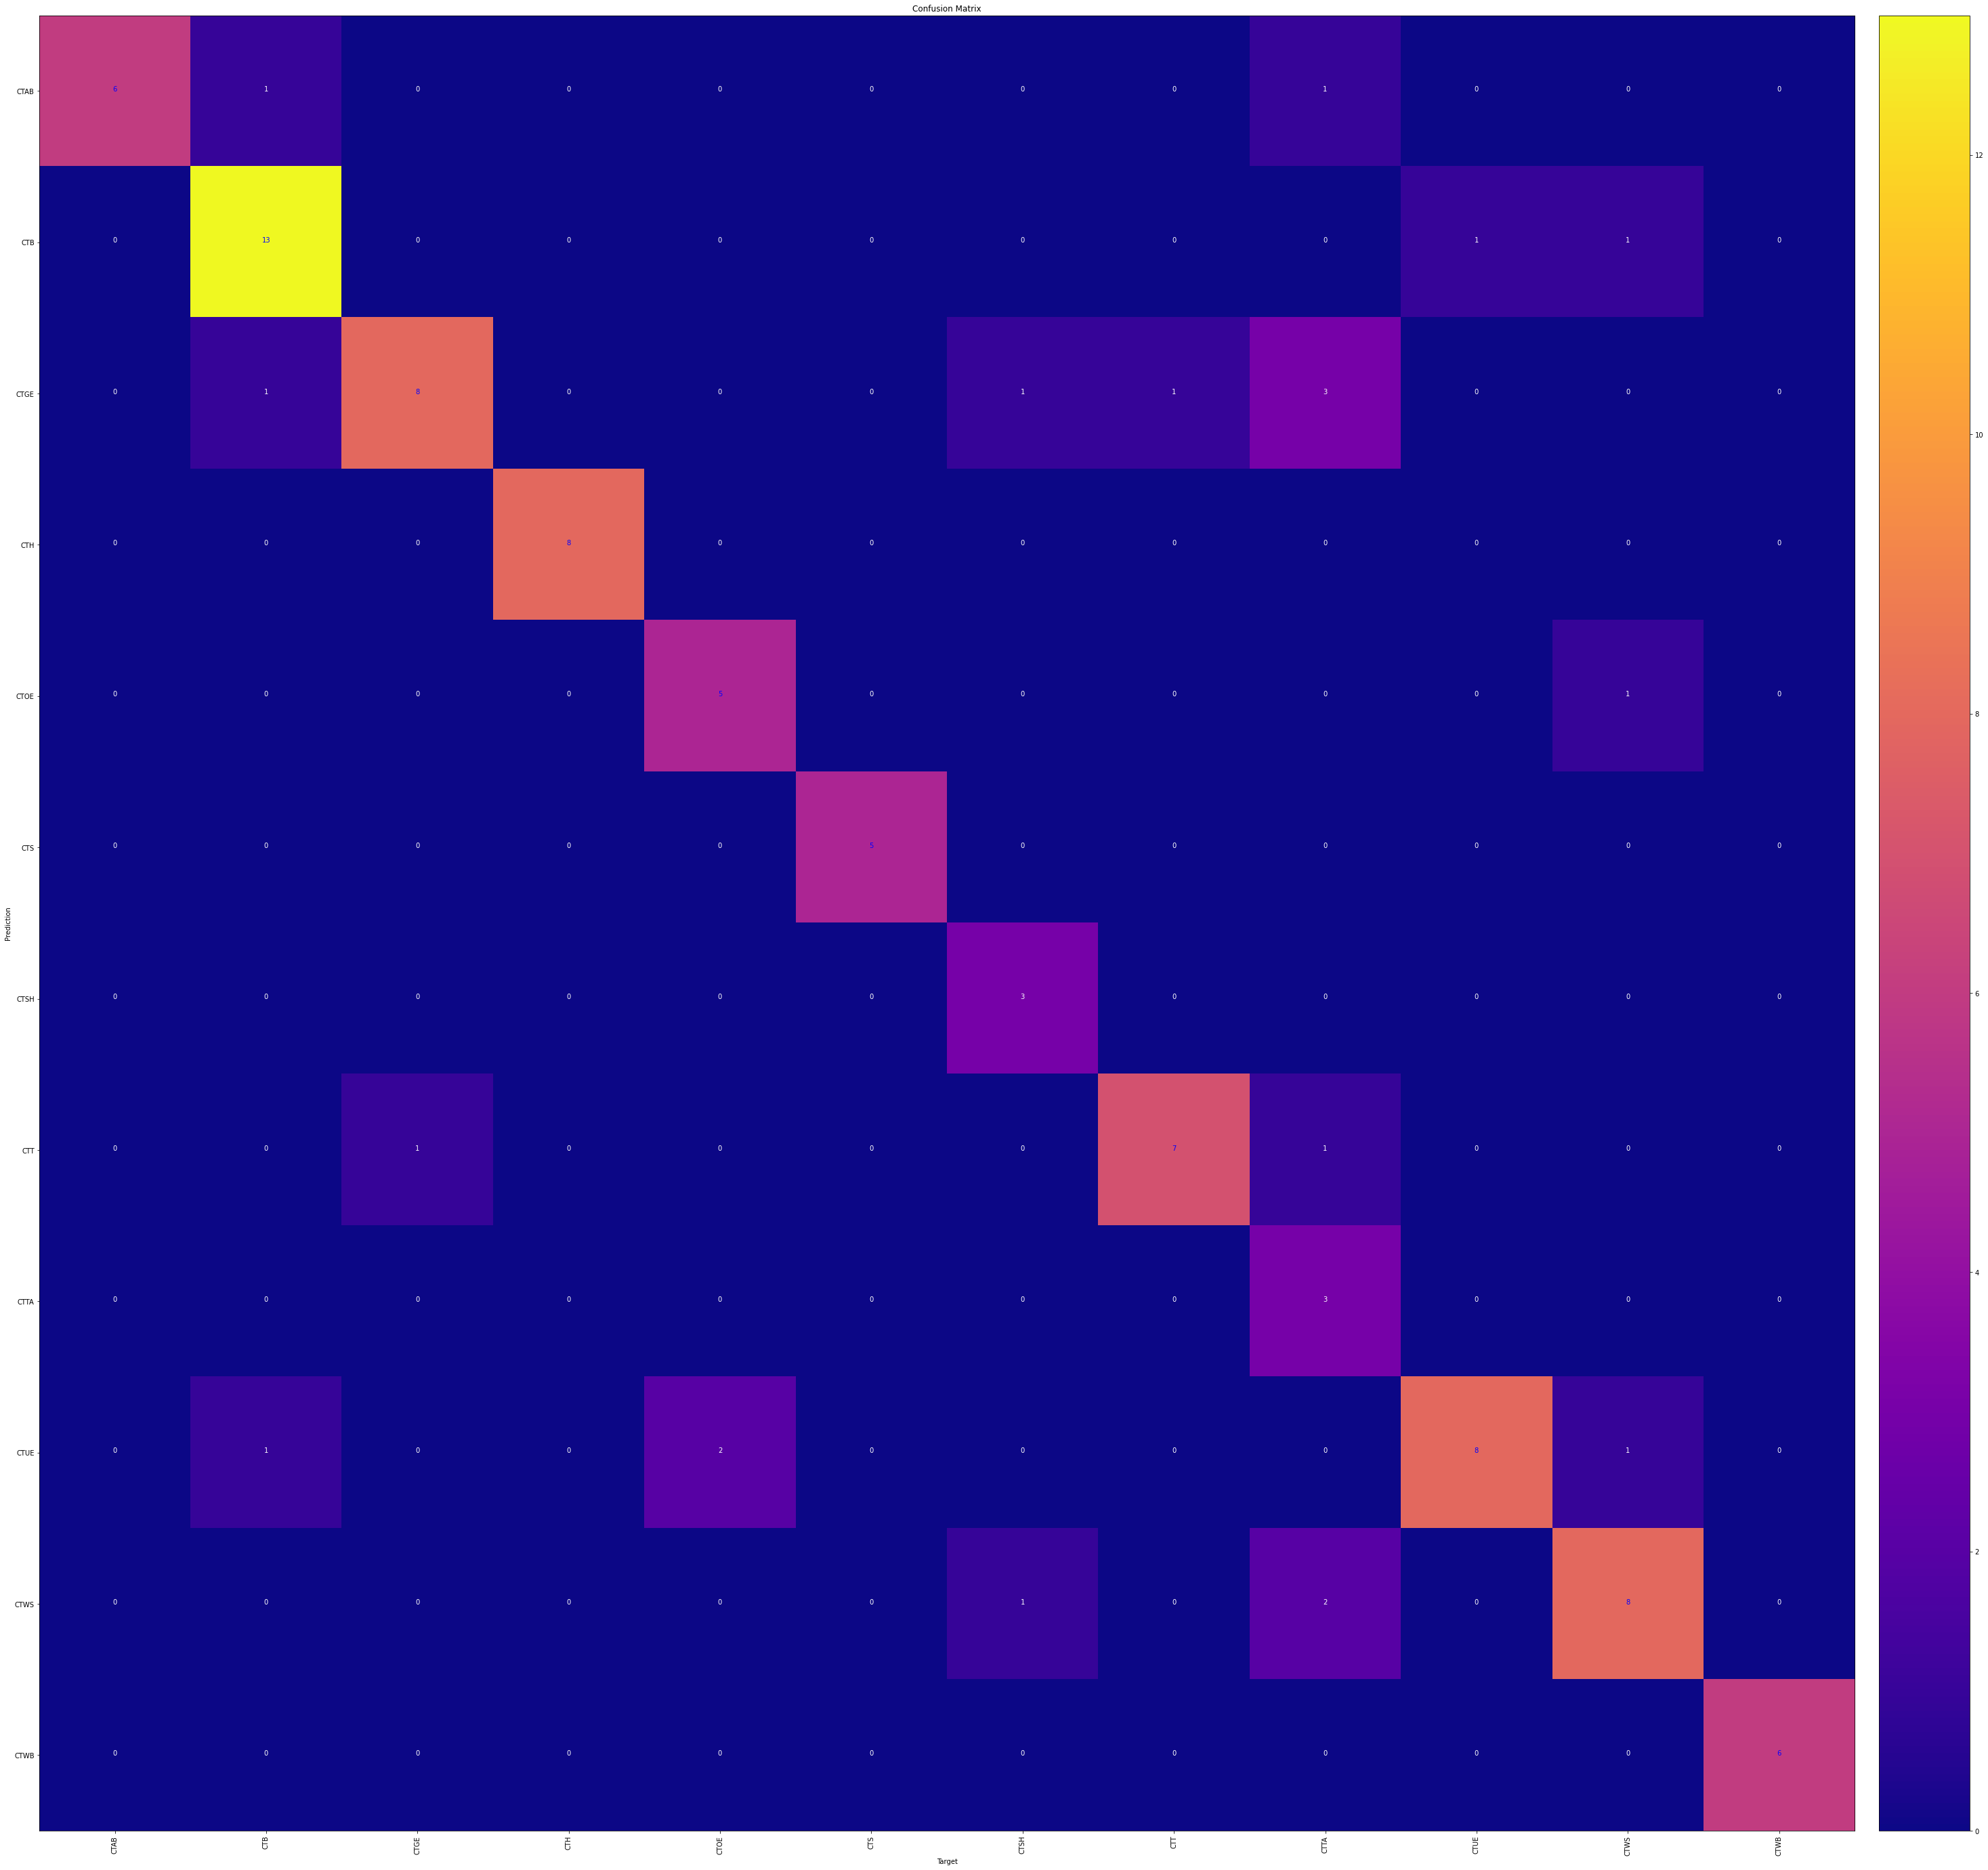

In [9]:

# test model
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
print("Temperature: T=", RN_Tmodel.temperature.item())
predictions, probabilities, targets = test_model(model = RN_Tmodel,
                                                 nc = nc,
                                                 mapfile = './CT_only.json',
                                                 test_loader = test_loader,
                                                 print_mistakes = True,
                                                 plot_mistakes = False)

for i in range(len(predictions)):
    print("Predicted class "+str(predictions[i])+" with p="+str(probabilities[i])+", target was class "+str(targets[i]))


In [10]:
#torch.save(RN_model, "./ResNet_CT_only.pth")

Epoch:0, Batch ID:1, Loss:2.7380740642547607
Epoch:0, Batch ID:2, Loss:2.49817156791687
Epoch:0, Batch ID:3, Loss:2.476978063583374
Epoch:0, Batch ID:4, Loss:2.4544551372528076
Epoch:0, Batch ID:5, Loss:2.247380018234253
Epoch:0, Batch ID:6, Loss:2.4055001735687256
Epoch:0, Batch ID:7, Loss:2.2043514251708984
Epoch:0, Batch ID:8, Loss:2.353590250015259
Epoch:0, Batch ID:9, Loss:2.14572811126709
Epoch:0, Batch ID:10, Loss:2.3392715454101562
Epoch:0, Batch ID:11, Loss:2.1650311946868896
Epoch:0, Batch ID:12, Loss:2.03652024269104
Epoch:0, Batch ID:13, Loss:2.0879125595092773
Epoch:0, Batch ID:14, Loss:2.1029529571533203
Epoch:0, Batch ID:15, Loss:2.1057002544403076
Epoch:0, Batch ID:16, Loss:2.0704736709594727
Epoch:0, Batch ID:17, Loss:1.592197299003601
Epoch:0, Batch ID:18, Loss:2.1420576572418213
Epoch:0, Batch ID:19, Loss:2.1398446559906006
Epoch:0, Batch ID:20, Loss:1.9047361612319946
Epoch:0, Batch ID:21, Loss:2.1998229026794434
Epoch:0, Batch ID:22, Loss:1.9487465620040894
Epoch:0

Epoch:2, Batch ID:41, Loss:0.9797046184539795
Epoch:2, Batch ID:42, Loss:1.004742980003357
Epoch:2, Batch ID:43, Loss:0.7348710894584656
Epoch:2, Batch ID:44, Loss:1.2089868783950806
Epoch:2, Batch ID:45, Loss:1.035620093345642
Epoch:2, Batch ID:46, Loss:0.7486016154289246
Epoch:2, Batch ID:47, Loss:0.9840709567070007
Epoch:2, Batch ID:48, Loss:1.050668478012085
Epoch:2, Batch ID:49, Loss:0.8970343470573425
Epoch:2, Batch ID:50, Loss:0.8721413016319275
Epoch:2, Batch ID:51, Loss:0.9955689907073975
Epoch:2, Batch ID:52, Loss:0.764040470123291
Epoch:2, Batch ID:53, Loss:1.1450176239013672
Epoch:2, Batch ID:54, Loss:0.7610729336738586
Epoch:2, Batch ID:55, Loss:1.0635322332382202
Epoch:2, Batch ID:56, Loss:1.0323983430862427
Epoch:2, Batch ID:57, Loss:0.7327306866645813
Epoch:2, Batch ID:58, Loss:1.00990891456604
Epoch:2, Batch ID:59, Loss:0.7969551086425781
Epoch:2, Batch ID:60, Loss:0.9746925830841064
Epoch:2, Batch ID:61, Loss:0.948397696018219
Epoch:2, Batch ID:62, Loss:1.688490867614

Epoch:5, Batch ID:11, Loss:0.3898411989212036
Epoch:5, Batch ID:12, Loss:0.3493841588497162
Epoch:5, Batch ID:13, Loss:0.6942310333251953
Epoch:5, Batch ID:14, Loss:0.39860260486602783
Epoch:5, Batch ID:15, Loss:0.3389188051223755
Epoch:5, Batch ID:16, Loss:1.0313220024108887
Epoch:5, Batch ID:17, Loss:0.562849223613739
Epoch:5, Batch ID:18, Loss:0.7779565453529358
Epoch:5, Batch ID:19, Loss:0.340969055891037
Epoch:5, Batch ID:20, Loss:0.25741133093833923
Epoch:5, Batch ID:21, Loss:0.7911405563354492
Epoch:5, Batch ID:22, Loss:0.5714687705039978
Epoch:5, Batch ID:23, Loss:0.4283064305782318
Epoch:5, Batch ID:24, Loss:0.6451604962348938
Epoch:5, Batch ID:25, Loss:0.6243875622749329
Epoch:5, Batch ID:26, Loss:0.6074264049530029
Epoch:5, Batch ID:27, Loss:0.42510703206062317
Epoch:5, Batch ID:28, Loss:0.4231143295764923
Epoch:5, Batch ID:29, Loss:0.3115066587924957
Epoch:5, Batch ID:30, Loss:0.5153064727783203
Epoch:5, Batch ID:31, Loss:0.35442617535591125
Epoch:5, Batch ID:32, Loss:0.395

Epoch:7, Batch ID:47, Loss:0.24166063964366913
Epoch:7, Batch ID:48, Loss:0.18827669322490692
Epoch:7, Batch ID:49, Loss:0.27133527398109436
Epoch:7, Batch ID:50, Loss:0.4037639796733856
Epoch:7, Batch ID:51, Loss:0.32595095038414
Epoch:7, Batch ID:52, Loss:0.23795612156391144
Epoch:7, Batch ID:53, Loss:0.4096639156341553
Epoch:7, Batch ID:54, Loss:0.33509424328804016
Epoch:7, Batch ID:55, Loss:0.3235560357570648
Epoch:7, Batch ID:56, Loss:0.3727929890155792
Epoch:7, Batch ID:57, Loss:0.290558397769928
Epoch:7, Batch ID:58, Loss:0.3600340187549591
Epoch:7, Batch ID:59, Loss:0.6326541304588318
Epoch:7, Batch ID:60, Loss:0.39376822113990784
Epoch:7, Batch ID:61, Loss:0.3700812757015228
Epoch:7, Batch ID:62, Loss:0.22617332637310028
Epoch:7, Batch ID:63, Loss:0.4253321886062622
Epoch:7, Batch ID:64, Loss:0.18356554210186005
Epoch:7, Batch ID:65, Loss:0.3708406388759613
Epoch:7, Batch ID:66, Loss:0.5399471521377563
Epoch:7, Batch ID:67, Loss:0.4481618404388428
Epoch:7, Batch ID:68, Loss:0.

Epoch:10, Batch ID:8, Loss:0.33343708515167236
Epoch:10, Batch ID:9, Loss:0.1914777010679245
Epoch:10, Batch ID:10, Loss:0.45704495906829834
Epoch:10, Batch ID:11, Loss:0.36032065749168396
Epoch:10, Batch ID:12, Loss:0.26776745915412903
Epoch:10, Batch ID:13, Loss:0.19512499868869781
Epoch:10, Batch ID:14, Loss:0.1824163794517517
Epoch:10, Batch ID:15, Loss:0.2644629180431366
Epoch:10, Batch ID:16, Loss:0.385833740234375
Epoch:10, Batch ID:17, Loss:0.4190806448459625
Epoch:10, Batch ID:18, Loss:0.31558898091316223
Epoch:10, Batch ID:19, Loss:0.2621774971485138
Epoch:10, Batch ID:20, Loss:0.24883872270584106
Epoch:10, Batch ID:21, Loss:0.3055596351623535
Epoch:10, Batch ID:22, Loss:0.17361833155155182
Epoch:10, Batch ID:23, Loss:0.07147255539894104
Epoch:10, Batch ID:24, Loss:0.047170013189315796
Epoch:10, Batch ID:25, Loss:0.22279512882232666
Epoch:10, Batch ID:26, Loss:0.5240693688392639
Epoch:10, Batch ID:27, Loss:0.28741106390953064
Epoch:10, Batch ID:28, Loss:0.4210015833377838
Epo

Epoch:12, Batch ID:36, Loss:0.25480398535728455
Epoch:12, Batch ID:37, Loss:0.14876164495944977
Epoch:12, Batch ID:38, Loss:0.14821724593639374
Epoch:12, Batch ID:39, Loss:0.12160155177116394
Epoch:12, Batch ID:40, Loss:0.29272857308387756
Epoch:12, Batch ID:41, Loss:0.4191007912158966
Epoch:12, Batch ID:42, Loss:0.22465388476848602
Epoch:12, Batch ID:43, Loss:0.23255640268325806
Epoch:12, Batch ID:44, Loss:0.42377662658691406
Epoch:12, Batch ID:45, Loss:0.277106374502182
Epoch:12, Batch ID:46, Loss:0.2665254771709442
Epoch:12, Batch ID:47, Loss:0.10788372904062271
Epoch:12, Batch ID:48, Loss:0.2403283268213272
Epoch:12, Batch ID:49, Loss:0.04739323630928993
Epoch:12, Batch ID:50, Loss:0.07712152600288391
Epoch:12, Batch ID:51, Loss:0.13632382452487946
Epoch:12, Batch ID:52, Loss:0.1858220100402832
Epoch:12, Batch ID:53, Loss:0.2521480917930603
Epoch:12, Batch ID:54, Loss:0.11635562777519226
Epoch:12, Batch ID:55, Loss:0.3634553849697113
Epoch:12, Batch ID:56, Loss:0.37068116664886475


Epoch:14, Batch ID:64, Loss:0.1257532685995102
Epoch:14, Batch ID:65, Loss:0.150665745139122
Epoch:14, Batch ID:66, Loss:0.33790895342826843
Epoch:14, Batch ID:67, Loss:0.31521186232566833
Epoch:14, Batch ID:68, Loss:0.21806059777736664
Epoch:14, Batch ID:69, Loss:0.1376967877149582
Epoch:14, Batch ID:70, Loss:0.1982228308916092
Recent average training loss: 0.2293498072091123
Current average training loss: 0.2131119630024047
Continuing training.
Epoch:15, Batch ID:1, Loss:0.08714089542627335
Epoch:15, Batch ID:2, Loss:0.07859963923692703
Epoch:15, Batch ID:3, Loss:0.30103984475135803
Epoch:15, Batch ID:4, Loss:0.35440269112586975
Epoch:15, Batch ID:5, Loss:0.07642588764429092
Epoch:15, Batch ID:6, Loss:0.13957339525222778
Epoch:15, Batch ID:7, Loss:0.13243651390075684
Epoch:15, Batch ID:8, Loss:0.040495116263628006
Epoch:15, Batch ID:9, Loss:0.15086455643177032
Epoch:15, Batch ID:10, Loss:0.06592889875173569
Epoch:15, Batch ID:11, Loss:0.16858242452144623
Epoch:15, Batch ID:12, Loss:0

Epoch:17, Batch ID:19, Loss:0.15976180136203766
Epoch:17, Batch ID:20, Loss:0.045177996158599854
Epoch:17, Batch ID:21, Loss:0.26262620091438293
Epoch:17, Batch ID:22, Loss:0.40975940227508545
Epoch:17, Batch ID:23, Loss:0.10568025708198547
Epoch:17, Batch ID:24, Loss:0.31819653511047363
Epoch:17, Batch ID:25, Loss:0.15795733034610748
Epoch:17, Batch ID:26, Loss:0.2546076774597168
Epoch:17, Batch ID:27, Loss:0.34233617782592773
Epoch:17, Batch ID:28, Loss:0.16779111325740814
Epoch:17, Batch ID:29, Loss:0.08471614122390747
Epoch:17, Batch ID:30, Loss:0.13366281986236572
Epoch:17, Batch ID:31, Loss:0.17918694019317627
Epoch:17, Batch ID:32, Loss:0.13915008306503296
Epoch:17, Batch ID:33, Loss:0.33568450808525085
Epoch:17, Batch ID:34, Loss:0.12978391349315643
Epoch:17, Batch ID:35, Loss:0.48851215839385986
Epoch:17, Batch ID:36, Loss:0.16386063396930695
Epoch:17, Batch ID:37, Loss:0.04244875907897949
Epoch:17, Batch ID:38, Loss:0.26690492033958435
Epoch:17, Batch ID:39, Loss:0.3098476827

Epoch:19, Batch ID:46, Loss:0.09244125336408615
Epoch:19, Batch ID:47, Loss:0.11774729937314987
Epoch:19, Batch ID:48, Loss:0.09849021583795547
Epoch:19, Batch ID:49, Loss:0.1695920079946518
Epoch:19, Batch ID:50, Loss:0.23883216083049774
Epoch:19, Batch ID:51, Loss:0.03872157633304596
Epoch:19, Batch ID:52, Loss:0.09845778346061707
Epoch:19, Batch ID:53, Loss:0.19803160429000854
Epoch:19, Batch ID:54, Loss:0.03219364583492279
Epoch:19, Batch ID:55, Loss:0.053598951548337936
Epoch:19, Batch ID:56, Loss:0.15638434886932373
Epoch:19, Batch ID:57, Loss:0.2760098874568939
Epoch:19, Batch ID:58, Loss:0.11928743869066238
Epoch:19, Batch ID:59, Loss:0.0620177797973156
Epoch:19, Batch ID:60, Loss:0.28669318556785583
Epoch:19, Batch ID:61, Loss:0.07759737968444824
Epoch:19, Batch ID:62, Loss:0.07145674526691437
Epoch:19, Batch ID:63, Loss:0.23685137927532196
Epoch:19, Batch ID:64, Loss:0.06828511506319046
Epoch:19, Batch ID:65, Loss:0.08715101331472397
Epoch:19, Batch ID:66, Loss:0.245479881763

Epoch:22, Batch ID:1, Loss:0.024868933483958244
Epoch:22, Batch ID:2, Loss:0.1605427861213684
Epoch:22, Batch ID:3, Loss:0.010559492744505405
Epoch:22, Batch ID:4, Loss:0.041073694825172424
Epoch:22, Batch ID:5, Loss:0.14520759880542755
Epoch:22, Batch ID:6, Loss:0.03959023579955101
Epoch:22, Batch ID:7, Loss:0.17685288190841675
Epoch:22, Batch ID:8, Loss:0.19903671741485596
Epoch:22, Batch ID:9, Loss:0.08946934342384338
Epoch:22, Batch ID:10, Loss:0.06312815099954605
Epoch:22, Batch ID:11, Loss:0.2122812271118164
Epoch:22, Batch ID:12, Loss:0.10207545757293701
Epoch:22, Batch ID:13, Loss:0.05338580533862114
Epoch:22, Batch ID:14, Loss:0.20884771645069122
Epoch:22, Batch ID:15, Loss:0.07127723842859268
Epoch:22, Batch ID:16, Loss:0.137920543551445
Epoch:22, Batch ID:17, Loss:0.1564527302980423
Epoch:22, Batch ID:18, Loss:0.07919761538505554
Epoch:22, Batch ID:19, Loss:0.31161075830459595
Epoch:22, Batch ID:20, Loss:0.07179105281829834
Epoch:22, Batch ID:21, Loss:0.390280157327652
Epoch

Epoch:24, Batch ID:28, Loss:0.39934447407722473
Epoch:24, Batch ID:29, Loss:0.08086287975311279
Epoch:24, Batch ID:30, Loss:0.04197768494486809
Epoch:24, Batch ID:31, Loss:0.06743865460157394
Epoch:24, Batch ID:32, Loss:0.1852102428674698
Epoch:24, Batch ID:33, Loss:0.08665154129266739
Epoch:24, Batch ID:34, Loss:0.06493402272462845
Epoch:24, Batch ID:35, Loss:0.06954846531152725
Epoch:24, Batch ID:36, Loss:0.14499938488006592
Epoch:24, Batch ID:37, Loss:0.40368643403053284
Epoch:24, Batch ID:38, Loss:0.13881836831569672
Epoch:24, Batch ID:39, Loss:0.08636248856782913
Epoch:24, Batch ID:40, Loss:0.1411793828010559
Epoch:24, Batch ID:41, Loss:0.13842929899692535
Epoch:24, Batch ID:42, Loss:0.053928300738334656
Epoch:24, Batch ID:43, Loss:0.21990889310836792
Epoch:24, Batch ID:44, Loss:0.21016152203083038
Epoch:24, Batch ID:45, Loss:0.027783742174506187
Epoch:24, Batch ID:46, Loss:0.03080631047487259
Epoch:24, Batch ID:47, Loss:0.07062957435846329
Epoch:24, Batch ID:48, Loss:0.0442296266

Epoch:26, Batch ID:54, Loss:0.09945284575223923
Epoch:26, Batch ID:55, Loss:0.05479033291339874
Epoch:26, Batch ID:56, Loss:0.03947220370173454
Epoch:26, Batch ID:57, Loss:0.20331738889217377
Epoch:26, Batch ID:58, Loss:0.20425814390182495
Epoch:26, Batch ID:59, Loss:0.06179329380393028
Epoch:26, Batch ID:60, Loss:0.060578763484954834
Epoch:26, Batch ID:61, Loss:0.047710955142974854
Epoch:26, Batch ID:62, Loss:0.02621445059776306
Epoch:26, Batch ID:63, Loss:0.1657792180776596
Epoch:26, Batch ID:64, Loss:0.017298350110650063
Epoch:26, Batch ID:65, Loss:0.05833602324128151
Epoch:26, Batch ID:66, Loss:0.06534642726182938
Epoch:26, Batch ID:67, Loss:0.08712925761938095
Epoch:26, Batch ID:68, Loss:0.09309966117143631
Epoch:26, Batch ID:69, Loss:0.21881617605686188
Epoch:26, Batch ID:70, Loss:0.058466505259275436
Recent average training loss: 0.11149170139647076
Current average training loss: 0.106335269922102
Continuing training.
Epoch:27, Batch ID:1, Loss:0.14772440493106842
Epoch:27, Batc

Epoch:29, Batch ID:8, Loss:0.24179953336715698
Epoch:29, Batch ID:9, Loss:0.30794867873191833
Epoch:29, Batch ID:10, Loss:0.09178226441144943
Epoch:29, Batch ID:11, Loss:0.03789069131016731
Epoch:29, Batch ID:12, Loss:0.06484556943178177
Epoch:29, Batch ID:13, Loss:0.029890120029449463
Epoch:29, Batch ID:14, Loss:0.0492979921400547
Epoch:29, Batch ID:15, Loss:0.03139342740178108
Epoch:29, Batch ID:16, Loss:0.05893617495894432
Epoch:29, Batch ID:17, Loss:0.24754218757152557
Epoch:29, Batch ID:18, Loss:0.046660732477903366
Epoch:29, Batch ID:19, Loss:0.07889372855424881
Epoch:29, Batch ID:20, Loss:0.06092716380953789
Epoch:29, Batch ID:21, Loss:0.21089456975460052
Epoch:29, Batch ID:22, Loss:0.09328816086053848
Epoch:29, Batch ID:23, Loss:0.044290971010923386
Epoch:29, Batch ID:24, Loss:0.20861448347568512
Epoch:29, Batch ID:25, Loss:0.03430895879864693
Epoch:29, Batch ID:26, Loss:0.024602187797427177
Epoch:29, Batch ID:27, Loss:0.2195606231689453
Epoch:29, Batch ID:28, Loss:0.0837658941

Epoch:31, Batch ID:34, Loss:0.03599315136671066
Epoch:31, Batch ID:35, Loss:0.11613308638334274
Epoch:31, Batch ID:36, Loss:0.10015853494405746
Epoch:31, Batch ID:37, Loss:0.12397404760122299
Epoch:31, Batch ID:38, Loss:0.04259352758526802
Epoch:31, Batch ID:39, Loss:0.04392564296722412
Epoch:31, Batch ID:40, Loss:0.07054761797189713
Epoch:31, Batch ID:41, Loss:0.02338760532438755
Epoch:31, Batch ID:42, Loss:0.03450018912553787
Epoch:31, Batch ID:43, Loss:0.09321773052215576
Epoch:31, Batch ID:44, Loss:0.14528577029705048
Epoch:31, Batch ID:45, Loss:0.035332027822732925
Epoch:31, Batch ID:46, Loss:0.12900221347808838
Epoch:31, Batch ID:47, Loss:0.09047085791826248
Epoch:31, Batch ID:48, Loss:0.024435190483927727
Epoch:31, Batch ID:49, Loss:0.023962633684277534
Epoch:31, Batch ID:50, Loss:0.16606207191944122
Epoch:31, Batch ID:51, Loss:0.013487458229064941
Epoch:31, Batch ID:52, Loss:0.1636584848165512
Epoch:31, Batch ID:53, Loss:0.022420043125748634
Epoch:31, Batch ID:54, Loss:0.063040

Epoch:33, Batch ID:60, Loss:0.06763628870248795
Epoch:33, Batch ID:61, Loss:0.00928586907684803
Epoch:33, Batch ID:62, Loss:0.02857845276594162
Epoch:33, Batch ID:63, Loss:0.0849597230553627
Epoch:33, Batch ID:64, Loss:0.08863852173089981
Epoch:33, Batch ID:65, Loss:0.034160833805799484
Epoch:33, Batch ID:66, Loss:0.15890702605247498
Epoch:33, Batch ID:67, Loss:0.09324905276298523
Epoch:33, Batch ID:68, Loss:0.08523689955472946
Epoch:33, Batch ID:69, Loss:0.01813977025449276
Epoch:33, Batch ID:70, Loss:0.1316615343093872
Recent average training loss: 0.0859794186349486
Current average training loss: 0.0859416351142064
Continuing training.
Epoch:34, Batch ID:1, Loss:0.12220603227615356
Epoch:34, Batch ID:2, Loss:0.11080867797136307
Epoch:34, Batch ID:3, Loss:0.02956831268966198
Epoch:34, Batch ID:4, Loss:0.07556526362895966
Epoch:34, Batch ID:5, Loss:0.026675080880522728
Epoch:34, Batch ID:6, Loss:0.05655444785952568
Epoch:34, Batch ID:7, Loss:0.0927719697356224
Epoch:34, Batch ID:8, Lo

Epoch:36, Batch ID:14, Loss:0.03163878247141838
Epoch:36, Batch ID:15, Loss:0.02422691136598587
Epoch:36, Batch ID:16, Loss:0.033798202872276306
Epoch:36, Batch ID:17, Loss:0.2145376205444336
Epoch:36, Batch ID:18, Loss:0.03150741755962372
Epoch:36, Batch ID:19, Loss:0.2047615498304367
Epoch:36, Batch ID:20, Loss:0.3002031445503235
Epoch:36, Batch ID:21, Loss:0.020552044734358788
Epoch:36, Batch ID:22, Loss:0.1744256168603897
Epoch:36, Batch ID:23, Loss:0.03408980369567871
Epoch:36, Batch ID:24, Loss:0.03744663670659065
Epoch:36, Batch ID:25, Loss:0.12116989493370056
Epoch:36, Batch ID:26, Loss:0.21895460784435272
Epoch:36, Batch ID:27, Loss:0.04490843787789345
Epoch:36, Batch ID:28, Loss:0.17956934869289398
Epoch:36, Batch ID:29, Loss:0.011962161399424076
Epoch:36, Batch ID:30, Loss:0.01703069545328617
Epoch:36, Batch ID:31, Loss:0.006963831838220358
Epoch:36, Batch ID:32, Loss:0.0182315893471241
Epoch:36, Batch ID:33, Loss:0.0192332211881876
Epoch:36, Batch ID:34, Loss:0.026975730434

Epoch:38, Batch ID:40, Loss:0.02428951859474182
Epoch:38, Batch ID:41, Loss:0.1944265365600586
Epoch:38, Batch ID:42, Loss:0.010798721574246883
Epoch:38, Batch ID:43, Loss:0.014330971986055374
Epoch:38, Batch ID:44, Loss:0.08699491620063782
Epoch:38, Batch ID:45, Loss:0.0586804561316967
Epoch:38, Batch ID:46, Loss:0.013023864477872849
Epoch:38, Batch ID:47, Loss:0.05637599155306816
Epoch:38, Batch ID:48, Loss:0.01699576899409294
Epoch:38, Batch ID:49, Loss:0.08179540187120438
Epoch:38, Batch ID:50, Loss:0.06380508095026016
Epoch:38, Batch ID:51, Loss:0.014157419092953205
Epoch:38, Batch ID:52, Loss:0.0245243888348341
Epoch:38, Batch ID:53, Loss:0.009057767689228058
Epoch:38, Batch ID:54, Loss:0.007002408150583506
Epoch:38, Batch ID:55, Loss:0.288613885641098
Epoch:38, Batch ID:56, Loss:0.06639880686998367
Epoch:38, Batch ID:57, Loss:0.03169336915016174
Epoch:38, Batch ID:58, Loss:0.0429755263030529
Epoch:38, Batch ID:59, Loss:0.022413386031985283
Epoch:38, Batch ID:60, Loss:0.047931164

Epoch:40, Batch ID:66, Loss:0.10824081301689148
Epoch:40, Batch ID:67, Loss:0.099071204662323
Epoch:40, Batch ID:68, Loss:0.051415666937828064
Epoch:40, Batch ID:69, Loss:0.008527982980012894
Epoch:40, Batch ID:70, Loss:0.00940745510160923
Recent average training loss: 0.07139043044036543
Current average training loss: 0.07120168896811739
Continuing training.
Epoch:41, Batch ID:1, Loss:0.013178092427551746
Epoch:41, Batch ID:2, Loss:0.023318229243159294
Epoch:41, Batch ID:3, Loss:0.022019512951374054
Epoch:41, Batch ID:4, Loss:0.05980577692389488
Epoch:41, Batch ID:5, Loss:0.07156921178102493
Epoch:41, Batch ID:6, Loss:0.10779264569282532
Epoch:41, Batch ID:7, Loss:0.11655568331480026
Epoch:41, Batch ID:8, Loss:0.010695640929043293
Epoch:41, Batch ID:9, Loss:0.01689956523478031
Epoch:41, Batch ID:10, Loss:0.030428489670157433
Epoch:41, Batch ID:11, Loss:0.07919985055923462
Epoch:41, Batch ID:12, Loss:0.06324177235364914
Epoch:41, Batch ID:13, Loss:0.11022598296403885
Epoch:41, Batch ID

Epoch:43, Batch ID:19, Loss:0.12644004821777344
Epoch:43, Batch ID:20, Loss:0.0766381174325943
Epoch:43, Batch ID:21, Loss:0.02256263978779316
Epoch:43, Batch ID:22, Loss:0.013909294269979
Epoch:43, Batch ID:23, Loss:0.09878137707710266
Epoch:43, Batch ID:24, Loss:0.03423703461885452
Epoch:43, Batch ID:25, Loss:0.057726386934518814
Epoch:43, Batch ID:26, Loss:0.15055355429649353
Epoch:43, Batch ID:27, Loss:0.06072123721241951
Epoch:43, Batch ID:28, Loss:0.02992422878742218
Epoch:43, Batch ID:29, Loss:0.4088537395000458
Epoch:43, Batch ID:30, Loss:0.012322439812123775
Epoch:43, Batch ID:31, Loss:0.02775672823190689
Epoch:43, Batch ID:32, Loss:0.06246067211031914
Epoch:43, Batch ID:33, Loss:0.12946021556854248
Epoch:43, Batch ID:34, Loss:0.3115655481815338
Epoch:43, Batch ID:35, Loss:0.20725716650485992
Epoch:43, Batch ID:36, Loss:0.045342396944761276
Epoch:43, Batch ID:37, Loss:0.019509010016918182
Epoch:43, Batch ID:38, Loss:0.10163403302431107
Epoch:43, Batch ID:39, Loss:0.02547112666

Epoch:45, Batch ID:45, Loss:0.008974838070571423
Epoch:45, Batch ID:46, Loss:0.008775085210800171
Epoch:45, Batch ID:47, Loss:0.09220999479293823
Epoch:45, Batch ID:48, Loss:0.042920541018247604
Epoch:45, Batch ID:49, Loss:0.034973278641700745
Epoch:45, Batch ID:50, Loss:0.08915110677480698
Epoch:45, Batch ID:51, Loss:0.028407283127307892
Epoch:45, Batch ID:52, Loss:0.00982463825494051
Epoch:45, Batch ID:53, Loss:0.16626857221126556
Epoch:45, Batch ID:54, Loss:0.026876896619796753
Epoch:45, Batch ID:55, Loss:0.03648047894239426
Epoch:45, Batch ID:56, Loss:0.025359993800520897
Epoch:45, Batch ID:57, Loss:0.031110433861613274
Epoch:45, Batch ID:58, Loss:0.030387267470359802
Epoch:45, Batch ID:59, Loss:0.16751743853092194
Epoch:45, Batch ID:60, Loss:0.03135189786553383
Epoch:45, Batch ID:61, Loss:0.04086219146847725
Epoch:45, Batch ID:62, Loss:0.031188195571303368
Epoch:45, Batch ID:63, Loss:0.0015950073720887303
Epoch:45, Batch ID:64, Loss:0.028909971937537193
Epoch:45, Batch ID:65, Loss

Epoch:47, Batch ID:70, Loss:0.013102122582495213
Recent average training loss: 0.06587148283536112
Current average training loss: 0.06912370998622246
Network parameters appear to have converged, aborting training.
Before temperature - NLL: 0.905, ECE: 0.104


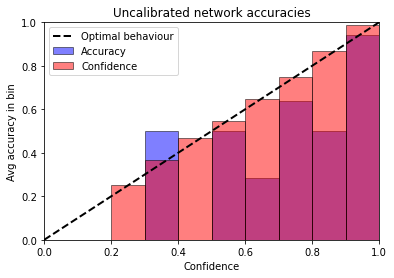

Optimal temperature: 1.879
After temperature - NLL: 0.905, ECE: 0.051


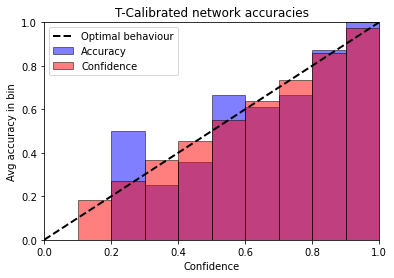

Temperature: T= 1.8792108297348022
n_classes:  13
Loss:0.6739937150717846,Accuracy:79.52380952380952%


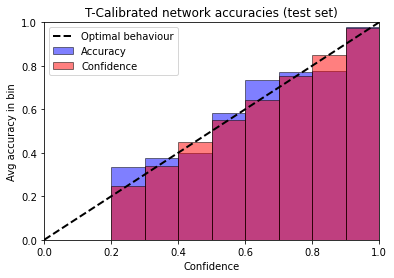

Epoch:0, Batch ID:1, Loss:2.6789066791534424
Epoch:0, Batch ID:2, Loss:2.5153648853302
Epoch:0, Batch ID:3, Loss:2.527531385421753
Epoch:0, Batch ID:4, Loss:2.480536460876465
Epoch:0, Batch ID:5, Loss:2.5226805210113525
Epoch:0, Batch ID:6, Loss:2.4920194149017334
Epoch:0, Batch ID:7, Loss:2.387133836746216
Epoch:0, Batch ID:8, Loss:2.086740493774414
Epoch:0, Batch ID:9, Loss:2.1750097274780273
Epoch:0, Batch ID:10, Loss:2.105483055114746
Epoch:0, Batch ID:11, Loss:2.1257102489471436
Epoch:0, Batch ID:12, Loss:2.335536241531372
Epoch:0, Batch ID:13, Loss:2.319709539413452
Epoch:0, Batch ID:14, Loss:2.013043165206909
Epoch:0, Batch ID:15, Loss:1.947848916053772
Epoch:0, Batch ID:16, Loss:2.0316250324249268
Epoch:0, Batch ID:17, Loss:2.089214563369751
Epoch:0, Batch ID:18, Loss:1.8420084714889526
Epoch:0, Batch ID:19, Loss:1.7759946584701538
Epoch:0, Batch ID:20, Loss:1.8007092475891113
Epoch:0, Batch ID:21, Loss:1.8917850255966187
Epoch:0, Batch ID:22, Loss:1.6189168691635132
Epoch:0, B

Epoch:2, Batch ID:41, Loss:0.845846951007843
Epoch:2, Batch ID:42, Loss:0.8558011054992676
Epoch:2, Batch ID:43, Loss:1.1406171321868896
Epoch:2, Batch ID:44, Loss:0.9749422073364258
Epoch:2, Batch ID:45, Loss:0.7643333077430725
Epoch:2, Batch ID:46, Loss:0.9155654907226562
Epoch:2, Batch ID:47, Loss:1.0639292001724243
Epoch:2, Batch ID:48, Loss:0.7404825687408447
Epoch:2, Batch ID:49, Loss:1.3787951469421387
Epoch:2, Batch ID:50, Loss:0.8911619186401367
Epoch:2, Batch ID:51, Loss:0.9439637660980225
Epoch:2, Batch ID:52, Loss:0.7587968707084656
Epoch:2, Batch ID:53, Loss:1.2232873439788818
Epoch:2, Batch ID:54, Loss:1.129533290863037
Epoch:2, Batch ID:55, Loss:0.9573831558227539
Epoch:2, Batch ID:56, Loss:1.0980859994888306
Epoch:2, Batch ID:57, Loss:0.9528871178627014
Epoch:2, Batch ID:58, Loss:0.8984145522117615
Epoch:2, Batch ID:59, Loss:1.0735104084014893
Epoch:2, Batch ID:60, Loss:0.9084482192993164
Epoch:2, Batch ID:61, Loss:0.9366667866706848
Epoch:2, Batch ID:62, Loss:0.7458335

Epoch:5, Batch ID:10, Loss:0.3741697371006012
Epoch:5, Batch ID:11, Loss:0.6011380553245544
Epoch:5, Batch ID:12, Loss:0.7766692042350769
Epoch:5, Batch ID:13, Loss:0.5529847741127014
Epoch:5, Batch ID:14, Loss:0.5605489611625671
Epoch:5, Batch ID:15, Loss:0.530282199382782
Epoch:5, Batch ID:16, Loss:1.0999492406845093
Epoch:5, Batch ID:17, Loss:0.5907678604125977
Epoch:5, Batch ID:18, Loss:0.5527172088623047
Epoch:5, Batch ID:19, Loss:0.4517711102962494
Epoch:5, Batch ID:20, Loss:0.5246268510818481
Epoch:5, Batch ID:21, Loss:0.4539567232131958
Epoch:5, Batch ID:22, Loss:0.5569020509719849
Epoch:5, Batch ID:23, Loss:0.7968793511390686
Epoch:5, Batch ID:24, Loss:0.9089899063110352
Epoch:5, Batch ID:25, Loss:0.39557528495788574
Epoch:5, Batch ID:26, Loss:0.6891841888427734
Epoch:5, Batch ID:27, Loss:0.6266321539878845
Epoch:5, Batch ID:28, Loss:0.3278360962867737
Epoch:5, Batch ID:29, Loss:0.41770151257514954
Epoch:5, Batch ID:30, Loss:0.7530823349952698
Epoch:5, Batch ID:31, Loss:0.7904

Epoch:7, Batch ID:46, Loss:0.19524557888507843
Epoch:7, Batch ID:47, Loss:0.18689405918121338
Epoch:7, Batch ID:48, Loss:0.31848546862602234
Epoch:7, Batch ID:49, Loss:0.3044266402721405
Epoch:7, Batch ID:50, Loss:0.7124260067939758
Epoch:7, Batch ID:51, Loss:0.7128477096557617
Epoch:7, Batch ID:52, Loss:0.49716535210609436
Epoch:7, Batch ID:53, Loss:0.21337829530239105
Epoch:7, Batch ID:54, Loss:0.5846344828605652
Epoch:7, Batch ID:55, Loss:0.7121914029121399
Epoch:7, Batch ID:56, Loss:0.8473873138427734
Epoch:7, Batch ID:57, Loss:0.17028607428073883
Epoch:7, Batch ID:58, Loss:0.24389593303203583
Epoch:7, Batch ID:59, Loss:0.33716046810150146
Epoch:7, Batch ID:60, Loss:0.6357060670852661
Epoch:7, Batch ID:61, Loss:0.4107227027416229
Epoch:7, Batch ID:62, Loss:0.3835834562778473
Epoch:7, Batch ID:63, Loss:0.3257847726345062
Epoch:7, Batch ID:64, Loss:0.310666561126709
Epoch:7, Batch ID:65, Loss:0.5517193078994751
Epoch:7, Batch ID:66, Loss:0.3169137239456177
Epoch:7, Batch ID:67, Loss:

Epoch:10, Batch ID:7, Loss:0.15858188271522522
Epoch:10, Batch ID:8, Loss:0.18767149746418
Epoch:10, Batch ID:9, Loss:0.5923975706100464
Epoch:10, Batch ID:10, Loss:0.37795376777648926
Epoch:10, Batch ID:11, Loss:0.18835560977458954
Epoch:10, Batch ID:12, Loss:0.2341862916946411
Epoch:10, Batch ID:13, Loss:0.3709813356399536
Epoch:10, Batch ID:14, Loss:0.34234586358070374
Epoch:10, Batch ID:15, Loss:0.23634640872478485
Epoch:10, Batch ID:16, Loss:0.2054411917924881
Epoch:10, Batch ID:17, Loss:0.28579553961753845
Epoch:10, Batch ID:18, Loss:0.474183052778244
Epoch:10, Batch ID:19, Loss:0.17725075781345367
Epoch:10, Batch ID:20, Loss:0.5171754956245422
Epoch:10, Batch ID:21, Loss:0.2873855233192444
Epoch:10, Batch ID:22, Loss:0.2652911841869354
Epoch:10, Batch ID:23, Loss:0.3298574388027191
Epoch:10, Batch ID:24, Loss:0.5422095656394958
Epoch:10, Batch ID:25, Loss:0.15435092151165009
Epoch:10, Batch ID:26, Loss:0.15899264812469482
Epoch:10, Batch ID:27, Loss:0.17627359926700592
Epoch:10,

Epoch:12, Batch ID:35, Loss:0.23502369225025177
Epoch:12, Batch ID:36, Loss:0.5050761103630066
Epoch:12, Batch ID:37, Loss:0.3119320571422577
Epoch:12, Batch ID:38, Loss:0.10001153498888016
Epoch:12, Batch ID:39, Loss:0.3877600133419037
Epoch:12, Batch ID:40, Loss:0.17159122228622437
Epoch:12, Batch ID:41, Loss:0.28802207112312317
Epoch:12, Batch ID:42, Loss:0.6393360495567322
Epoch:12, Batch ID:43, Loss:0.14020441472530365
Epoch:12, Batch ID:44, Loss:0.3093688488006592
Epoch:12, Batch ID:45, Loss:0.1252775639295578
Epoch:12, Batch ID:46, Loss:0.17221291363239288
Epoch:12, Batch ID:47, Loss:0.09777676314115524
Epoch:12, Batch ID:48, Loss:0.11171586066484451
Epoch:12, Batch ID:49, Loss:0.07835549116134644
Epoch:12, Batch ID:50, Loss:0.30979931354522705
Epoch:12, Batch ID:51, Loss:0.15577052533626556
Epoch:12, Batch ID:52, Loss:0.22187556326389313
Epoch:12, Batch ID:53, Loss:0.29095733165740967
Epoch:12, Batch ID:54, Loss:0.4359573423862457
Epoch:12, Batch ID:55, Loss:0.3928315341472626


Epoch:14, Batch ID:63, Loss:0.1629134714603424
Epoch:14, Batch ID:64, Loss:0.14850273728370667
Epoch:14, Batch ID:65, Loss:0.21214908361434937
Epoch:14, Batch ID:66, Loss:0.07584532350301743
Epoch:14, Batch ID:67, Loss:0.22564935684204102
Epoch:14, Batch ID:68, Loss:0.2849436104297638
Epoch:14, Batch ID:69, Loss:0.24542789161205292
Epoch:14, Batch ID:70, Loss:0.1227923110127449
Recent average training loss: 0.2521509420861241
Current average training loss: 0.23734029155277034
Continuing training.
Epoch:15, Batch ID:1, Loss:0.12923754751682281
Epoch:15, Batch ID:2, Loss:0.04299019277095795
Epoch:15, Batch ID:3, Loss:0.0601339153945446
Epoch:15, Batch ID:4, Loss:0.33324193954467773
Epoch:15, Batch ID:5, Loss:0.09013602882623672
Epoch:15, Batch ID:6, Loss:0.05821062996983528
Epoch:15, Batch ID:7, Loss:0.19787929952144623
Epoch:15, Batch ID:8, Loss:0.20584577322006226
Epoch:15, Batch ID:9, Loss:0.17586322128772736
Epoch:15, Batch ID:10, Loss:0.2936708629131317
Epoch:15, Batch ID:11, Loss:0

Epoch:17, Batch ID:18, Loss:0.2049059271812439
Epoch:17, Batch ID:19, Loss:0.13612298667430878
Epoch:17, Batch ID:20, Loss:0.09393591433763504
Epoch:17, Batch ID:21, Loss:0.15378087759017944
Epoch:17, Batch ID:22, Loss:0.16889911890029907
Epoch:17, Batch ID:23, Loss:0.12628211081027985
Epoch:17, Batch ID:24, Loss:0.2096647471189499
Epoch:17, Batch ID:25, Loss:0.030457839369773865
Epoch:17, Batch ID:26, Loss:0.043775007128715515
Epoch:17, Batch ID:27, Loss:0.03470566123723984
Epoch:17, Batch ID:28, Loss:0.23257888853549957
Epoch:17, Batch ID:29, Loss:0.10673206299543381
Epoch:17, Batch ID:30, Loss:0.19504684209823608
Epoch:17, Batch ID:31, Loss:0.1330379694700241
Epoch:17, Batch ID:32, Loss:0.2537533938884735
Epoch:17, Batch ID:33, Loss:0.09532205015420914
Epoch:17, Batch ID:34, Loss:0.12224706262350082
Epoch:17, Batch ID:35, Loss:0.11044985055923462
Epoch:17, Batch ID:36, Loss:0.06804590672254562
Epoch:17, Batch ID:37, Loss:0.12634161114692688
Epoch:17, Batch ID:38, Loss:0.067938402295

Epoch:19, Batch ID:45, Loss:0.08692874759435654
Epoch:19, Batch ID:46, Loss:0.07107654958963394
Epoch:19, Batch ID:47, Loss:0.11923442035913467
Epoch:19, Batch ID:48, Loss:0.02549232728779316
Epoch:19, Batch ID:49, Loss:0.08430751413106918
Epoch:19, Batch ID:50, Loss:0.14708976447582245
Epoch:19, Batch ID:51, Loss:0.043050263077020645
Epoch:19, Batch ID:52, Loss:0.08406540006399155
Epoch:19, Batch ID:53, Loss:0.06865803152322769
Epoch:19, Batch ID:54, Loss:0.039554547518491745
Epoch:19, Batch ID:55, Loss:0.08789831399917603
Epoch:19, Batch ID:56, Loss:0.12153604626655579
Epoch:19, Batch ID:57, Loss:0.0351431630551815
Epoch:19, Batch ID:58, Loss:0.025697894394397736
Epoch:19, Batch ID:59, Loss:0.08760303258895874
Epoch:19, Batch ID:60, Loss:0.4226001799106598
Epoch:19, Batch ID:61, Loss:0.15106526017189026
Epoch:19, Batch ID:62, Loss:0.1090315580368042
Epoch:19, Batch ID:63, Loss:0.18917596340179443
Epoch:19, Batch ID:64, Loss:0.13846205174922943
Epoch:19, Batch ID:65, Loss:0.2789654731

Epoch:22, Batch ID:1, Loss:0.02124258689582348
Epoch:22, Batch ID:2, Loss:0.0512847863137722
Epoch:22, Batch ID:3, Loss:0.060655102133750916
Epoch:22, Batch ID:4, Loss:0.10427066683769226
Epoch:22, Batch ID:5, Loss:0.044198110699653625
Epoch:22, Batch ID:6, Loss:0.06518489867448807
Epoch:22, Batch ID:7, Loss:0.1794614940881729
Epoch:22, Batch ID:8, Loss:0.08236006647348404
Epoch:22, Batch ID:9, Loss:0.13079139590263367
Epoch:22, Batch ID:10, Loss:0.08059640973806381
Epoch:22, Batch ID:11, Loss:0.08381328731775284
Epoch:22, Batch ID:12, Loss:0.07587689906358719
Epoch:22, Batch ID:13, Loss:0.1816546767950058
Epoch:22, Batch ID:14, Loss:0.2219846397638321
Epoch:22, Batch ID:15, Loss:0.050066471099853516
Epoch:22, Batch ID:16, Loss:0.057227909564971924
Epoch:22, Batch ID:17, Loss:0.14988134801387787
Epoch:22, Batch ID:18, Loss:0.2009764462709427
Epoch:22, Batch ID:19, Loss:0.07810045778751373
Epoch:22, Batch ID:20, Loss:0.2143775373697281
Epoch:22, Batch ID:21, Loss:0.33370259404182434
Epo

Epoch:24, Batch ID:28, Loss:0.020812565460801125
Epoch:24, Batch ID:29, Loss:0.1497087925672531
Epoch:24, Batch ID:30, Loss:0.15205077826976776
Epoch:24, Batch ID:31, Loss:0.08094228059053421
Epoch:24, Batch ID:32, Loss:0.14836326241493225
Epoch:24, Batch ID:33, Loss:0.04923729971051216
Epoch:24, Batch ID:34, Loss:0.19240815937519073
Epoch:24, Batch ID:35, Loss:0.3817678987979889
Epoch:24, Batch ID:36, Loss:0.23619119822978973
Epoch:24, Batch ID:37, Loss:0.06886620074510574
Epoch:24, Batch ID:38, Loss:0.037108708173036575
Epoch:24, Batch ID:39, Loss:0.04835560545325279
Epoch:24, Batch ID:40, Loss:0.1376393586397171
Epoch:24, Batch ID:41, Loss:0.23278629779815674
Epoch:24, Batch ID:42, Loss:0.07348864525556564
Epoch:24, Batch ID:43, Loss:0.043463874608278275
Epoch:24, Batch ID:44, Loss:0.029118889942765236
Epoch:24, Batch ID:45, Loss:0.12000592797994614
Epoch:24, Batch ID:46, Loss:0.06617306917905807
Epoch:24, Batch ID:47, Loss:0.014308328740298748
Epoch:24, Batch ID:48, Loss:0.04559706

Epoch:26, Batch ID:54, Loss:0.2896435558795929
Epoch:26, Batch ID:55, Loss:0.09238521009683609
Epoch:26, Batch ID:56, Loss:0.07135235518217087
Epoch:26, Batch ID:57, Loss:0.0835639014840126
Epoch:26, Batch ID:58, Loss:0.09400410205125809
Epoch:26, Batch ID:59, Loss:0.022347742691636086
Epoch:26, Batch ID:60, Loss:0.11679943650960922
Epoch:26, Batch ID:61, Loss:0.28251463174819946
Epoch:26, Batch ID:62, Loss:0.023641666397452354
Epoch:26, Batch ID:63, Loss:0.15055207908153534
Epoch:26, Batch ID:64, Loss:0.03223938122391701
Epoch:26, Batch ID:65, Loss:0.1530260592699051
Epoch:26, Batch ID:66, Loss:0.04694904759526253
Epoch:26, Batch ID:67, Loss:0.09465161710977554
Epoch:26, Batch ID:68, Loss:0.14981545507907867
Epoch:26, Batch ID:69, Loss:0.05817757919430733
Epoch:26, Batch ID:70, Loss:0.06358903646469116
Recent average training loss: 0.11437336427985992
Current average training loss: 0.11247562709408747
Continuing training.
Epoch:27, Batch ID:1, Loss:0.1553947776556015
Epoch:27, Batch I

Epoch:29, Batch ID:8, Loss:0.03855925425887108
Epoch:29, Batch ID:9, Loss:0.0611918680369854
Epoch:29, Batch ID:10, Loss:0.03731347993016243
Epoch:29, Batch ID:11, Loss:0.024530423805117607
Epoch:29, Batch ID:12, Loss:0.03450162336230278
Epoch:29, Batch ID:13, Loss:0.1926618069410324
Epoch:29, Batch ID:14, Loss:0.06569584459066391
Epoch:29, Batch ID:15, Loss:0.025630541145801544
Epoch:29, Batch ID:16, Loss:0.21584554016590118
Epoch:29, Batch ID:17, Loss:0.16607807576656342
Epoch:29, Batch ID:18, Loss:0.3646259605884552
Epoch:29, Batch ID:19, Loss:0.04885751008987427
Epoch:29, Batch ID:20, Loss:0.5907589793205261
Epoch:29, Batch ID:21, Loss:0.189456045627594
Epoch:29, Batch ID:22, Loss:0.10928814858198166
Epoch:29, Batch ID:23, Loss:0.3011406660079956
Epoch:29, Batch ID:24, Loss:0.11783803254365921
Epoch:29, Batch ID:25, Loss:0.04508369043469429
Epoch:29, Batch ID:26, Loss:0.06892415136098862
Epoch:29, Batch ID:27, Loss:0.1593117117881775
Epoch:29, Batch ID:28, Loss:0.03836097940802574


Epoch:31, Batch ID:34, Loss:0.13345389068126678
Epoch:31, Batch ID:35, Loss:0.05817468836903572
Epoch:31, Batch ID:36, Loss:0.03828635439276695
Epoch:31, Batch ID:37, Loss:0.08082901686429977
Epoch:31, Batch ID:38, Loss:0.06320933252573013
Epoch:31, Batch ID:39, Loss:0.12797224521636963
Epoch:31, Batch ID:40, Loss:0.013259286992251873
Epoch:31, Batch ID:41, Loss:0.0808435007929802
Epoch:31, Batch ID:42, Loss:0.3164723813533783
Epoch:31, Batch ID:43, Loss:0.003837045980617404
Epoch:31, Batch ID:44, Loss:0.0962119996547699
Epoch:31, Batch ID:45, Loss:0.07652181386947632
Epoch:31, Batch ID:46, Loss:0.053963035345077515
Epoch:31, Batch ID:47, Loss:0.0643119364976883
Epoch:31, Batch ID:48, Loss:0.011698250658810139
Epoch:31, Batch ID:49, Loss:0.044452134519815445
Epoch:31, Batch ID:50, Loss:0.09399416297674179
Epoch:31, Batch ID:51, Loss:0.06787686049938202
Epoch:31, Batch ID:52, Loss:0.07737503945827484
Epoch:31, Batch ID:53, Loss:0.016231875866651535
Epoch:31, Batch ID:54, Loss:0.04863483

Epoch:33, Batch ID:60, Loss:0.01707630231976509
Epoch:33, Batch ID:61, Loss:0.05070965364575386
Epoch:33, Batch ID:62, Loss:0.03512297570705414
Epoch:33, Batch ID:63, Loss:0.06121569871902466
Epoch:33, Batch ID:64, Loss:0.0282509196549654
Epoch:33, Batch ID:65, Loss:0.014819320291280746
Epoch:33, Batch ID:66, Loss:0.05837118253111839
Epoch:33, Batch ID:67, Loss:0.12065771967172623
Epoch:33, Batch ID:68, Loss:0.027980992570519447
Epoch:33, Batch ID:69, Loss:0.014224150218069553
Epoch:33, Batch ID:70, Loss:0.06487992405891418
Recent average training loss: 0.09338180891526732
Current average training loss: 0.08834634900657119
Continuing training.
Epoch:34, Batch ID:1, Loss:0.17506921291351318
Epoch:34, Batch ID:2, Loss:0.09887180477380753
Epoch:34, Batch ID:3, Loss:0.04399654269218445
Epoch:34, Batch ID:4, Loss:0.010075818747282028
Epoch:34, Batch ID:5, Loss:0.03763047978281975
Epoch:34, Batch ID:6, Loss:0.03470704331994057
Epoch:34, Batch ID:7, Loss:0.05427679419517517
Epoch:34, Batch ID

Epoch:36, Batch ID:13, Loss:0.01696457713842392
Epoch:36, Batch ID:14, Loss:0.030022939667105675
Epoch:36, Batch ID:15, Loss:0.040411438792943954
Epoch:36, Batch ID:16, Loss:0.06641590595245361
Epoch:36, Batch ID:17, Loss:0.08307946473360062
Epoch:36, Batch ID:18, Loss:0.09535253047943115
Epoch:36, Batch ID:19, Loss:0.018447430804371834
Epoch:36, Batch ID:20, Loss:0.08416643738746643
Epoch:36, Batch ID:21, Loss:0.015083909966051579
Epoch:36, Batch ID:22, Loss:0.010170619003474712
Epoch:36, Batch ID:23, Loss:0.2908423840999603
Epoch:36, Batch ID:24, Loss:0.0575491338968277
Epoch:36, Batch ID:25, Loss:0.02634693682193756
Epoch:36, Batch ID:26, Loss:0.2818901538848877
Epoch:36, Batch ID:27, Loss:0.04631511867046356
Epoch:36, Batch ID:28, Loss:0.024141214787960052
Epoch:36, Batch ID:29, Loss:0.1054113581776619
Epoch:36, Batch ID:30, Loss:0.07026204466819763
Epoch:36, Batch ID:31, Loss:0.056708961725234985
Epoch:36, Batch ID:32, Loss:0.037456806749105453
Epoch:36, Batch ID:33, Loss:0.304119

Epoch:38, Batch ID:39, Loss:0.006726827006787062
Epoch:38, Batch ID:40, Loss:0.11199966818094254
Epoch:38, Batch ID:41, Loss:0.054055675864219666
Epoch:38, Batch ID:42, Loss:0.199413001537323
Epoch:38, Batch ID:43, Loss:0.016041161492466927
Epoch:38, Batch ID:44, Loss:0.07757850736379623
Epoch:38, Batch ID:45, Loss:0.011432717554271221
Epoch:38, Batch ID:46, Loss:0.006244559306651354
Epoch:38, Batch ID:47, Loss:0.07403916865587234
Epoch:38, Batch ID:48, Loss:0.06641835719347
Epoch:38, Batch ID:49, Loss:0.10748898237943649
Epoch:38, Batch ID:50, Loss:0.016651878133416176
Epoch:38, Batch ID:51, Loss:0.0611434131860733
Epoch:38, Batch ID:52, Loss:0.012137063778936863
Epoch:38, Batch ID:53, Loss:0.02763587236404419
Epoch:38, Batch ID:54, Loss:0.10820341855287552
Epoch:38, Batch ID:55, Loss:0.0352274626493454
Epoch:38, Batch ID:56, Loss:0.08231625705957413
Epoch:38, Batch ID:57, Loss:0.04993130639195442
Epoch:38, Batch ID:58, Loss:0.07756221294403076
Epoch:38, Batch ID:59, Loss:0.0196742992

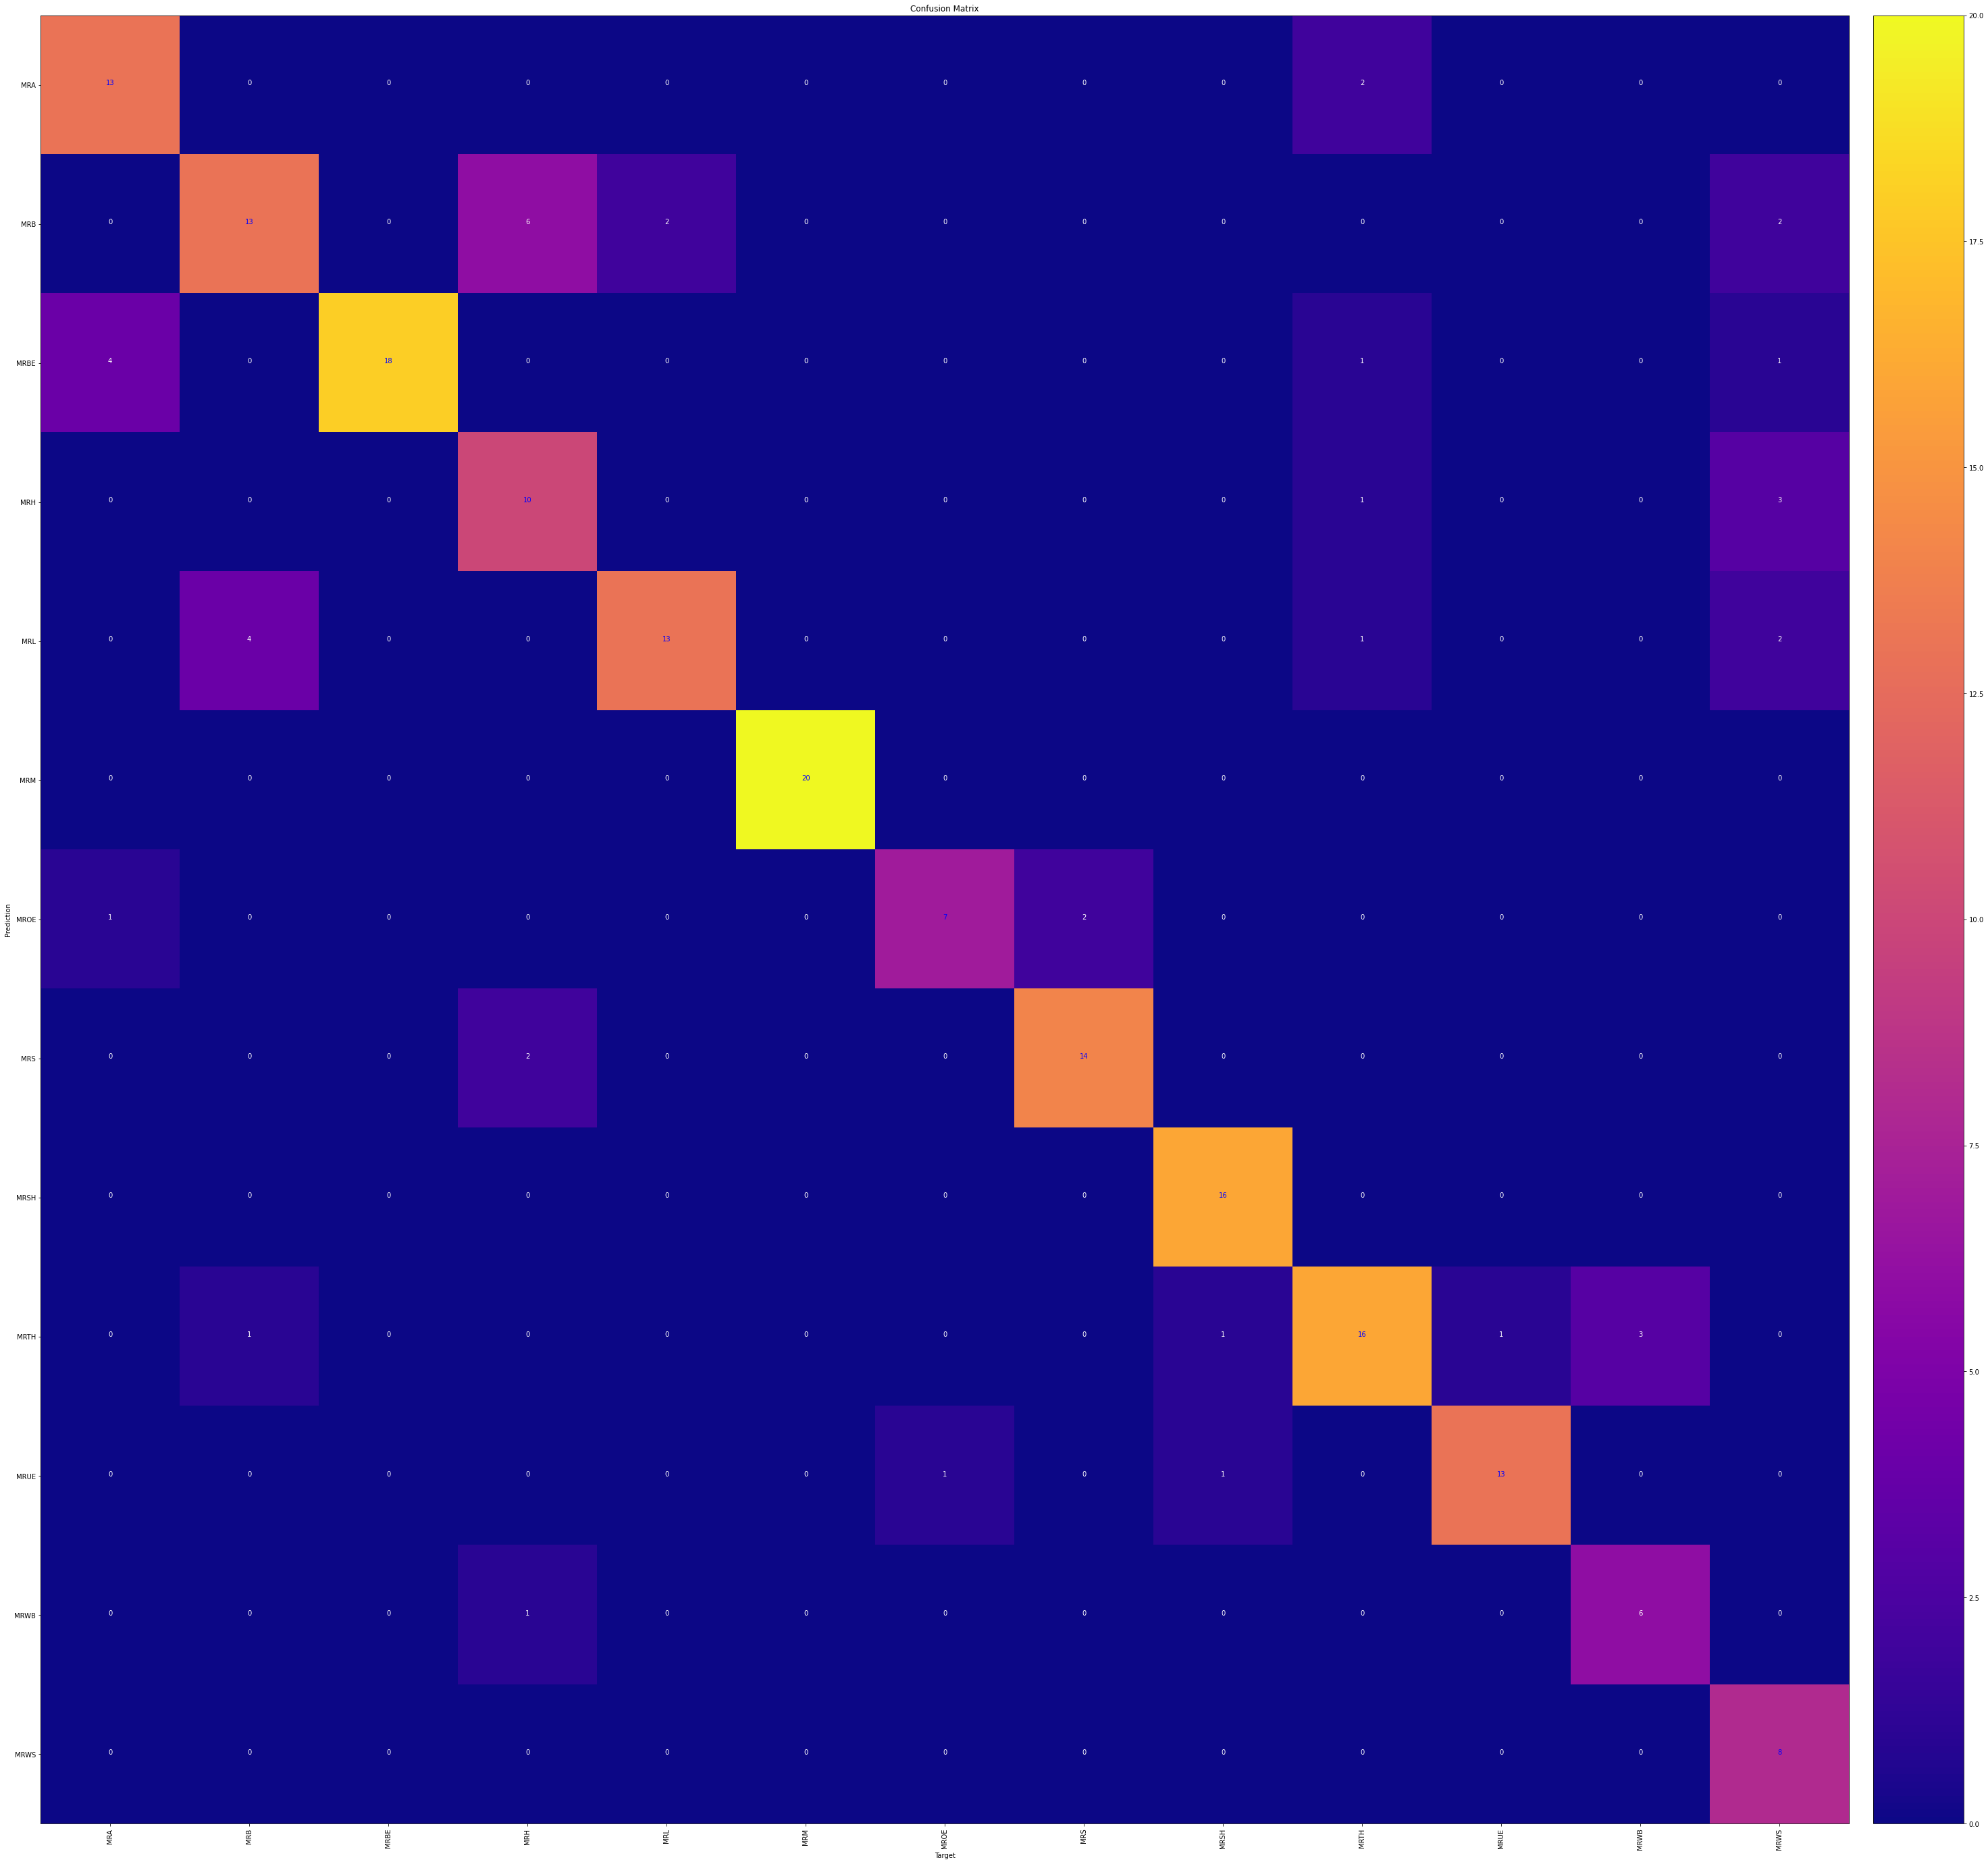

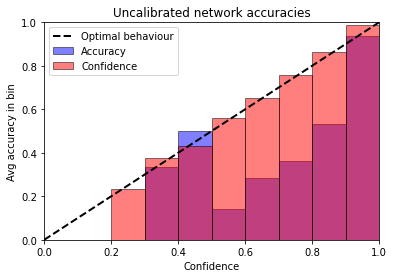

Optimal temperature: 1.836
After temperature - NLL: 0.747, ECE: 0.030


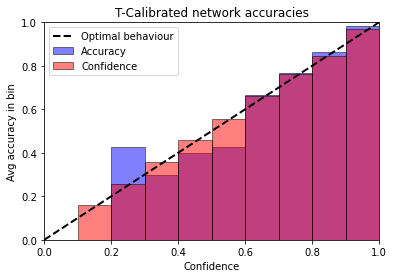

Temperature: T= 1.8361406326293945
n_classes:  13
Loss:0.67716292107791,Accuracy:79.52380952380952%


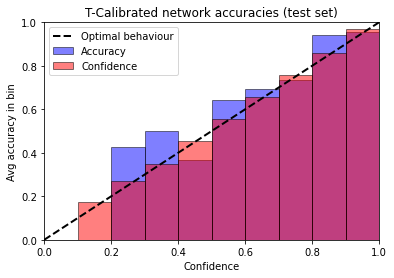

Epoch:0, Batch ID:1, Loss:2.565126657485962
Epoch:0, Batch ID:2, Loss:2.6089627742767334
Epoch:0, Batch ID:3, Loss:2.579745054244995
Epoch:0, Batch ID:4, Loss:2.4236397743225098
Epoch:0, Batch ID:5, Loss:2.5257465839385986
Epoch:0, Batch ID:6, Loss:2.540493965148926
Epoch:0, Batch ID:7, Loss:2.4187843799591064
Epoch:0, Batch ID:8, Loss:2.276792287826538
Epoch:0, Batch ID:9, Loss:2.349684238433838
Epoch:0, Batch ID:10, Loss:2.1103127002716064
Epoch:0, Batch ID:11, Loss:2.154083490371704
Epoch:0, Batch ID:12, Loss:1.949924349784851
Epoch:0, Batch ID:13, Loss:2.0342445373535156
Epoch:0, Batch ID:14, Loss:2.0648930072784424
Epoch:0, Batch ID:15, Loss:1.8631443977355957
Epoch:0, Batch ID:16, Loss:2.117178201675415
Epoch:0, Batch ID:17, Loss:2.224912643432617
Epoch:0, Batch ID:18, Loss:1.9508614540100098
Epoch:0, Batch ID:19, Loss:2.057070016860962
Epoch:0, Batch ID:20, Loss:1.9051870107650757
Epoch:0, Batch ID:21, Loss:2.1243064403533936
Epoch:0, Batch ID:22, Loss:2.144487142562866
Epoch:0,

Epoch:2, Batch ID:41, Loss:1.2959407567977905
Epoch:2, Batch ID:42, Loss:1.1803582906723022
Epoch:2, Batch ID:43, Loss:0.9381030201911926
Epoch:2, Batch ID:44, Loss:0.8858704566955566
Epoch:2, Batch ID:45, Loss:0.8629093170166016
Epoch:2, Batch ID:46, Loss:1.0646135807037354
Epoch:2, Batch ID:47, Loss:1.0262879133224487
Epoch:2, Batch ID:48, Loss:0.7626838684082031
Epoch:2, Batch ID:49, Loss:0.7933782935142517
Epoch:2, Batch ID:50, Loss:0.9358077645301819
Epoch:2, Batch ID:51, Loss:0.9349985122680664
Epoch:2, Batch ID:52, Loss:0.5922690629959106
Epoch:2, Batch ID:53, Loss:0.8334739804267883
Epoch:2, Batch ID:54, Loss:0.9997754693031311
Epoch:2, Batch ID:55, Loss:0.6737346649169922
Epoch:2, Batch ID:56, Loss:0.7816371917724609
Epoch:2, Batch ID:57, Loss:0.9619398713111877
Epoch:2, Batch ID:58, Loss:0.9483258128166199
Epoch:2, Batch ID:59, Loss:0.6883318424224854
Epoch:2, Batch ID:60, Loss:0.7998784184455872
Epoch:2, Batch ID:61, Loss:0.779451847076416
Epoch:2, Batch ID:62, Loss:1.110354

Epoch:5, Batch ID:11, Loss:0.476815789937973
Epoch:5, Batch ID:12, Loss:0.6872655749320984
Epoch:5, Batch ID:13, Loss:0.8395316004753113
Epoch:5, Batch ID:14, Loss:0.8226061463356018
Epoch:5, Batch ID:15, Loss:0.5559095740318298
Epoch:5, Batch ID:16, Loss:0.6428597569465637
Epoch:5, Batch ID:17, Loss:0.7128105759620667
Epoch:5, Batch ID:18, Loss:0.650668203830719
Epoch:5, Batch ID:19, Loss:0.607572615146637
Epoch:5, Batch ID:20, Loss:0.6943294405937195
Epoch:5, Batch ID:21, Loss:0.41951000690460205
Epoch:5, Batch ID:22, Loss:0.6540366411209106
Epoch:5, Batch ID:23, Loss:0.7683942914009094
Epoch:5, Batch ID:24, Loss:0.6556276082992554
Epoch:5, Batch ID:25, Loss:0.6391527056694031
Epoch:5, Batch ID:26, Loss:0.2759709656238556
Epoch:5, Batch ID:27, Loss:0.8656372427940369
Epoch:5, Batch ID:28, Loss:0.5424534678459167
Epoch:5, Batch ID:29, Loss:0.762251079082489
Epoch:5, Batch ID:30, Loss:0.7427494525909424
Epoch:5, Batch ID:31, Loss:0.7518404126167297
Epoch:5, Batch ID:32, Loss:0.40597870

Epoch:7, Batch ID:47, Loss:0.35857924818992615
Epoch:7, Batch ID:48, Loss:0.385944128036499
Epoch:7, Batch ID:49, Loss:0.3109392821788788
Epoch:7, Batch ID:50, Loss:0.14859096705913544
Epoch:7, Batch ID:51, Loss:0.2749159634113312
Epoch:7, Batch ID:52, Loss:0.13883733749389648
Epoch:7, Batch ID:53, Loss:0.22807295620441437
Epoch:7, Batch ID:54, Loss:0.3562498390674591
Epoch:7, Batch ID:55, Loss:0.2899121344089508
Epoch:7, Batch ID:56, Loss:0.4944285452365875
Epoch:7, Batch ID:57, Loss:0.21320027112960815
Epoch:7, Batch ID:58, Loss:0.4436306953430176
Epoch:7, Batch ID:59, Loss:0.32370027899742126
Epoch:7, Batch ID:60, Loss:0.4469456672668457
Epoch:7, Batch ID:61, Loss:0.48829665780067444
Epoch:7, Batch ID:62, Loss:0.39676633477211
Epoch:7, Batch ID:63, Loss:0.5324063897132874
Epoch:7, Batch ID:64, Loss:0.3833041489124298
Epoch:7, Batch ID:65, Loss:0.5907373428344727
Epoch:7, Batch ID:66, Loss:0.34552231431007385
Epoch:7, Batch ID:67, Loss:0.6170013546943665
Epoch:7, Batch ID:68, Loss:0.

Epoch:10, Batch ID:8, Loss:0.9465013146400452
Epoch:10, Batch ID:9, Loss:0.39560553431510925
Epoch:10, Batch ID:10, Loss:0.11060675233602524
Epoch:10, Batch ID:11, Loss:0.29299604892730713
Epoch:10, Batch ID:12, Loss:0.12412745505571365
Epoch:10, Batch ID:13, Loss:0.36955180764198303
Epoch:10, Batch ID:14, Loss:0.20149977505207062
Epoch:10, Batch ID:15, Loss:0.6726805567741394
Epoch:10, Batch ID:16, Loss:0.6941305994987488
Epoch:10, Batch ID:17, Loss:0.45781466364860535
Epoch:10, Batch ID:18, Loss:0.39458200335502625
Epoch:10, Batch ID:19, Loss:0.3035174012184143
Epoch:10, Batch ID:20, Loss:0.33068615198135376
Epoch:10, Batch ID:21, Loss:0.459717720746994
Epoch:10, Batch ID:22, Loss:0.19570429623126984
Epoch:10, Batch ID:23, Loss:0.3508460819721222
Epoch:10, Batch ID:24, Loss:0.16538895666599274
Epoch:10, Batch ID:25, Loss:0.3484914004802704
Epoch:10, Batch ID:26, Loss:0.1898629069328308
Epoch:10, Batch ID:27, Loss:0.4004760980606079
Epoch:10, Batch ID:28, Loss:0.3126995265483856
Epoch

Epoch:12, Batch ID:36, Loss:0.08912253379821777
Epoch:12, Batch ID:37, Loss:0.29027292132377625
Epoch:12, Batch ID:38, Loss:0.13397608697414398
Epoch:12, Batch ID:39, Loss:0.14870154857635498
Epoch:12, Batch ID:40, Loss:0.1427464485168457
Epoch:12, Batch ID:41, Loss:0.11775722354650497
Epoch:12, Batch ID:42, Loss:0.2359655648469925
Epoch:12, Batch ID:43, Loss:0.13208885490894318
Epoch:12, Batch ID:44, Loss:0.14239434897899628
Epoch:12, Batch ID:45, Loss:0.4088687002658844
Epoch:12, Batch ID:46, Loss:0.16543905436992645
Epoch:12, Batch ID:47, Loss:0.2108253389596939
Epoch:12, Batch ID:48, Loss:0.1342230588197708
Epoch:12, Batch ID:49, Loss:0.17978878319263458
Epoch:12, Batch ID:50, Loss:0.09553448110818863
Epoch:12, Batch ID:51, Loss:0.1858491152524948
Epoch:12, Batch ID:52, Loss:0.10540583729743958
Epoch:12, Batch ID:53, Loss:0.12560488283634186
Epoch:12, Batch ID:54, Loss:0.041003648191690445
Epoch:12, Batch ID:55, Loss:0.25849929451942444
Epoch:12, Batch ID:56, Loss:0.206809520721435

Epoch:14, Batch ID:64, Loss:0.36303356289863586
Epoch:14, Batch ID:65, Loss:0.10944307595491409
Epoch:14, Batch ID:66, Loss:0.26530835032463074
Epoch:14, Batch ID:67, Loss:0.19565121829509735
Epoch:14, Batch ID:68, Loss:0.12982334196567535
Epoch:14, Batch ID:69, Loss:0.04207045957446098
Epoch:14, Batch ID:70, Loss:0.06275853514671326
Recent average training loss: 0.24176526148344432
Current average training loss: 0.22103641260887535
Continuing training.
Epoch:15, Batch ID:1, Loss:0.16265271604061127
Epoch:15, Batch ID:2, Loss:0.23811955749988556
Epoch:15, Batch ID:3, Loss:0.16971534490585327
Epoch:15, Batch ID:4, Loss:0.11384940892457962
Epoch:15, Batch ID:5, Loss:0.11714646965265274
Epoch:15, Batch ID:6, Loss:0.19699090719223022
Epoch:15, Batch ID:7, Loss:0.15864995121955872
Epoch:15, Batch ID:8, Loss:0.0677032396197319
Epoch:15, Batch ID:9, Loss:0.2765730321407318
Epoch:15, Batch ID:10, Loss:0.18563063442707062
Epoch:15, Batch ID:11, Loss:0.4029107987880707
Epoch:15, Batch ID:12, Los

Epoch:17, Batch ID:19, Loss:0.3635883629322052
Epoch:17, Batch ID:20, Loss:0.1984843760728836
Epoch:17, Batch ID:21, Loss:0.08057593554258347
Epoch:17, Batch ID:22, Loss:0.09302359819412231
Epoch:17, Batch ID:23, Loss:0.3602384626865387
Epoch:17, Batch ID:24, Loss:0.16403871774673462
Epoch:17, Batch ID:25, Loss:0.16944700479507446
Epoch:17, Batch ID:26, Loss:0.024124177172780037
Epoch:17, Batch ID:27, Loss:0.3121192157268524
Epoch:17, Batch ID:28, Loss:0.053871914744377136
Epoch:17, Batch ID:29, Loss:0.11468947678804398
Epoch:17, Batch ID:30, Loss:0.10767391324043274
Epoch:17, Batch ID:31, Loss:0.40381932258605957
Epoch:17, Batch ID:32, Loss:0.16067765653133392
Epoch:17, Batch ID:33, Loss:0.02411448396742344
Epoch:17, Batch ID:34, Loss:0.00990269985049963
Epoch:17, Batch ID:35, Loss:0.01582176983356476
Epoch:17, Batch ID:36, Loss:0.19798140227794647
Epoch:17, Batch ID:37, Loss:0.04798826947808266
Epoch:17, Batch ID:38, Loss:0.17309026420116425
Epoch:17, Batch ID:39, Loss:0.056260764598

Epoch:19, Batch ID:46, Loss:0.05860386788845062
Epoch:19, Batch ID:47, Loss:0.09047583490610123
Epoch:19, Batch ID:48, Loss:0.0842503011226654
Epoch:19, Batch ID:49, Loss:0.09206459671258926
Epoch:19, Batch ID:50, Loss:0.09536970406770706
Epoch:19, Batch ID:51, Loss:0.026196537539362907
Epoch:19, Batch ID:52, Loss:0.11699878424406052
Epoch:19, Batch ID:53, Loss:0.21072940528392792
Epoch:19, Batch ID:54, Loss:0.16664129495620728
Epoch:19, Batch ID:55, Loss:0.10930407047271729
Epoch:19, Batch ID:56, Loss:0.08752775192260742
Epoch:19, Batch ID:57, Loss:0.04230154678225517
Epoch:19, Batch ID:58, Loss:0.05784134566783905
Epoch:19, Batch ID:59, Loss:0.08181565254926682
Epoch:19, Batch ID:60, Loss:0.30889829993247986
Epoch:19, Batch ID:61, Loss:0.07329962402582169
Epoch:19, Batch ID:62, Loss:0.14049173891544342
Epoch:19, Batch ID:63, Loss:0.17118345201015472
Epoch:19, Batch ID:64, Loss:0.16547244787216187
Epoch:19, Batch ID:65, Loss:0.05880970135331154
Epoch:19, Batch ID:66, Loss:0.1327360421

Epoch:22, Batch ID:1, Loss:0.11974682658910751
Epoch:22, Batch ID:2, Loss:0.2590254843235016
Epoch:22, Batch ID:3, Loss:0.1871970295906067
Epoch:22, Batch ID:4, Loss:0.2819720208644867
Epoch:22, Batch ID:5, Loss:0.29630178213119507
Epoch:22, Batch ID:6, Loss:0.07174357771873474
Epoch:22, Batch ID:7, Loss:0.05482814833521843
Epoch:22, Batch ID:8, Loss:0.05938602611422539
Epoch:22, Batch ID:9, Loss:0.13475890457630157
Epoch:22, Batch ID:10, Loss:0.03981569781899452
Epoch:22, Batch ID:11, Loss:0.03679695725440979
Epoch:22, Batch ID:12, Loss:0.13152894377708435
Epoch:22, Batch ID:13, Loss:0.04570157453417778
Epoch:22, Batch ID:14, Loss:0.023818276822566986
Epoch:22, Batch ID:15, Loss:0.2715568244457245
Epoch:22, Batch ID:16, Loss:0.0246144849807024
Epoch:22, Batch ID:17, Loss:0.09540900588035583
Epoch:22, Batch ID:18, Loss:0.046553730964660645
Epoch:22, Batch ID:19, Loss:0.5097172260284424
Epoch:22, Batch ID:20, Loss:0.18739140033721924
Epoch:22, Batch ID:21, Loss:0.11414851993322372
Epoch

Epoch:24, Batch ID:28, Loss:0.06782086193561554
Epoch:24, Batch ID:29, Loss:0.20035916566848755
Epoch:24, Batch ID:30, Loss:0.29397082328796387
Epoch:24, Batch ID:31, Loss:0.16760693490505219
Epoch:24, Batch ID:32, Loss:0.068572036921978
Epoch:24, Batch ID:33, Loss:0.04777389392256737
Epoch:24, Batch ID:34, Loss:0.26090309023857117
Epoch:24, Batch ID:35, Loss:0.14008934795856476
Epoch:24, Batch ID:36, Loss:0.05874320864677429
Epoch:24, Batch ID:37, Loss:0.21263468265533447
Epoch:24, Batch ID:38, Loss:0.06478040665388107
Epoch:24, Batch ID:39, Loss:0.11136385798454285
Epoch:24, Batch ID:40, Loss:0.059034835547208786
Epoch:24, Batch ID:41, Loss:0.03908192366361618
Epoch:24, Batch ID:42, Loss:0.0664835050702095
Epoch:24, Batch ID:43, Loss:0.09203607589006424
Epoch:24, Batch ID:44, Loss:0.11465677618980408
Epoch:24, Batch ID:45, Loss:0.23842370510101318
Epoch:24, Batch ID:46, Loss:0.14188142120838165
Epoch:24, Batch ID:47, Loss:0.0745389461517334
Epoch:24, Batch ID:48, Loss:0.0564583539962

Epoch:26, Batch ID:54, Loss:0.08884388953447342
Epoch:26, Batch ID:55, Loss:0.011261164210736752
Epoch:26, Batch ID:56, Loss:0.19732648134231567
Epoch:26, Batch ID:57, Loss:0.15309377014636993
Epoch:26, Batch ID:58, Loss:0.044475045055150986
Epoch:26, Batch ID:59, Loss:0.13391868770122528
Epoch:26, Batch ID:60, Loss:0.03398465737700462
Epoch:26, Batch ID:61, Loss:0.18660640716552734
Epoch:26, Batch ID:62, Loss:0.0496659092605114
Epoch:26, Batch ID:63, Loss:0.027562176808714867
Epoch:26, Batch ID:64, Loss:0.30247849225997925
Epoch:26, Batch ID:65, Loss:0.03455256298184395
Epoch:26, Batch ID:66, Loss:0.11713701486587524
Epoch:26, Batch ID:67, Loss:0.11946531385183334
Epoch:26, Batch ID:68, Loss:0.033153533935546875
Epoch:26, Batch ID:69, Loss:0.05693821609020233
Epoch:26, Batch ID:70, Loss:0.03585164248943329
Recent average training loss: 0.11475254167002483
Current average training loss: 0.10989891183759337
Continuing training.
Epoch:27, Batch ID:1, Loss:0.13540248572826385
Epoch:27, Ba

Epoch:29, Batch ID:8, Loss:0.10332026332616806
Epoch:29, Batch ID:9, Loss:0.16731040179729462
Epoch:29, Batch ID:10, Loss:0.11936988681554794
Epoch:29, Batch ID:11, Loss:0.13494277000427246
Epoch:29, Batch ID:12, Loss:0.03539932891726494
Epoch:29, Batch ID:13, Loss:0.2852778732776642
Epoch:29, Batch ID:14, Loss:0.28602197766304016
Epoch:29, Batch ID:15, Loss:0.02462180145084858
Epoch:29, Batch ID:16, Loss:0.25209328532218933
Epoch:29, Batch ID:17, Loss:0.09685009717941284
Epoch:29, Batch ID:18, Loss:0.22869499027729034
Epoch:29, Batch ID:19, Loss:0.1330949068069458
Epoch:29, Batch ID:20, Loss:0.09566366672515869
Epoch:29, Batch ID:21, Loss:0.2504573166370392
Epoch:29, Batch ID:22, Loss:0.029459066689014435
Epoch:29, Batch ID:23, Loss:0.11037600040435791
Epoch:29, Batch ID:24, Loss:0.050782591104507446
Epoch:29, Batch ID:25, Loss:0.21913419663906097
Epoch:29, Batch ID:26, Loss:0.008894319646060467
Epoch:29, Batch ID:27, Loss:0.1900593787431717
Epoch:29, Batch ID:28, Loss:0.0468537919223

Epoch:31, Batch ID:34, Loss:0.015094718895852566
Epoch:31, Batch ID:35, Loss:0.026654526591300964
Epoch:31, Batch ID:36, Loss:0.08039997518062592
Epoch:31, Batch ID:37, Loss:0.040252525359392166
Epoch:31, Batch ID:38, Loss:0.21604211628437042
Epoch:31, Batch ID:39, Loss:0.027719682082533836
Epoch:31, Batch ID:40, Loss:0.10212957113981247
Epoch:31, Batch ID:41, Loss:0.11558271199464798
Epoch:31, Batch ID:42, Loss:0.06466866284608841
Epoch:31, Batch ID:43, Loss:0.18352174758911133
Epoch:31, Batch ID:44, Loss:0.2560015022754669
Epoch:31, Batch ID:45, Loss:0.10071450471878052
Epoch:31, Batch ID:46, Loss:0.07249819487333298
Epoch:31, Batch ID:47, Loss:0.04579578712582588
Epoch:31, Batch ID:48, Loss:0.08218497037887573
Epoch:31, Batch ID:49, Loss:0.02723328210413456
Epoch:31, Batch ID:50, Loss:0.04154900833964348
Epoch:31, Batch ID:51, Loss:0.014590245671570301
Epoch:31, Batch ID:52, Loss:0.05384078994393349
Epoch:31, Batch ID:53, Loss:0.12014328688383102
Epoch:31, Batch ID:54, Loss:0.010891

Epoch:33, Batch ID:60, Loss:0.012518681585788727
Epoch:33, Batch ID:61, Loss:0.008435836993157864
Epoch:33, Batch ID:62, Loss:0.25105181336402893
Epoch:33, Batch ID:63, Loss:0.14130891859531403
Epoch:33, Batch ID:64, Loss:0.01174080464988947
Epoch:33, Batch ID:65, Loss:0.11352088302373886
Epoch:33, Batch ID:66, Loss:0.022513477131724358
Epoch:33, Batch ID:67, Loss:0.12543363869190216
Epoch:33, Batch ID:68, Loss:0.036862801760435104
Epoch:33, Batch ID:69, Loss:0.006810115650296211
Epoch:33, Batch ID:70, Loss:0.04178572818636894
Recent average training loss: 0.09377174853989986
Current average training loss: 0.09413735388423985
Continuing training.
Epoch:34, Batch ID:1, Loss:0.07332663983106613
Epoch:34, Batch ID:2, Loss:0.21683377027511597
Epoch:34, Batch ID:3, Loss:0.07696989178657532
Epoch:34, Batch ID:4, Loss:0.062011320143938065
Epoch:34, Batch ID:5, Loss:0.10801690071821213
Epoch:34, Batch ID:6, Loss:0.06908869743347168
Epoch:34, Batch ID:7, Loss:0.08403578400611877
Epoch:34, Batch

Epoch:36, Batch ID:13, Loss:0.07028374820947647
Epoch:36, Batch ID:14, Loss:0.025156697258353233
Epoch:36, Batch ID:15, Loss:0.03850063309073448
Epoch:36, Batch ID:16, Loss:0.0577874630689621
Epoch:36, Batch ID:17, Loss:0.1675955206155777
Epoch:36, Batch ID:18, Loss:0.018422773107886314
Epoch:36, Batch ID:19, Loss:0.11194328218698502
Epoch:36, Batch ID:20, Loss:0.3022809326648712
Epoch:36, Batch ID:21, Loss:0.06363873183727264
Epoch:36, Batch ID:22, Loss:0.013139980845153332
Epoch:36, Batch ID:23, Loss:0.12485876679420471
Epoch:36, Batch ID:24, Loss:0.05762287601828575
Epoch:36, Batch ID:25, Loss:0.07622901350259781
Epoch:36, Batch ID:26, Loss:0.14524266123771667
Epoch:36, Batch ID:27, Loss:0.11190471798181534
Epoch:36, Batch ID:28, Loss:0.01931011490523815
Epoch:36, Batch ID:29, Loss:0.08181177824735641
Epoch:36, Batch ID:30, Loss:0.01561692263931036
Epoch:36, Batch ID:31, Loss:0.15461547672748566
Epoch:36, Batch ID:32, Loss:0.13590873777866364
Epoch:36, Batch ID:33, Loss:0.0186165887

Epoch:38, Batch ID:39, Loss:0.03975246474146843
Epoch:38, Batch ID:40, Loss:0.019128959625959396
Epoch:38, Batch ID:41, Loss:0.049253910779953
Epoch:38, Batch ID:42, Loss:0.044131916016340256
Epoch:38, Batch ID:43, Loss:0.08716991543769836
Epoch:38, Batch ID:44, Loss:0.01670747809112072
Epoch:38, Batch ID:45, Loss:0.039951007813215256
Epoch:38, Batch ID:46, Loss:0.11515524238348007
Epoch:38, Batch ID:47, Loss:0.08975439518690109
Epoch:38, Batch ID:48, Loss:0.08102444559335709
Epoch:38, Batch ID:49, Loss:0.1048593744635582
Epoch:38, Batch ID:50, Loss:0.08207205682992935
Epoch:38, Batch ID:51, Loss:0.09103427082300186
Epoch:38, Batch ID:52, Loss:0.03972673788666725
Epoch:38, Batch ID:53, Loss:0.006932571996003389
Epoch:38, Batch ID:54, Loss:0.030957356095314026
Epoch:38, Batch ID:55, Loss:0.012143080122768879
Epoch:38, Batch ID:56, Loss:0.0421321727335453
Epoch:38, Batch ID:57, Loss:0.004093917086720467
Epoch:38, Batch ID:58, Loss:0.03390536829829216
Epoch:38, Batch ID:59, Loss:0.1194528

Epoch:40, Batch ID:64, Loss:0.023335613310337067
Epoch:40, Batch ID:65, Loss:0.03883017227053642
Epoch:40, Batch ID:66, Loss:0.006884116213768721
Epoch:40, Batch ID:67, Loss:0.019333556294441223
Epoch:40, Batch ID:68, Loss:0.01777612790465355
Epoch:40, Batch ID:69, Loss:0.0035309698432683945
Epoch:40, Batch ID:70, Loss:0.010584179311990738
Recent average training loss: 0.07412732744550096
Current average training loss: 0.07303664503868301
Continuing training.
Epoch:41, Batch ID:1, Loss:0.1891658455133438
Epoch:41, Batch ID:2, Loss:0.032524172216653824
Epoch:41, Batch ID:3, Loss:0.141724094748497
Epoch:41, Batch ID:4, Loss:0.0437529981136322
Epoch:41, Batch ID:5, Loss:0.013970296829938889
Epoch:41, Batch ID:6, Loss:0.13095661997795105
Epoch:41, Batch ID:7, Loss:0.04560517147183418
Epoch:41, Batch ID:8, Loss:0.03824499249458313
Epoch:41, Batch ID:9, Loss:0.10001775622367859
Epoch:41, Batch ID:10, Loss:0.07150892168283463
Epoch:41, Batch ID:11, Loss:0.11346945911645889
Epoch:41, Batch ID:

Epoch:43, Batch ID:18, Loss:0.05640874430537224
Epoch:43, Batch ID:19, Loss:0.04656103625893593
Epoch:43, Batch ID:20, Loss:0.03835861757397652
Epoch:43, Batch ID:21, Loss:0.029691634699702263
Epoch:43, Batch ID:22, Loss:0.1512678563594818
Epoch:43, Batch ID:23, Loss:0.1585308015346527
Epoch:43, Batch ID:24, Loss:0.11144992709159851
Epoch:43, Batch ID:25, Loss:0.058368753641843796
Epoch:43, Batch ID:26, Loss:0.0648730918765068
Epoch:43, Batch ID:27, Loss:0.043910812586545944
Epoch:43, Batch ID:28, Loss:0.040895164012908936
Epoch:43, Batch ID:29, Loss:0.009522288106381893
Epoch:43, Batch ID:30, Loss:0.03271952643990517
Epoch:43, Batch ID:31, Loss:0.08009461313486099
Epoch:43, Batch ID:32, Loss:0.03793725743889809
Epoch:43, Batch ID:33, Loss:0.0042405081912875175
Epoch:43, Batch ID:34, Loss:0.010898414999246597
Epoch:43, Batch ID:35, Loss:0.05724600329995155
Epoch:43, Batch ID:36, Loss:0.048218388110399246
Epoch:43, Batch ID:37, Loss:0.02809979021549225
Epoch:43, Batch ID:38, Loss:0.0281

Epoch:45, Batch ID:43, Loss:0.05572973191738129
Epoch:45, Batch ID:44, Loss:0.006810713093727827
Epoch:45, Batch ID:45, Loss:0.02472536824643612
Epoch:45, Batch ID:46, Loss:0.03073219768702984
Epoch:45, Batch ID:47, Loss:0.010589358396828175
Epoch:45, Batch ID:48, Loss:0.1564674973487854
Epoch:45, Batch ID:49, Loss:0.055566925555467606
Epoch:45, Batch ID:50, Loss:0.0012315193889662623
Epoch:45, Batch ID:51, Loss:0.05391402915120125
Epoch:45, Batch ID:52, Loss:0.011960090138018131
Epoch:45, Batch ID:53, Loss:0.004663599189370871
Epoch:45, Batch ID:54, Loss:0.05176601931452751
Epoch:45, Batch ID:55, Loss:0.0033669371623545885
Epoch:45, Batch ID:56, Loss:0.012784142978489399
Epoch:45, Batch ID:57, Loss:0.009250556118786335
Epoch:45, Batch ID:58, Loss:0.035609323531389236
Epoch:45, Batch ID:59, Loss:0.1210908591747284
Epoch:45, Batch ID:60, Loss:0.06281096488237381
Epoch:45, Batch ID:61, Loss:0.09467685222625732
Epoch:45, Batch ID:62, Loss:0.01177134644240141
Epoch:45, Batch ID:63, Loss:0.

Epoch:47, Batch ID:68, Loss:0.1812482327222824
Epoch:47, Batch ID:69, Loss:0.04267511144280434
Epoch:47, Batch ID:70, Loss:0.23478709161281586
Recent average training loss: 0.06004847960159655
Current average training loss: 0.06060175948914035
Continuing training.
Epoch:48, Batch ID:1, Loss:0.032855238765478134
Epoch:48, Batch ID:2, Loss:0.22896695137023926
Epoch:48, Batch ID:3, Loss:0.052205268293619156
Epoch:48, Batch ID:4, Loss:0.04308297857642174
Epoch:48, Batch ID:5, Loss:0.05593758448958397
Epoch:48, Batch ID:6, Loss:0.06562494486570358
Epoch:48, Batch ID:7, Loss:0.02874292992055416
Epoch:48, Batch ID:8, Loss:0.19494248926639557
Epoch:48, Batch ID:9, Loss:0.07399018853902817
Epoch:48, Batch ID:10, Loss:0.09227254241704941
Epoch:48, Batch ID:11, Loss:0.07814017683267593
Epoch:48, Batch ID:12, Loss:0.05358399078249931
Epoch:48, Batch ID:13, Loss:0.013294018805027008
Epoch:48, Batch ID:14, Loss:0.07954490184783936
Epoch:48, Batch ID:15, Loss:0.08838340640068054
Epoch:48, Batch ID:16

Epoch:50, Batch ID:21, Loss:0.06115144118666649
Epoch:50, Batch ID:22, Loss:0.1814286708831787
Epoch:50, Batch ID:23, Loss:0.018098389729857445
Epoch:50, Batch ID:24, Loss:0.018585123121738434
Epoch:50, Batch ID:25, Loss:0.06817606836557388
Epoch:50, Batch ID:26, Loss:0.004346506204456091
Epoch:50, Batch ID:27, Loss:0.13880841434001923
Epoch:50, Batch ID:28, Loss:0.10976029187440872
Epoch:50, Batch ID:29, Loss:0.15152429044246674
Epoch:50, Batch ID:30, Loss:0.21904356777668
Epoch:50, Batch ID:31, Loss:0.07096691429615021
Epoch:50, Batch ID:32, Loss:0.06084158644080162
Epoch:50, Batch ID:33, Loss:0.007837497629225254
Epoch:50, Batch ID:34, Loss:0.1800410896539688
Epoch:50, Batch ID:35, Loss:0.019108381122350693
Epoch:50, Batch ID:36, Loss:0.0033026321325451136
Epoch:50, Batch ID:37, Loss:0.2945939004421234
Epoch:50, Batch ID:38, Loss:0.028173988685011864
Epoch:50, Batch ID:39, Loss:0.005153569858521223
Epoch:50, Batch ID:40, Loss:0.03492797538638115
Epoch:50, Batch ID:41, Loss:0.0099483

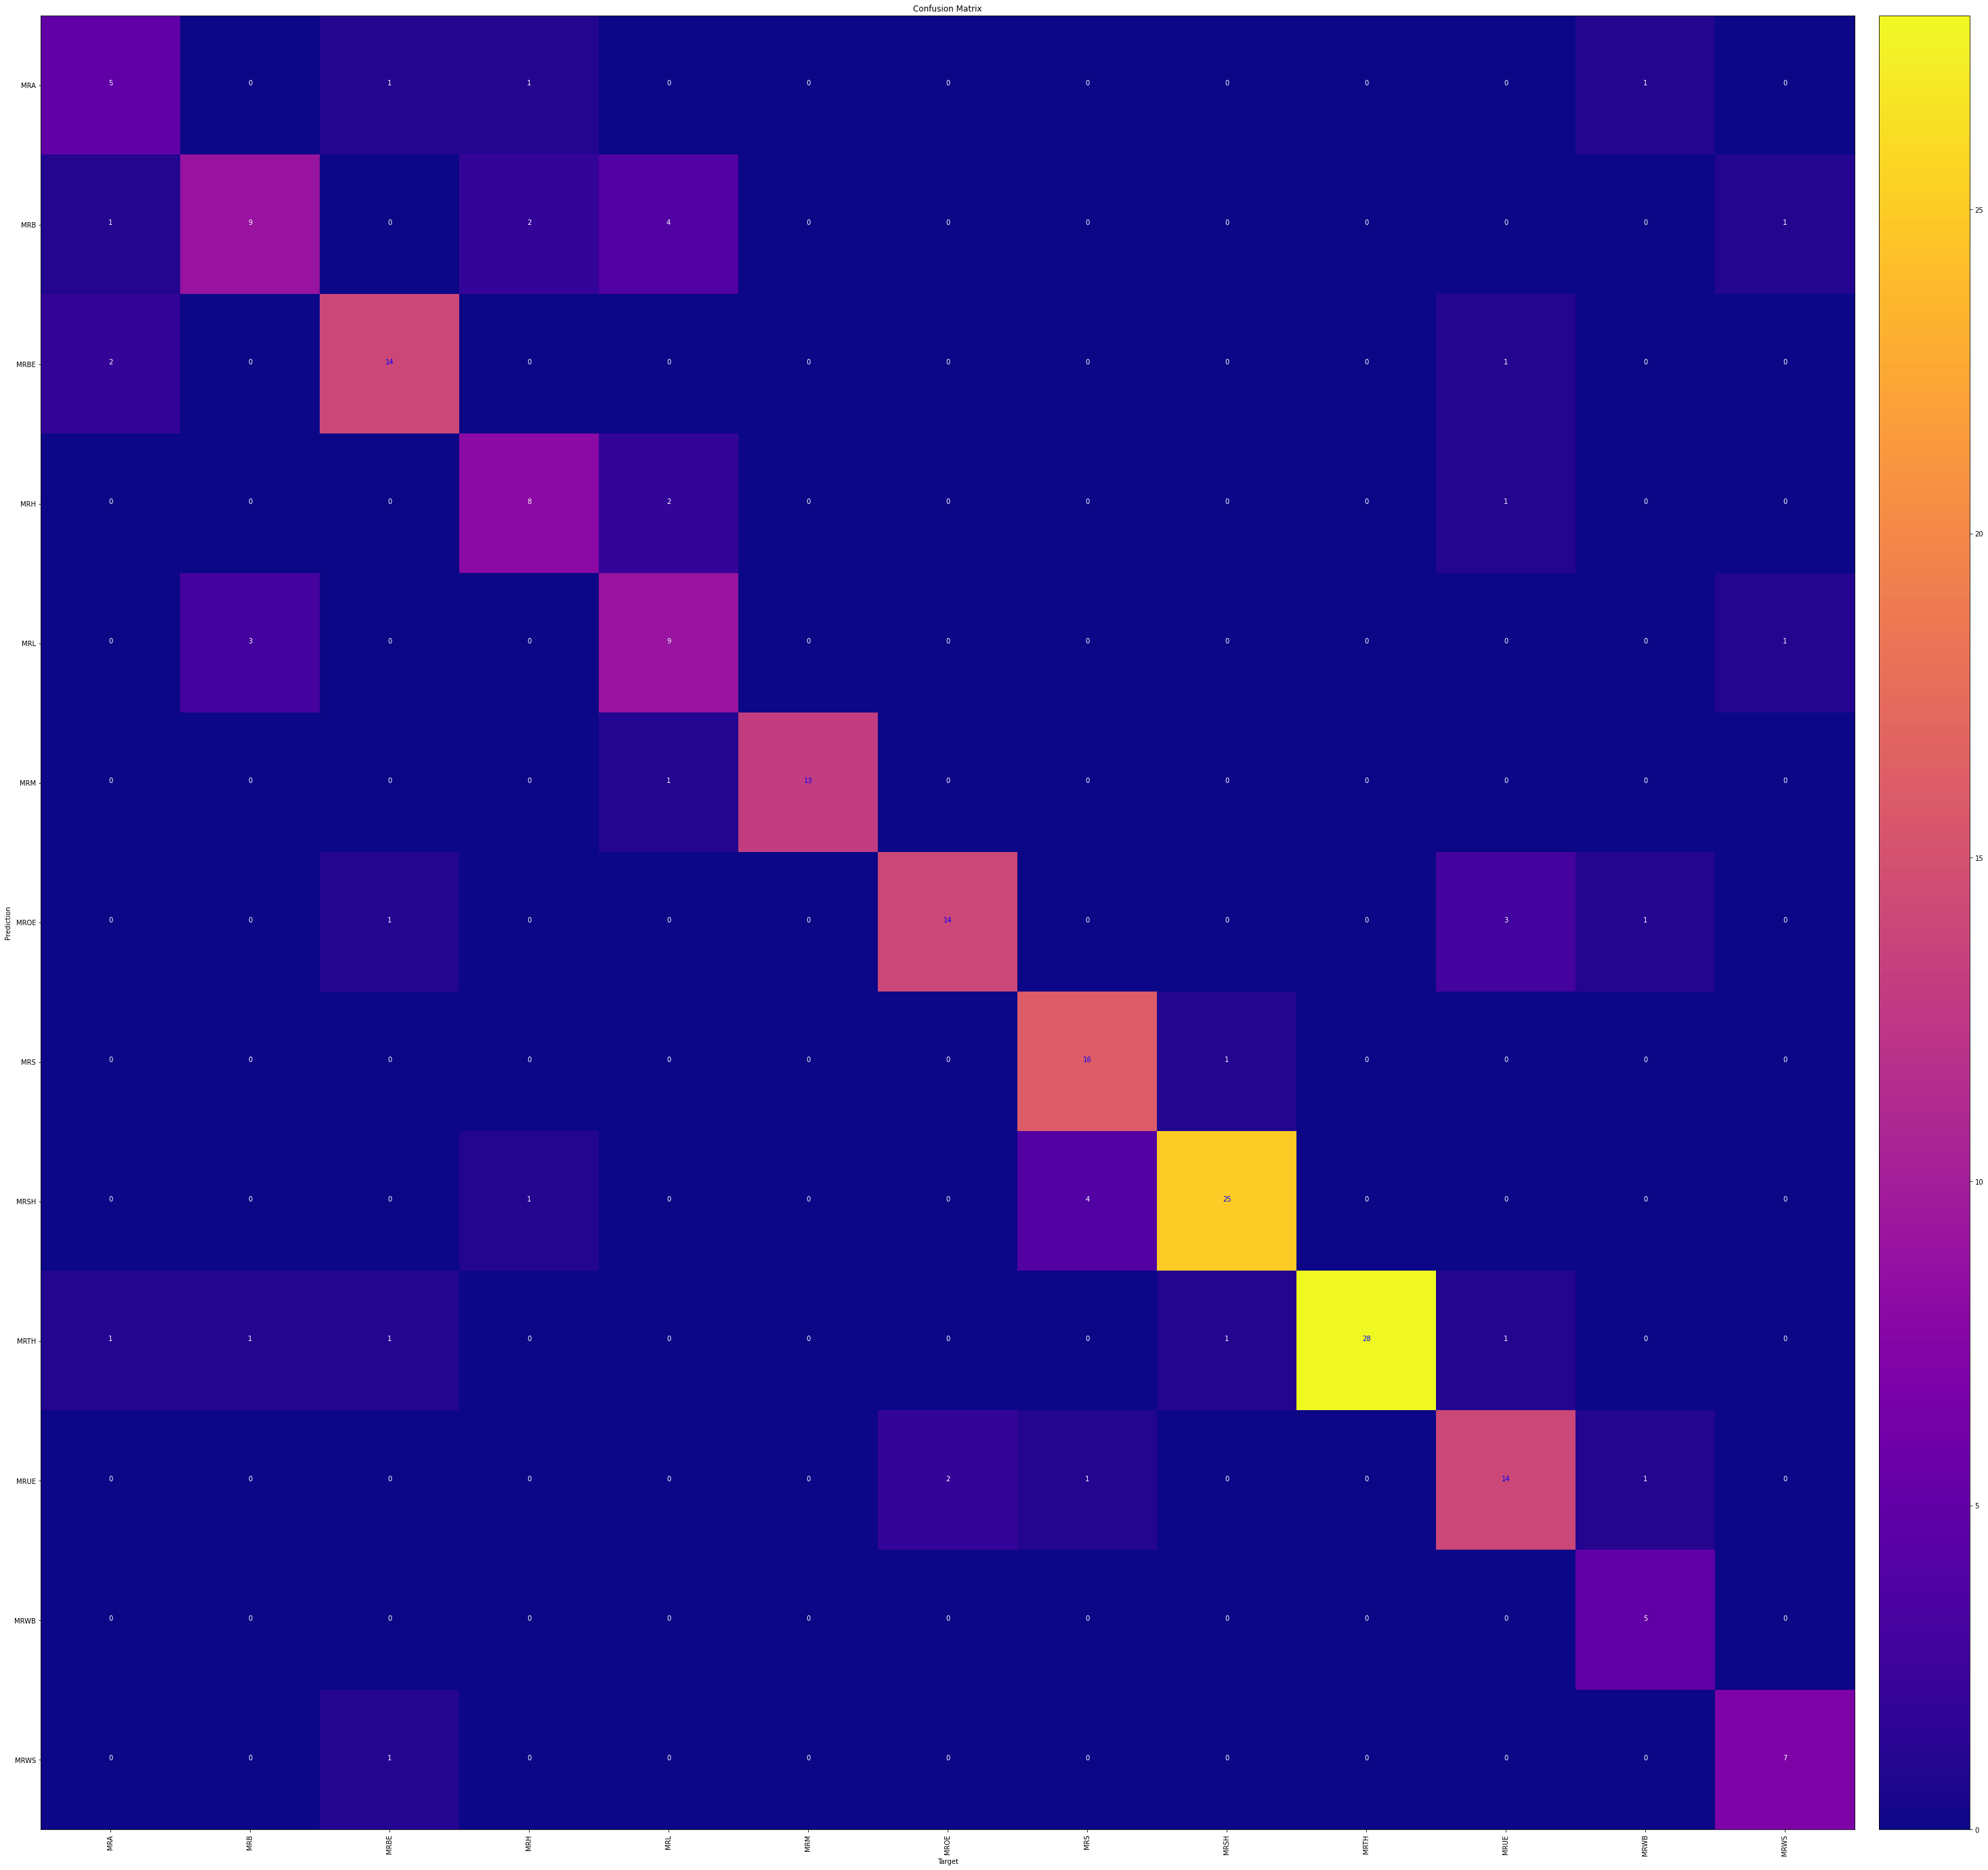

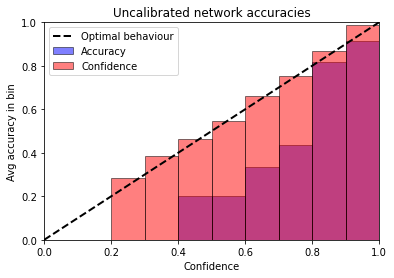

Optimal temperature: 1.876
After temperature - NLL: 0.902, ECE: 0.069


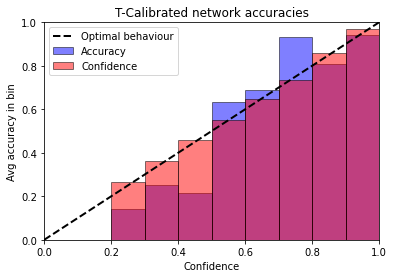

Temperature: T= 1.8763065338134766
n_classes:  13
Loss:0.5343247386748858,Accuracy:84.76190476190476%


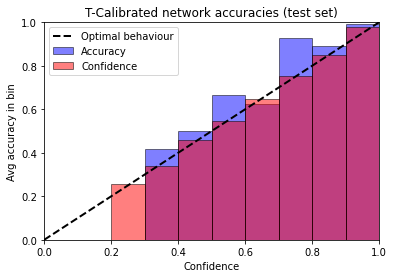

New best model! Accuracy:  84.76190476190476
Epoch:0, Batch ID:1, Loss:2.6229333877563477
Epoch:0, Batch ID:2, Loss:2.542228937149048
Epoch:0, Batch ID:3, Loss:2.37235426902771
Epoch:0, Batch ID:4, Loss:2.477617025375366
Epoch:0, Batch ID:5, Loss:2.457273244857788
Epoch:0, Batch ID:6, Loss:2.4600718021392822
Epoch:0, Batch ID:7, Loss:2.3394744396209717
Epoch:0, Batch ID:8, Loss:2.240771532058716
Epoch:0, Batch ID:9, Loss:2.2121596336364746
Epoch:0, Batch ID:10, Loss:2.1370325088500977
Epoch:0, Batch ID:11, Loss:2.235112190246582
Epoch:0, Batch ID:12, Loss:2.106058120727539
Epoch:0, Batch ID:13, Loss:2.0441155433654785
Epoch:0, Batch ID:14, Loss:2.1461594104766846
Epoch:0, Batch ID:15, Loss:1.9240118265151978
Epoch:0, Batch ID:16, Loss:2.25996732711792
Epoch:0, Batch ID:17, Loss:1.7447786331176758
Epoch:0, Batch ID:18, Loss:1.856240153312683
Epoch:0, Batch ID:19, Loss:1.8033195734024048
Epoch:0, Batch ID:20, Loss:2.157639265060425
Epoch:0, Batch ID:21, Loss:1.7981370687484741
Epoch:0, B

Epoch:2, Batch ID:40, Loss:0.8364340662956238
Epoch:2, Batch ID:41, Loss:0.8938670754432678
Epoch:2, Batch ID:42, Loss:1.1129847764968872
Epoch:2, Batch ID:43, Loss:1.3736673593521118
Epoch:2, Batch ID:44, Loss:0.8880946040153503
Epoch:2, Batch ID:45, Loss:1.0794672966003418
Epoch:2, Batch ID:46, Loss:1.1174001693725586
Epoch:2, Batch ID:47, Loss:0.6998538374900818
Epoch:2, Batch ID:48, Loss:0.8601816296577454
Epoch:2, Batch ID:49, Loss:0.8606652617454529
Epoch:2, Batch ID:50, Loss:0.9248661994934082
Epoch:2, Batch ID:51, Loss:1.260271668434143
Epoch:2, Batch ID:52, Loss:0.37756356596946716
Epoch:2, Batch ID:53, Loss:0.8244969844818115
Epoch:2, Batch ID:54, Loss:1.085253119468689
Epoch:2, Batch ID:55, Loss:0.9515368938446045
Epoch:2, Batch ID:56, Loss:0.7300973534584045
Epoch:2, Batch ID:57, Loss:0.9575238823890686
Epoch:2, Batch ID:58, Loss:0.9264675974845886
Epoch:2, Batch ID:59, Loss:1.0787461996078491
Epoch:2, Batch ID:60, Loss:0.899040937423706
Epoch:2, Batch ID:61, Loss:0.6390059

Epoch:5, Batch ID:10, Loss:0.7966809868812561
Epoch:5, Batch ID:11, Loss:0.6643722653388977
Epoch:5, Batch ID:12, Loss:0.679011881351471
Epoch:5, Batch ID:13, Loss:0.9493503570556641
Epoch:5, Batch ID:14, Loss:0.7003934979438782
Epoch:5, Batch ID:15, Loss:0.6727105975151062
Epoch:5, Batch ID:16, Loss:0.6234186291694641
Epoch:5, Batch ID:17, Loss:0.5235623121261597
Epoch:5, Batch ID:18, Loss:0.4676767587661743
Epoch:5, Batch ID:19, Loss:0.39203977584838867
Epoch:5, Batch ID:20, Loss:0.7023470997810364
Epoch:5, Batch ID:21, Loss:0.5662394165992737
Epoch:5, Batch ID:22, Loss:0.4186732769012451
Epoch:5, Batch ID:23, Loss:0.5744836926460266
Epoch:5, Batch ID:24, Loss:0.6330116391181946
Epoch:5, Batch ID:25, Loss:0.6648470759391785
Epoch:5, Batch ID:26, Loss:0.6730698943138123
Epoch:5, Batch ID:27, Loss:0.4685116112232208
Epoch:5, Batch ID:28, Loss:0.6667287349700928
Epoch:5, Batch ID:29, Loss:0.4339834451675415
Epoch:5, Batch ID:30, Loss:0.5008994340896606
Epoch:5, Batch ID:31, Loss:0.41209

Epoch:7, Batch ID:46, Loss:0.9167991280555725
Epoch:7, Batch ID:47, Loss:0.10657098889350891
Epoch:7, Batch ID:48, Loss:0.5106306672096252
Epoch:7, Batch ID:49, Loss:0.2761442959308624
Epoch:7, Batch ID:50, Loss:0.48899853229522705
Epoch:7, Batch ID:51, Loss:0.3006126880645752
Epoch:7, Batch ID:52, Loss:0.4471999704837799
Epoch:7, Batch ID:53, Loss:0.2884193956851959
Epoch:7, Batch ID:54, Loss:0.5826889276504517
Epoch:7, Batch ID:55, Loss:0.6659330725669861
Epoch:7, Batch ID:56, Loss:0.6236298680305481
Epoch:7, Batch ID:57, Loss:0.3970218002796173
Epoch:7, Batch ID:58, Loss:0.3828774392604828
Epoch:7, Batch ID:59, Loss:0.4291316270828247
Epoch:7, Batch ID:60, Loss:0.3445627987384796
Epoch:7, Batch ID:61, Loss:0.31287768483161926
Epoch:7, Batch ID:62, Loss:0.3799401819705963
Epoch:7, Batch ID:63, Loss:0.39078113436698914
Epoch:7, Batch ID:64, Loss:0.41995981335639954
Epoch:7, Batch ID:65, Loss:0.1602015346288681
Epoch:7, Batch ID:66, Loss:0.5562682747840881
Epoch:7, Batch ID:67, Loss:0.

Epoch:10, Batch ID:7, Loss:0.2691054046154022
Epoch:10, Batch ID:8, Loss:0.286452978849411
Epoch:10, Batch ID:9, Loss:0.29441627860069275
Epoch:10, Batch ID:10, Loss:0.22968702018260956
Epoch:10, Batch ID:11, Loss:0.18881265819072723
Epoch:10, Batch ID:12, Loss:0.3632230758666992
Epoch:10, Batch ID:13, Loss:0.16846947371959686
Epoch:10, Batch ID:14, Loss:0.41580986976623535
Epoch:10, Batch ID:15, Loss:0.16762320697307587
Epoch:10, Batch ID:16, Loss:0.17235195636749268
Epoch:10, Batch ID:17, Loss:0.2272411733865738
Epoch:10, Batch ID:18, Loss:0.11679669469594955
Epoch:10, Batch ID:19, Loss:0.40416908264160156
Epoch:10, Batch ID:20, Loss:0.19492387771606445
Epoch:10, Batch ID:21, Loss:0.22514905035495758
Epoch:10, Batch ID:22, Loss:0.12485316395759583
Epoch:10, Batch ID:23, Loss:0.27624842524528503
Epoch:10, Batch ID:24, Loss:0.1999673992395401
Epoch:10, Batch ID:25, Loss:0.2778320014476776
Epoch:10, Batch ID:26, Loss:0.3649708330631256
Epoch:10, Batch ID:27, Loss:0.23165559768676758
Epo

Epoch:12, Batch ID:35, Loss:0.14746062457561493
Epoch:12, Batch ID:36, Loss:0.17242293059825897
Epoch:12, Batch ID:37, Loss:0.17242097854614258
Epoch:12, Batch ID:38, Loss:0.06844206899404526
Epoch:12, Batch ID:39, Loss:0.05505238100886345
Epoch:12, Batch ID:40, Loss:0.19416369497776031
Epoch:12, Batch ID:41, Loss:0.24445740878582
Epoch:12, Batch ID:42, Loss:0.4210822582244873
Epoch:12, Batch ID:43, Loss:0.20854367315769196
Epoch:12, Batch ID:44, Loss:0.21802407503128052
Epoch:12, Batch ID:45, Loss:0.07597188651561737
Epoch:12, Batch ID:46, Loss:0.2853306233882904
Epoch:12, Batch ID:47, Loss:0.3697236478328705
Epoch:12, Batch ID:48, Loss:0.2710159122943878
Epoch:12, Batch ID:49, Loss:0.18885564804077148
Epoch:12, Batch ID:50, Loss:0.07476740330457687
Epoch:12, Batch ID:51, Loss:0.07035862654447556
Epoch:12, Batch ID:52, Loss:0.07242544740438461
Epoch:12, Batch ID:53, Loss:0.11965768784284592
Epoch:12, Batch ID:54, Loss:0.40036070346832275
Epoch:12, Batch ID:55, Loss:0.19437408447265625

Epoch:14, Batch ID:63, Loss:0.221621572971344
Epoch:14, Batch ID:64, Loss:0.10168656706809998
Epoch:14, Batch ID:65, Loss:0.3978870213031769
Epoch:14, Batch ID:66, Loss:0.10700422525405884
Epoch:14, Batch ID:67, Loss:0.1858171820640564
Epoch:14, Batch ID:68, Loss:0.0775618627667427
Epoch:14, Batch ID:69, Loss:0.12771008908748627
Epoch:14, Batch ID:70, Loss:0.2507602870464325
Recent average training loss: 0.23562524890081143
Current average training loss: 0.21956091531040803
Continuing training.
Epoch:15, Batch ID:1, Loss:0.2258668690919876
Epoch:15, Batch ID:2, Loss:0.129190593957901
Epoch:15, Batch ID:3, Loss:0.24438028037548065
Epoch:15, Batch ID:4, Loss:0.04508550092577934
Epoch:15, Batch ID:5, Loss:0.11581236124038696
Epoch:15, Batch ID:6, Loss:0.119700588285923
Epoch:15, Batch ID:7, Loss:0.32626959681510925
Epoch:15, Batch ID:8, Loss:0.16659477353096008
Epoch:15, Batch ID:9, Loss:0.14062294363975525
Epoch:15, Batch ID:10, Loss:0.08011171966791153
Epoch:15, Batch ID:11, Loss:0.0545

Epoch:17, Batch ID:18, Loss:0.1291898787021637
Epoch:17, Batch ID:19, Loss:0.1305643767118454
Epoch:17, Batch ID:20, Loss:0.04462580010294914
Epoch:17, Batch ID:21, Loss:0.18538415431976318
Epoch:17, Batch ID:22, Loss:0.14861030876636505
Epoch:17, Batch ID:23, Loss:0.17851895093917847
Epoch:17, Batch ID:24, Loss:0.1763896495103836
Epoch:17, Batch ID:25, Loss:0.12808899581432343
Epoch:17, Batch ID:26, Loss:0.12904827296733856
Epoch:17, Batch ID:27, Loss:0.15181498229503632
Epoch:17, Batch ID:28, Loss:0.375640869140625
Epoch:17, Batch ID:29, Loss:0.04450611770153046
Epoch:17, Batch ID:30, Loss:0.028392957523465157
Epoch:17, Batch ID:31, Loss:0.08899908512830734
Epoch:17, Batch ID:32, Loss:0.10446104407310486
Epoch:17, Batch ID:33, Loss:0.044060636311769485
Epoch:17, Batch ID:34, Loss:0.1671925038099289
Epoch:17, Batch ID:35, Loss:0.04612894728779793
Epoch:17, Batch ID:36, Loss:0.37862053513526917
Epoch:17, Batch ID:37, Loss:0.19447053968906403
Epoch:17, Batch ID:38, Loss:0.18583686649799

Epoch:19, Batch ID:45, Loss:0.15385697782039642
Epoch:19, Batch ID:46, Loss:0.18333889544010162
Epoch:19, Batch ID:47, Loss:0.02834618091583252
Epoch:19, Batch ID:48, Loss:0.19649696350097656
Epoch:19, Batch ID:49, Loss:0.04787730798125267
Epoch:19, Batch ID:50, Loss:0.14405912160873413
Epoch:19, Batch ID:51, Loss:0.14898468554019928
Epoch:19, Batch ID:52, Loss:0.09095186740159988
Epoch:19, Batch ID:53, Loss:0.04917047917842865
Epoch:19, Batch ID:54, Loss:0.23025429248809814
Epoch:19, Batch ID:55, Loss:0.16501043736934662
Epoch:19, Batch ID:56, Loss:0.1737412065267563
Epoch:19, Batch ID:57, Loss:0.08138157427310944
Epoch:19, Batch ID:58, Loss:0.1929580718278885
Epoch:19, Batch ID:59, Loss:0.30727991461753845
Epoch:19, Batch ID:60, Loss:0.23259110748767853
Epoch:19, Batch ID:61, Loss:0.04302896931767464
Epoch:19, Batch ID:62, Loss:0.054958101361989975
Epoch:19, Batch ID:63, Loss:0.053749412298202515
Epoch:19, Batch ID:64, Loss:0.05872832238674164
Epoch:19, Batch ID:65, Loss:0.3221157491

Epoch:22, Batch ID:1, Loss:0.18089956045150757
Epoch:22, Batch ID:2, Loss:0.03723109886050224
Epoch:22, Batch ID:3, Loss:0.051524385809898376
Epoch:22, Batch ID:4, Loss:0.07232028990983963
Epoch:22, Batch ID:5, Loss:0.07527054101228714
Epoch:22, Batch ID:6, Loss:0.0824456736445427
Epoch:22, Batch ID:7, Loss:0.11079948395490646
Epoch:22, Batch ID:8, Loss:0.08477196842432022
Epoch:22, Batch ID:9, Loss:0.09765756130218506
Epoch:22, Batch ID:10, Loss:0.20363910496234894
Epoch:22, Batch ID:11, Loss:0.06772548705339432
Epoch:22, Batch ID:12, Loss:0.10427745431661606
Epoch:22, Batch ID:13, Loss:0.0990249291062355
Epoch:22, Batch ID:14, Loss:0.08726880699396133
Epoch:22, Batch ID:15, Loss:0.037143342196941376
Epoch:22, Batch ID:16, Loss:0.21152330935001373
Epoch:22, Batch ID:17, Loss:0.13555559515953064
Epoch:22, Batch ID:18, Loss:0.23394058644771576
Epoch:22, Batch ID:19, Loss:0.17201495170593262
Epoch:22, Batch ID:20, Loss:0.12128881365060806
Epoch:22, Batch ID:21, Loss:0.11070793122053146
E

Epoch:24, Batch ID:28, Loss:0.08139479160308838
Epoch:24, Batch ID:29, Loss:0.024631747975945473
Epoch:24, Batch ID:30, Loss:0.13212284445762634
Epoch:24, Batch ID:31, Loss:0.196120485663414
Epoch:24, Batch ID:32, Loss:0.05557872727513313
Epoch:24, Batch ID:33, Loss:0.11968374252319336
Epoch:24, Batch ID:34, Loss:0.019830526784062386
Epoch:24, Batch ID:35, Loss:0.3918890655040741
Epoch:24, Batch ID:36, Loss:0.2099248617887497
Epoch:24, Batch ID:37, Loss:0.025668196380138397
Epoch:24, Batch ID:38, Loss:0.13336201012134552
Epoch:24, Batch ID:39, Loss:0.02930022031068802
Epoch:24, Batch ID:40, Loss:0.07620731741189957
Epoch:24, Batch ID:41, Loss:0.03050822578370571
Epoch:24, Batch ID:42, Loss:0.053897563368082047
Epoch:24, Batch ID:43, Loss:0.04738698527216911
Epoch:24, Batch ID:44, Loss:0.17040784657001495
Epoch:24, Batch ID:45, Loss:0.022751346230506897
Epoch:24, Batch ID:46, Loss:0.03411462530493736
Epoch:24, Batch ID:47, Loss:0.03313646838068962
Epoch:24, Batch ID:48, Loss:0.314993023

Epoch:26, Batch ID:55, Loss:0.16689084470272064
Epoch:26, Batch ID:56, Loss:0.09368982911109924
Epoch:26, Batch ID:57, Loss:0.04786287248134613
Epoch:26, Batch ID:58, Loss:0.07948142290115356
Epoch:26, Batch ID:59, Loss:0.08323195576667786
Epoch:26, Batch ID:60, Loss:0.023436717689037323
Epoch:26, Batch ID:61, Loss:0.02571188658475876
Epoch:26, Batch ID:62, Loss:0.06153365969657898
Epoch:26, Batch ID:63, Loss:0.04062234237790108
Epoch:26, Batch ID:64, Loss:0.07418078184127808
Epoch:26, Batch ID:65, Loss:0.16726382076740265
Epoch:26, Batch ID:66, Loss:0.02528768964111805
Epoch:26, Batch ID:67, Loss:0.038611721247434616
Epoch:26, Batch ID:68, Loss:0.03907966986298561
Epoch:26, Batch ID:69, Loss:0.13376620411872864
Epoch:26, Batch ID:70, Loss:0.10684417933225632
Recent average training loss: 0.11792629375056903
Current average training loss: 0.1117746425084245
Continuing training.
Epoch:27, Batch ID:1, Loss:0.05752572789788246
Epoch:27, Batch ID:2, Loss:0.0314294695854187
Epoch:27, Batch 

Epoch:29, Batch ID:9, Loss:0.13925163447856903
Epoch:29, Batch ID:10, Loss:0.04712733253836632
Epoch:29, Batch ID:11, Loss:0.08138705790042877
Epoch:29, Batch ID:12, Loss:0.17403161525726318
Epoch:29, Batch ID:13, Loss:0.06376205384731293
Epoch:29, Batch ID:14, Loss:0.171342134475708
Epoch:29, Batch ID:15, Loss:0.032574400305747986
Epoch:29, Batch ID:16, Loss:0.3827349841594696
Epoch:29, Batch ID:17, Loss:0.12067011743783951
Epoch:29, Batch ID:18, Loss:0.03524560481309891
Epoch:29, Batch ID:19, Loss:0.017364026978611946
Epoch:29, Batch ID:20, Loss:0.042304445058107376
Epoch:29, Batch ID:21, Loss:0.10438919067382812
Epoch:29, Batch ID:22, Loss:0.1397099643945694
Epoch:29, Batch ID:23, Loss:0.019203104078769684
Epoch:29, Batch ID:24, Loss:0.2887265086174011
Epoch:29, Batch ID:25, Loss:0.13936525583267212
Epoch:29, Batch ID:26, Loss:0.018068069592118263
Epoch:29, Batch ID:27, Loss:0.07562566548585892
Epoch:29, Batch ID:28, Loss:0.012074052356183529
Epoch:29, Batch ID:29, Loss:0.2582693696

Epoch:31, Batch ID:36, Loss:0.00954402144998312
Epoch:31, Batch ID:37, Loss:0.024946385994553566
Epoch:31, Batch ID:38, Loss:0.04170011356472969
Epoch:31, Batch ID:39, Loss:0.16680274903774261
Epoch:31, Batch ID:40, Loss:0.09063313156366348
Epoch:31, Batch ID:41, Loss:0.07301738113164902
Epoch:31, Batch ID:42, Loss:0.07075121253728867
Epoch:31, Batch ID:43, Loss:0.03534026816487312
Epoch:31, Batch ID:44, Loss:0.10074576735496521
Epoch:31, Batch ID:45, Loss:0.15793873369693756
Epoch:31, Batch ID:46, Loss:0.029625179246068
Epoch:31, Batch ID:47, Loss:0.05413753166794777
Epoch:31, Batch ID:48, Loss:0.053555238991975784
Epoch:31, Batch ID:49, Loss:0.06722495704889297
Epoch:31, Batch ID:50, Loss:0.01886204443871975
Epoch:31, Batch ID:51, Loss:0.017618121579289436
Epoch:31, Batch ID:52, Loss:0.02584843523800373
Epoch:31, Batch ID:53, Loss:0.05511416122317314
Epoch:31, Batch ID:54, Loss:0.07341865450143814
Epoch:31, Batch ID:55, Loss:0.08406733721494675
Epoch:31, Batch ID:56, Loss:0.177751287

Epoch:33, Batch ID:62, Loss:0.06234648451209068
Epoch:33, Batch ID:63, Loss:0.030129052698612213
Epoch:33, Batch ID:64, Loss:0.02936471439898014
Epoch:33, Batch ID:65, Loss:0.0972004160284996
Epoch:33, Batch ID:66, Loss:0.07523689419031143
Epoch:33, Batch ID:67, Loss:0.02502153255045414
Epoch:33, Batch ID:68, Loss:0.0726621001958847
Epoch:33, Batch ID:69, Loss:0.016795918345451355
Epoch:33, Batch ID:70, Loss:0.1263193041086197
Recent average training loss: 0.08854459125850297
Current average training loss: 0.08832110862680516
Continuing training.
Epoch:34, Batch ID:1, Loss:0.023608148097991943
Epoch:34, Batch ID:2, Loss:0.04328173026442528
Epoch:34, Batch ID:3, Loss:0.031011616811156273
Epoch:34, Batch ID:4, Loss:0.02640206553041935
Epoch:34, Batch ID:5, Loss:0.01712798699736595
Epoch:34, Batch ID:6, Loss:0.041699934750795364
Epoch:34, Batch ID:7, Loss:0.12015857547521591
Epoch:34, Batch ID:8, Loss:0.006861167028546333
Epoch:34, Batch ID:9, Loss:0.04540431499481201
Epoch:34, Batch ID:1

Epoch:36, Batch ID:16, Loss:0.11109322309494019
Epoch:36, Batch ID:17, Loss:0.029952285811305046
Epoch:36, Batch ID:18, Loss:0.010954245924949646
Epoch:36, Batch ID:19, Loss:0.053869057446718216
Epoch:36, Batch ID:20, Loss:0.2194720059633255
Epoch:36, Batch ID:21, Loss:0.0988372266292572
Epoch:36, Batch ID:22, Loss:0.07890758663415909
Epoch:36, Batch ID:23, Loss:0.03424292802810669
Epoch:36, Batch ID:24, Loss:0.04963072016835213
Epoch:36, Batch ID:25, Loss:0.17970143258571625
Epoch:36, Batch ID:26, Loss:0.012746408581733704
Epoch:36, Batch ID:27, Loss:0.12876422703266144
Epoch:36, Batch ID:28, Loss:0.2722789943218231
Epoch:36, Batch ID:29, Loss:0.1169927641749382
Epoch:36, Batch ID:30, Loss:0.022563330829143524
Epoch:36, Batch ID:31, Loss:0.034675586968660355
Epoch:36, Batch ID:32, Loss:0.04428736865520477
Epoch:36, Batch ID:33, Loss:0.385267049074173
Epoch:36, Batch ID:34, Loss:0.020378826186060905
Epoch:36, Batch ID:35, Loss:0.03361699730157852
Epoch:36, Batch ID:36, Loss:0.029164636

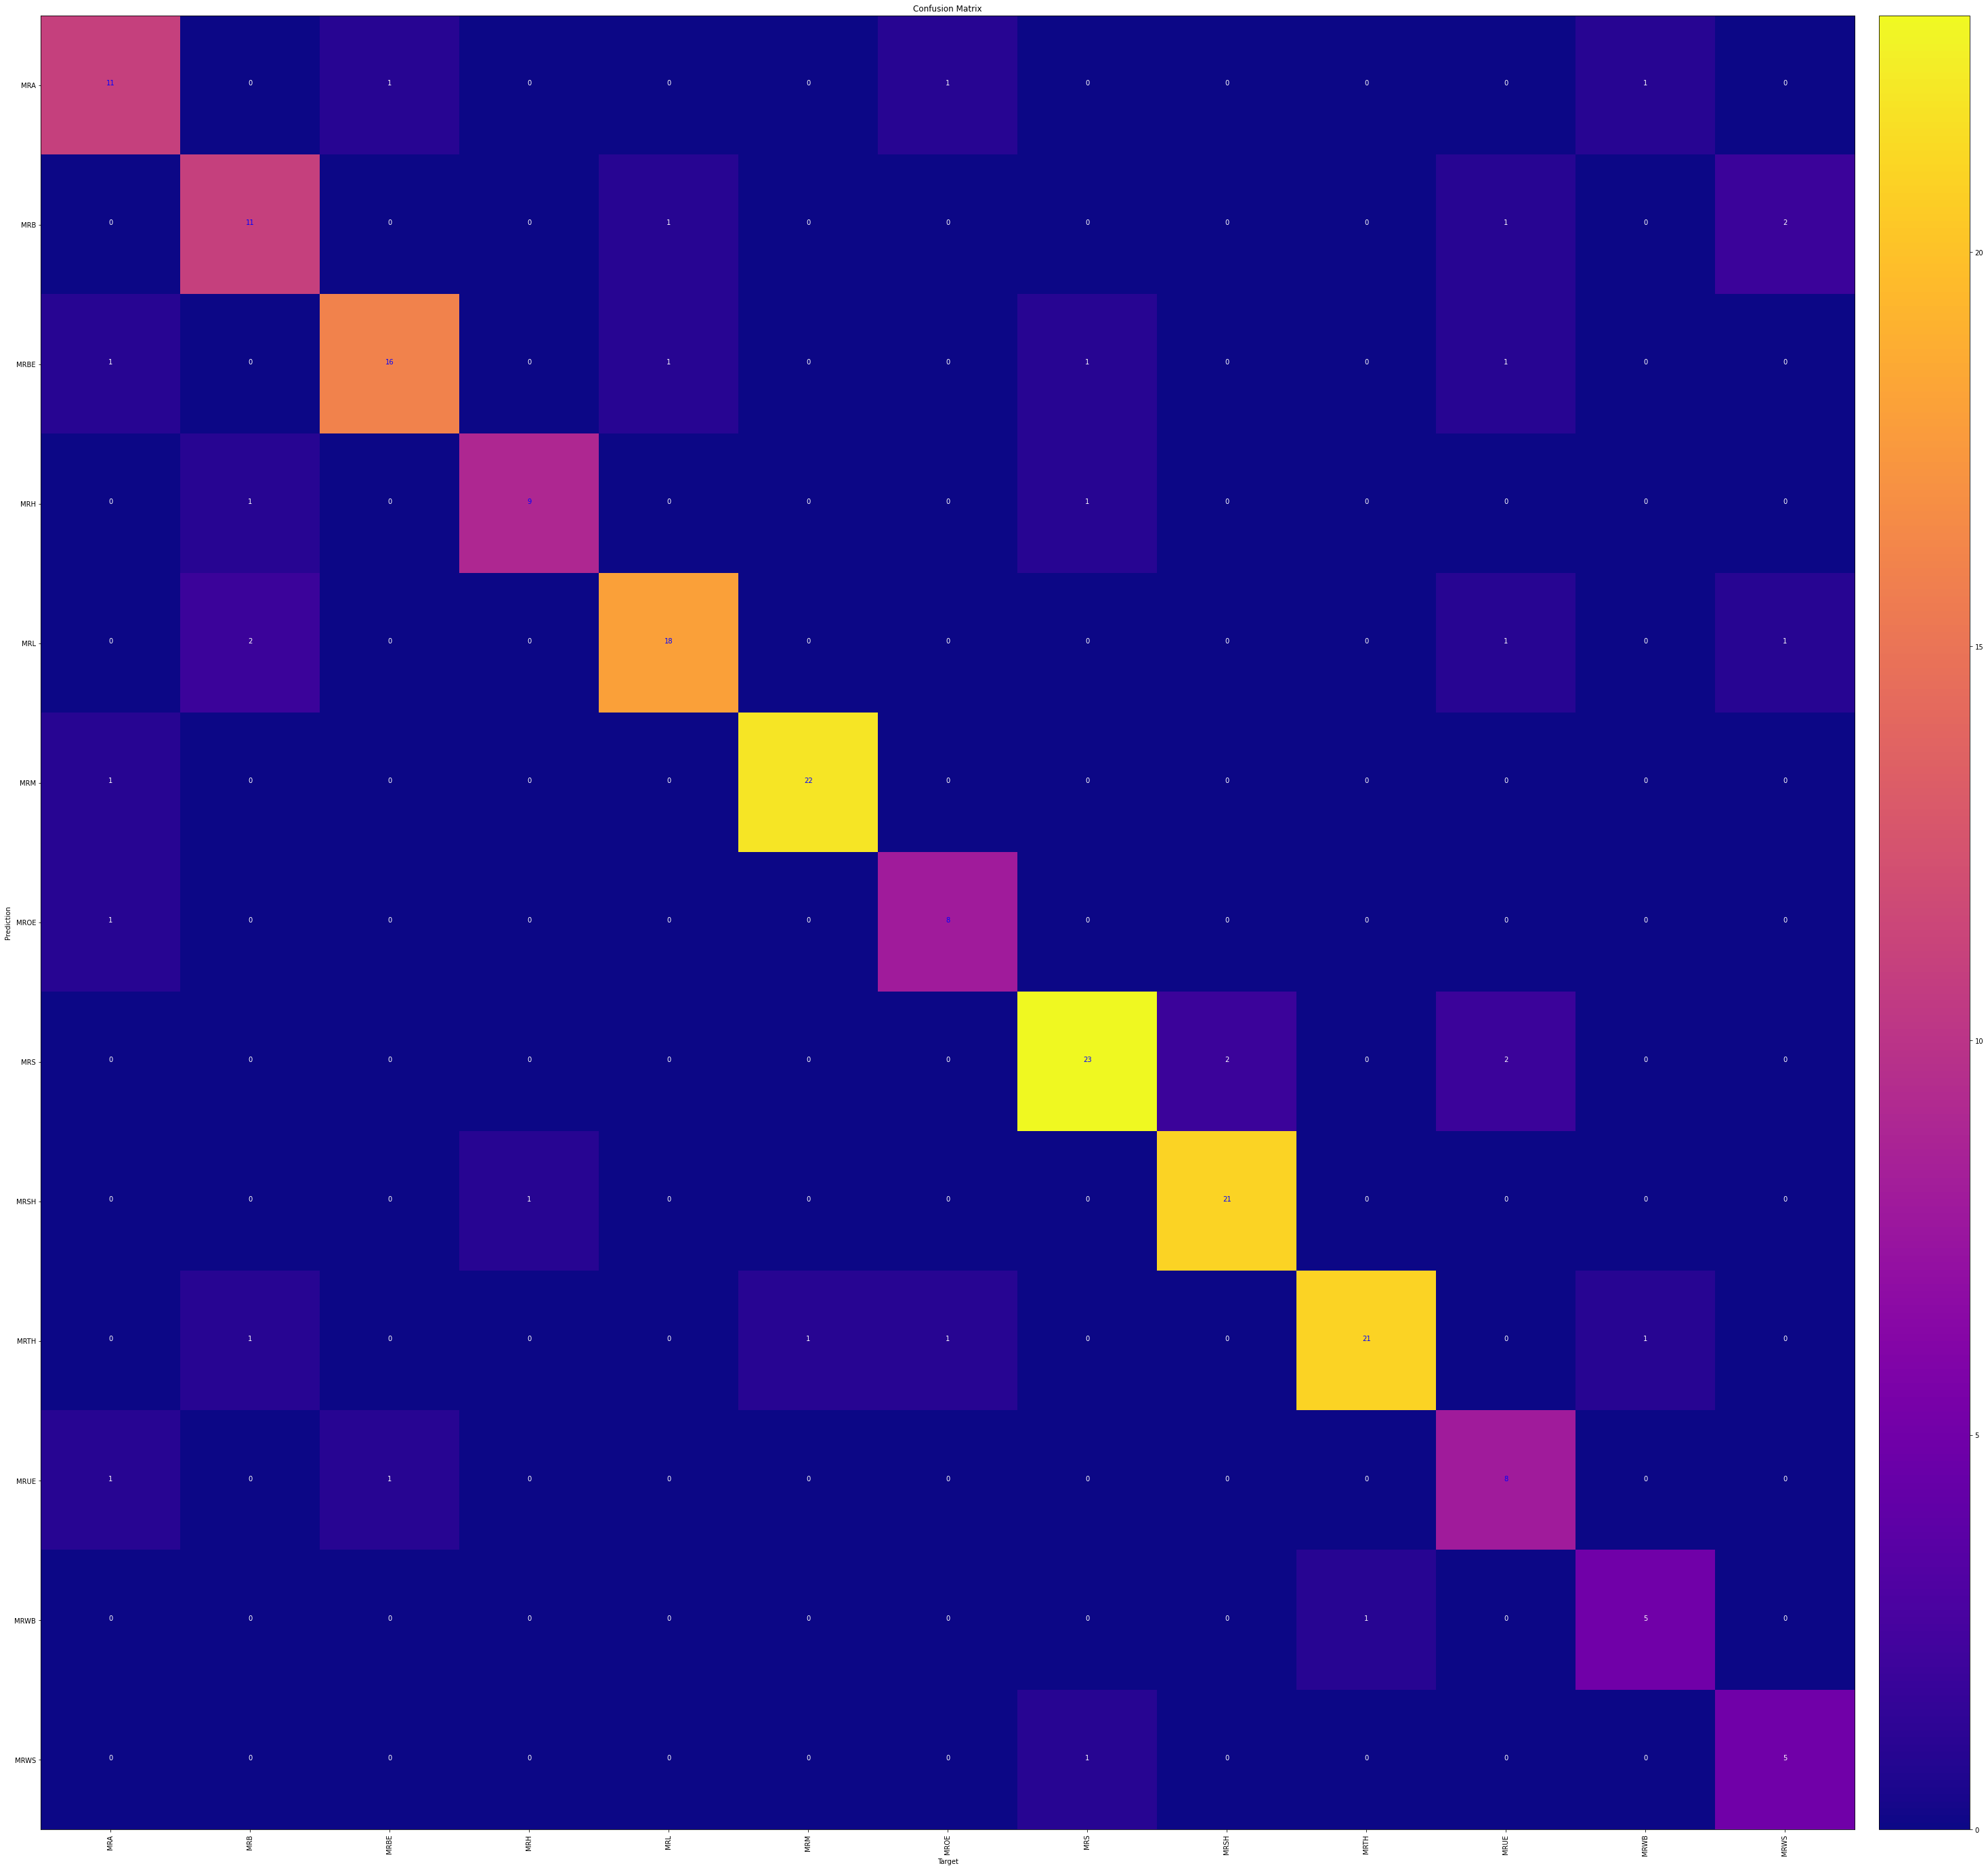

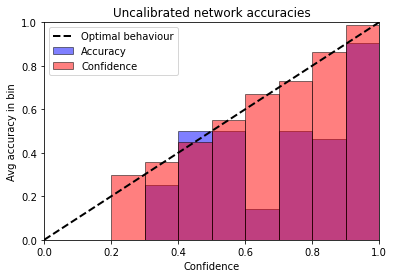

Optimal temperature: 2.028
After temperature - NLL: 0.942, ECE: 0.042


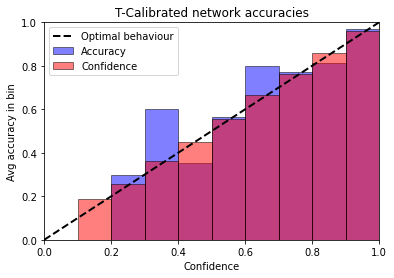

Temperature: T= 2.02777099609375
n_classes:  13
Loss:0.829103223863335,Accuracy:76.19047619047619%


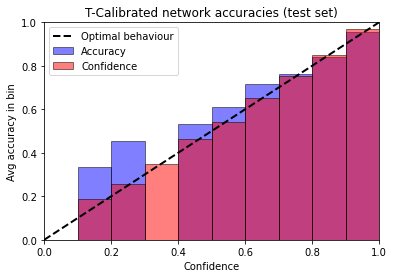

Epoch:0, Batch ID:1, Loss:2.4941916465759277
Epoch:0, Batch ID:2, Loss:2.447382688522339
Epoch:0, Batch ID:3, Loss:2.6000051498413086
Epoch:0, Batch ID:4, Loss:2.332430839538574
Epoch:0, Batch ID:5, Loss:2.3552496433258057
Epoch:0, Batch ID:6, Loss:2.363870143890381
Epoch:0, Batch ID:7, Loss:2.1344516277313232
Epoch:0, Batch ID:8, Loss:2.3178694248199463
Epoch:0, Batch ID:9, Loss:2.127812147140503
Epoch:0, Batch ID:10, Loss:2.328263521194458
Epoch:0, Batch ID:11, Loss:2.2890102863311768
Epoch:0, Batch ID:12, Loss:2.1335983276367188
Epoch:0, Batch ID:13, Loss:2.01828932762146
Epoch:0, Batch ID:14, Loss:2.0890791416168213
Epoch:0, Batch ID:15, Loss:1.8156553506851196
Epoch:0, Batch ID:16, Loss:1.9957348108291626
Epoch:0, Batch ID:17, Loss:2.1303484439849854
Epoch:0, Batch ID:18, Loss:2.0626933574676514
Epoch:0, Batch ID:19, Loss:2.0087101459503174
Epoch:0, Batch ID:20, Loss:2.055950880050659
Epoch:0, Batch ID:21, Loss:1.9304949045181274
Epoch:0, Batch ID:22, Loss:1.610971450805664
Epoch:

Epoch:2, Batch ID:41, Loss:0.8322178721427917
Epoch:2, Batch ID:42, Loss:0.649346113204956
Epoch:2, Batch ID:43, Loss:0.9813380241394043
Epoch:2, Batch ID:44, Loss:0.8941531181335449
Epoch:2, Batch ID:45, Loss:0.7465276718139648
Epoch:2, Batch ID:46, Loss:0.9809775352478027
Epoch:2, Batch ID:47, Loss:0.5492346882820129
Epoch:2, Batch ID:48, Loss:1.1156991720199585
Epoch:2, Batch ID:49, Loss:0.8740888237953186
Epoch:2, Batch ID:50, Loss:0.9988592267036438
Epoch:2, Batch ID:51, Loss:0.8866294026374817
Epoch:2, Batch ID:52, Loss:1.030893325805664
Epoch:2, Batch ID:53, Loss:0.8622438311576843
Epoch:2, Batch ID:54, Loss:0.7204815745353699
Epoch:2, Batch ID:55, Loss:1.0621684789657593
Epoch:2, Batch ID:56, Loss:0.8778765797615051
Epoch:2, Batch ID:57, Loss:1.1274099349975586
Epoch:2, Batch ID:58, Loss:0.645867109298706
Epoch:2, Batch ID:59, Loss:0.7296736240386963
Epoch:2, Batch ID:60, Loss:0.8710475564002991
Epoch:2, Batch ID:61, Loss:1.2401456832885742
Epoch:2, Batch ID:62, Loss:0.74106383

Epoch:5, Batch ID:11, Loss:0.25249502062797546
Epoch:5, Batch ID:12, Loss:0.6645631194114685
Epoch:5, Batch ID:13, Loss:0.5158243775367737
Epoch:5, Batch ID:14, Loss:0.6260810494422913
Epoch:5, Batch ID:15, Loss:0.2038743644952774
Epoch:5, Batch ID:16, Loss:0.6361759901046753
Epoch:5, Batch ID:17, Loss:0.6566320061683655
Epoch:5, Batch ID:18, Loss:0.318473756313324
Epoch:5, Batch ID:19, Loss:0.7073838114738464
Epoch:5, Batch ID:20, Loss:0.35758984088897705
Epoch:5, Batch ID:21, Loss:0.4243665635585785
Epoch:5, Batch ID:22, Loss:0.46772924065589905
Epoch:5, Batch ID:23, Loss:0.7674819827079773
Epoch:5, Batch ID:24, Loss:0.27411654591560364
Epoch:5, Batch ID:25, Loss:0.5210118889808655
Epoch:5, Batch ID:26, Loss:0.7988893389701843
Epoch:5, Batch ID:27, Loss:0.509444534778595
Epoch:5, Batch ID:28, Loss:0.8892478942871094
Epoch:5, Batch ID:29, Loss:0.6799554228782654
Epoch:5, Batch ID:30, Loss:0.35889962315559387
Epoch:5, Batch ID:31, Loss:0.478670209646225
Epoch:5, Batch ID:32, Loss:0.382

Epoch:7, Batch ID:47, Loss:0.46407485008239746
Epoch:7, Batch ID:48, Loss:0.502178966999054
Epoch:7, Batch ID:49, Loss:0.5035222768783569
Epoch:7, Batch ID:50, Loss:0.5150159001350403
Epoch:7, Batch ID:51, Loss:0.3068428337574005
Epoch:7, Batch ID:52, Loss:0.3638092577457428
Epoch:7, Batch ID:53, Loss:0.4169134795665741
Epoch:7, Batch ID:54, Loss:0.2170349508523941
Epoch:7, Batch ID:55, Loss:0.31862130761146545
Epoch:7, Batch ID:56, Loss:0.3524666726589203
Epoch:7, Batch ID:57, Loss:0.25956466794013977
Epoch:7, Batch ID:58, Loss:0.3183310031890869
Epoch:7, Batch ID:59, Loss:0.2363707274198532
Epoch:7, Batch ID:60, Loss:0.25572866201400757
Epoch:7, Batch ID:61, Loss:0.26931968331336975
Epoch:7, Batch ID:62, Loss:0.3981953561306
Epoch:7, Batch ID:63, Loss:0.4266229569911957
Epoch:7, Batch ID:64, Loss:0.3350767195224762
Epoch:7, Batch ID:65, Loss:0.3198119103908539
Epoch:7, Batch ID:66, Loss:0.35116705298423767
Epoch:7, Batch ID:67, Loss:0.39020249247550964
Epoch:7, Batch ID:68, Loss:0.31

Epoch:10, Batch ID:8, Loss:0.22164560854434967
Epoch:10, Batch ID:9, Loss:0.16474474966526031
Epoch:10, Batch ID:10, Loss:0.17074860632419586
Epoch:10, Batch ID:11, Loss:0.19405637681484222
Epoch:10, Batch ID:12, Loss:0.31068721413612366
Epoch:10, Batch ID:13, Loss:0.14259789884090424
Epoch:10, Batch ID:14, Loss:0.16742675006389618
Epoch:10, Batch ID:15, Loss:0.15851269662380219
Epoch:10, Batch ID:16, Loss:0.13011008501052856
Epoch:10, Batch ID:17, Loss:0.589755117893219
Epoch:10, Batch ID:18, Loss:0.30110815167427063
Epoch:10, Batch ID:19, Loss:0.4021937847137451
Epoch:10, Batch ID:20, Loss:0.38660332560539246
Epoch:10, Batch ID:21, Loss:0.5267729759216309
Epoch:10, Batch ID:22, Loss:0.25208333134651184
Epoch:10, Batch ID:23, Loss:0.3735790550708771
Epoch:10, Batch ID:24, Loss:0.2882407009601593
Epoch:10, Batch ID:25, Loss:0.23406098783016205
Epoch:10, Batch ID:26, Loss:0.15385408699512482
Epoch:10, Batch ID:27, Loss:0.17591792345046997
Epoch:10, Batch ID:28, Loss:0.4417535066604614
E

Epoch:12, Batch ID:36, Loss:0.1976771205663681
Epoch:12, Batch ID:37, Loss:0.24351894855499268
Epoch:12, Batch ID:38, Loss:0.21287904679775238
Epoch:12, Batch ID:39, Loss:0.08109601587057114
Epoch:12, Batch ID:40, Loss:0.30705565214157104
Epoch:12, Batch ID:41, Loss:0.043719496577978134
Epoch:12, Batch ID:42, Loss:0.10003980249166489
Epoch:12, Batch ID:43, Loss:0.09093598276376724
Epoch:12, Batch ID:44, Loss:0.4629800021648407
Epoch:12, Batch ID:45, Loss:0.11542483419179916
Epoch:12, Batch ID:46, Loss:0.13965913653373718
Epoch:12, Batch ID:47, Loss:0.2693784534931183
Epoch:12, Batch ID:48, Loss:0.1559961587190628
Epoch:12, Batch ID:49, Loss:0.34542322158813477
Epoch:12, Batch ID:50, Loss:0.22060273587703705
Epoch:12, Batch ID:51, Loss:0.2005990743637085
Epoch:12, Batch ID:52, Loss:0.2394392043352127
Epoch:12, Batch ID:53, Loss:0.10923514515161514
Epoch:12, Batch ID:54, Loss:0.3196583688259125
Epoch:12, Batch ID:55, Loss:0.1567598432302475
Epoch:12, Batch ID:56, Loss:0.627833902835846
E

Epoch:14, Batch ID:63, Loss:0.09297889471054077
Epoch:14, Batch ID:64, Loss:0.22447527945041656
Epoch:14, Batch ID:65, Loss:0.22856992483139038
Epoch:14, Batch ID:66, Loss:0.08410441875457764
Epoch:14, Batch ID:67, Loss:0.14174778759479523
Epoch:14, Batch ID:68, Loss:0.12268368154764175
Epoch:14, Batch ID:69, Loss:0.1461576372385025
Epoch:14, Batch ID:70, Loss:0.2348899245262146
Recent average training loss: 0.2392636147445776
Current average training loss: 0.21979097698251127
Continuing training.
Epoch:15, Batch ID:1, Loss:0.06639081984758377
Epoch:15, Batch ID:2, Loss:0.06664620339870453
Epoch:15, Batch ID:3, Loss:0.0865296944975853
Epoch:15, Batch ID:4, Loss:0.3043392598628998
Epoch:15, Batch ID:5, Loss:0.14975902438163757
Epoch:15, Batch ID:6, Loss:0.1226276382803917
Epoch:15, Batch ID:7, Loss:0.25412577390670776
Epoch:15, Batch ID:8, Loss:0.18106557428836823
Epoch:15, Batch ID:9, Loss:0.10713017731904984
Epoch:15, Batch ID:10, Loss:0.025759896263480186
Epoch:15, Batch ID:11, Loss:

Epoch:17, Batch ID:18, Loss:0.42345333099365234
Epoch:17, Batch ID:19, Loss:0.1185496374964714
Epoch:17, Batch ID:20, Loss:0.2647106349468231
Epoch:17, Batch ID:21, Loss:0.16274213790893555
Epoch:17, Batch ID:22, Loss:0.4066964387893677
Epoch:17, Batch ID:23, Loss:0.1126721203327179
Epoch:17, Batch ID:24, Loss:0.12200703471899033
Epoch:17, Batch ID:25, Loss:0.09276595711708069
Epoch:17, Batch ID:26, Loss:0.14933957159519196
Epoch:17, Batch ID:27, Loss:0.24377049505710602
Epoch:17, Batch ID:28, Loss:0.11338413506746292
Epoch:17, Batch ID:29, Loss:0.182725727558136
Epoch:17, Batch ID:30, Loss:0.13335026800632477
Epoch:17, Batch ID:31, Loss:0.21457724273204803
Epoch:17, Batch ID:32, Loss:0.23401616513729095
Epoch:17, Batch ID:33, Loss:0.06329826265573502
Epoch:17, Batch ID:34, Loss:0.062187206000089645
Epoch:17, Batch ID:35, Loss:0.09197032451629639
Epoch:17, Batch ID:36, Loss:0.10915156453847885
Epoch:17, Batch ID:37, Loss:0.254190593957901
Epoch:17, Batch ID:38, Loss:0.14836500585079193

Epoch:19, Batch ID:45, Loss:0.32689493894577026
Epoch:19, Batch ID:46, Loss:0.029690414667129517
Epoch:19, Batch ID:47, Loss:0.17458559572696686
Epoch:19, Batch ID:48, Loss:0.1870754510164261
Epoch:19, Batch ID:49, Loss:0.125498428940773
Epoch:19, Batch ID:50, Loss:0.18422269821166992
Epoch:19, Batch ID:51, Loss:0.1413760930299759
Epoch:19, Batch ID:52, Loss:0.11105119436979294
Epoch:19, Batch ID:53, Loss:0.01764538325369358
Epoch:19, Batch ID:54, Loss:0.07156199216842651
Epoch:19, Batch ID:55, Loss:0.08662515878677368
Epoch:19, Batch ID:56, Loss:0.12851309776306152
Epoch:19, Batch ID:57, Loss:0.248477041721344
Epoch:19, Batch ID:58, Loss:0.04970886930823326
Epoch:19, Batch ID:59, Loss:0.10174235701560974
Epoch:19, Batch ID:60, Loss:0.031820233911275864
Epoch:19, Batch ID:61, Loss:0.12446745485067368
Epoch:19, Batch ID:62, Loss:0.06063604727387428
Epoch:19, Batch ID:63, Loss:0.04980144277215004
Epoch:19, Batch ID:64, Loss:0.14336542785167694
Epoch:19, Batch ID:65, Loss:0.14121462404727

Epoch:22, Batch ID:1, Loss:0.04169927537441254
Epoch:22, Batch ID:2, Loss:0.20280683040618896
Epoch:22, Batch ID:3, Loss:0.19548334181308746
Epoch:22, Batch ID:4, Loss:0.12739884853363037
Epoch:22, Batch ID:5, Loss:0.08604177832603455
Epoch:22, Batch ID:6, Loss:0.07332131266593933
Epoch:22, Batch ID:7, Loss:0.03074727952480316
Epoch:22, Batch ID:8, Loss:0.08398959040641785
Epoch:22, Batch ID:9, Loss:0.021029094234108925
Epoch:22, Batch ID:10, Loss:0.11147555708885193
Epoch:22, Batch ID:11, Loss:0.030609294772148132
Epoch:22, Batch ID:12, Loss:0.09050554037094116
Epoch:22, Batch ID:13, Loss:0.08843738585710526
Epoch:22, Batch ID:14, Loss:0.11065403372049332
Epoch:22, Batch ID:15, Loss:0.0316077321767807
Epoch:22, Batch ID:16, Loss:0.35215672850608826
Epoch:22, Batch ID:17, Loss:0.05161702632904053
Epoch:22, Batch ID:18, Loss:0.06149922311306
Epoch:22, Batch ID:19, Loss:0.25919970870018005
Epoch:22, Batch ID:20, Loss:0.11832017451524734
Epoch:22, Batch ID:21, Loss:0.08547121286392212
Epo

Epoch:24, Batch ID:28, Loss:0.050233472138643265
Epoch:24, Batch ID:29, Loss:0.0837395191192627
Epoch:24, Batch ID:30, Loss:0.06380023807287216
Epoch:24, Batch ID:31, Loss:0.09433875232934952
Epoch:24, Batch ID:32, Loss:0.14577245712280273
Epoch:24, Batch ID:33, Loss:0.03845111280679703
Epoch:24, Batch ID:34, Loss:0.17267723381519318
Epoch:24, Batch ID:35, Loss:0.19450117647647858
Epoch:24, Batch ID:36, Loss:0.09756047278642654
Epoch:24, Batch ID:37, Loss:0.12116613984107971
Epoch:24, Batch ID:38, Loss:0.03457007184624672
Epoch:24, Batch ID:39, Loss:0.22494423389434814
Epoch:24, Batch ID:40, Loss:0.08162564784288406
Epoch:24, Batch ID:41, Loss:0.05099954083561897
Epoch:24, Batch ID:42, Loss:0.01144214067608118
Epoch:24, Batch ID:43, Loss:0.10509442538022995
Epoch:24, Batch ID:44, Loss:0.020146319642663002
Epoch:24, Batch ID:45, Loss:0.09533334523439407
Epoch:24, Batch ID:46, Loss:0.15427131950855255
Epoch:24, Batch ID:47, Loss:0.01959753781557083
Epoch:24, Batch ID:48, Loss:0.026935240

Epoch:26, Batch ID:55, Loss:0.04848766326904297
Epoch:26, Batch ID:56, Loss:0.024291329085826874
Epoch:26, Batch ID:57, Loss:0.07362097501754761
Epoch:26, Batch ID:58, Loss:0.005417660344392061
Epoch:26, Batch ID:59, Loss:0.03987308591604233
Epoch:26, Batch ID:60, Loss:0.03267814591526985
Epoch:26, Batch ID:61, Loss:0.20766575634479523
Epoch:26, Batch ID:62, Loss:0.05125494673848152
Epoch:26, Batch ID:63, Loss:0.12253863364458084
Epoch:26, Batch ID:64, Loss:0.07943287491798401
Epoch:26, Batch ID:65, Loss:0.056424256414175034
Epoch:26, Batch ID:66, Loss:0.3332071900367737
Epoch:26, Batch ID:67, Loss:0.06919309496879578
Epoch:26, Batch ID:68, Loss:0.09297162294387817
Epoch:26, Batch ID:69, Loss:0.09188436716794968
Epoch:26, Batch ID:70, Loss:0.07112012058496475
Recent average training loss: 0.11208681593662209
Current average training loss: 0.11113610369691126
Continuing training.
Epoch:27, Batch ID:1, Loss:0.06815030425786972
Epoch:27, Batch ID:2, Loss:0.07946915179491043
Epoch:27, Batc

Epoch:29, Batch ID:9, Loss:0.10474342852830887
Epoch:29, Batch ID:10, Loss:0.16497540473937988
Epoch:29, Batch ID:11, Loss:0.060344114899635315
Epoch:29, Batch ID:12, Loss:0.08013427257537842
Epoch:29, Batch ID:13, Loss:0.10103648900985718
Epoch:29, Batch ID:14, Loss:0.16738873720169067
Epoch:29, Batch ID:15, Loss:0.1338375061750412
Epoch:29, Batch ID:16, Loss:0.02285548858344555
Epoch:29, Batch ID:17, Loss:0.04595918953418732
Epoch:29, Batch ID:18, Loss:0.06977792084217072
Epoch:29, Batch ID:19, Loss:0.0498683862388134
Epoch:29, Batch ID:20, Loss:0.18441200256347656
Epoch:29, Batch ID:21, Loss:0.18713010847568512
Epoch:29, Batch ID:22, Loss:0.10646653175354004
Epoch:29, Batch ID:23, Loss:0.03399411961436272
Epoch:29, Batch ID:24, Loss:0.031192535534501076
Epoch:29, Batch ID:25, Loss:0.2909502685070038
Epoch:29, Batch ID:26, Loss:0.026943305507302284
Epoch:29, Batch ID:27, Loss:0.1403626650571823
Epoch:29, Batch ID:28, Loss:0.021074483171105385
Epoch:29, Batch ID:29, Loss:0.14317278563

Epoch:31, Batch ID:35, Loss:0.02184465527534485
Epoch:31, Batch ID:36, Loss:0.06946682929992676
Epoch:31, Batch ID:37, Loss:0.03951228782534599
Epoch:31, Batch ID:38, Loss:0.07737542688846588
Epoch:31, Batch ID:39, Loss:0.12911288440227509
Epoch:31, Batch ID:40, Loss:0.11579382419586182
Epoch:31, Batch ID:41, Loss:0.0383768156170845
Epoch:31, Batch ID:42, Loss:0.027002571150660515
Epoch:31, Batch ID:43, Loss:0.04047492519021034
Epoch:31, Batch ID:44, Loss:0.2545664310455322
Epoch:31, Batch ID:45, Loss:0.27739202976226807
Epoch:31, Batch ID:46, Loss:0.09464671462774277
Epoch:31, Batch ID:47, Loss:0.03089570440351963
Epoch:31, Batch ID:48, Loss:0.044293832033872604
Epoch:31, Batch ID:49, Loss:0.2803703844547272
Epoch:31, Batch ID:50, Loss:0.1796434372663498
Epoch:31, Batch ID:51, Loss:0.39747121930122375
Epoch:31, Batch ID:52, Loss:0.0252377986907959
Epoch:31, Batch ID:53, Loss:0.041679203510284424
Epoch:31, Batch ID:54, Loss:0.16540516912937164
Epoch:31, Batch ID:55, Loss:0.065391302108

Epoch:33, Batch ID:61, Loss:0.030971139669418335
Epoch:33, Batch ID:62, Loss:0.021564044058322906
Epoch:33, Batch ID:63, Loss:0.08821073174476624
Epoch:33, Batch ID:64, Loss:0.0352068692445755
Epoch:33, Batch ID:65, Loss:0.14494460821151733
Epoch:33, Batch ID:66, Loss:0.12148084491491318
Epoch:33, Batch ID:67, Loss:0.10344745963811874
Epoch:33, Batch ID:68, Loss:0.01384183019399643
Epoch:33, Batch ID:69, Loss:0.1887587308883667
Epoch:33, Batch ID:70, Loss:0.20301342010498047
Recent average training loss: 0.09226734048463928
Current average training loss: 0.08902677605059785
Continuing training.
Epoch:34, Batch ID:1, Loss:0.13523301482200623
Epoch:34, Batch ID:2, Loss:0.04067867621779442
Epoch:34, Batch ID:3, Loss:0.15003815293312073
Epoch:34, Batch ID:4, Loss:0.1287502497434616
Epoch:34, Batch ID:5, Loss:0.05941975489258766
Epoch:34, Batch ID:6, Loss:0.03582308068871498
Epoch:34, Batch ID:7, Loss:0.14525540173053741
Epoch:34, Batch ID:8, Loss:0.0905362069606781
Epoch:34, Batch ID:9, Lo

Epoch:36, Batch ID:15, Loss:0.13419117033481598
Epoch:36, Batch ID:16, Loss:0.07558565586805344
Epoch:36, Batch ID:17, Loss:0.15965045988559723
Epoch:36, Batch ID:18, Loss:0.08450794965028763
Epoch:36, Batch ID:19, Loss:0.04026788845658302
Epoch:36, Batch ID:20, Loss:0.0371873676776886
Epoch:36, Batch ID:21, Loss:0.04798797890543938
Epoch:36, Batch ID:22, Loss:0.17057472467422485
Epoch:36, Batch ID:23, Loss:0.08734702318906784
Epoch:36, Batch ID:24, Loss:0.13335882127285004
Epoch:36, Batch ID:25, Loss:0.05168221518397331
Epoch:36, Batch ID:26, Loss:0.26273033022880554
Epoch:36, Batch ID:27, Loss:0.07765667140483856
Epoch:36, Batch ID:28, Loss:0.10655044764280319
Epoch:36, Batch ID:29, Loss:0.06960879266262054
Epoch:36, Batch ID:30, Loss:0.1284337192773819
Epoch:36, Batch ID:31, Loss:0.09044263511896133
Epoch:36, Batch ID:32, Loss:0.020928194746375084
Epoch:36, Batch ID:33, Loss:0.03826875984668732
Epoch:36, Batch ID:34, Loss:0.06979617476463318
Epoch:36, Batch ID:35, Loss:0.00510842120

Epoch:38, Batch ID:41, Loss:0.06787904351949692
Epoch:38, Batch ID:42, Loss:0.021645933389663696
Epoch:38, Batch ID:43, Loss:0.020929506048560143
Epoch:38, Batch ID:44, Loss:0.06674729287624359
Epoch:38, Batch ID:45, Loss:0.09421031922101974
Epoch:38, Batch ID:46, Loss:0.03952821344137192
Epoch:38, Batch ID:47, Loss:0.15952767431735992
Epoch:38, Batch ID:48, Loss:0.027543842792510986
Epoch:38, Batch ID:49, Loss:0.036243245005607605
Epoch:38, Batch ID:50, Loss:0.07778795063495636
Epoch:38, Batch ID:51, Loss:0.02769329398870468
Epoch:38, Batch ID:52, Loss:0.04355770722031593
Epoch:38, Batch ID:53, Loss:0.11600235849618912
Epoch:38, Batch ID:54, Loss:0.1147380992770195
Epoch:38, Batch ID:55, Loss:0.011369765736162663
Epoch:38, Batch ID:56, Loss:0.10455206781625748
Epoch:38, Batch ID:57, Loss:0.009201846085488796
Epoch:38, Batch ID:58, Loss:0.04833446443080902
Epoch:38, Batch ID:59, Loss:0.07334191352128983
Epoch:38, Batch ID:60, Loss:0.03992730379104614
Epoch:38, Batch ID:61, Loss:0.22402

Epoch:40, Batch ID:67, Loss:0.02941844053566456
Epoch:40, Batch ID:68, Loss:0.07055842131376266
Epoch:40, Batch ID:69, Loss:0.06377573311328888
Epoch:40, Batch ID:70, Loss:0.13775597512722015
Recent average training loss: 0.0767255511436559
Current average training loss: 0.07648046023120554
Continuing training.
Epoch:41, Batch ID:1, Loss:0.03523726388812065
Epoch:41, Batch ID:2, Loss:0.031313925981521606
Epoch:41, Batch ID:3, Loss:0.03851045295596123
Epoch:41, Batch ID:4, Loss:0.012266982346773148
Epoch:41, Batch ID:5, Loss:0.01550921518355608
Epoch:41, Batch ID:6, Loss:0.012363112531602383
Epoch:41, Batch ID:7, Loss:0.10736989229917526
Epoch:41, Batch ID:8, Loss:0.06265883892774582
Epoch:41, Batch ID:9, Loss:0.02964995987713337
Epoch:41, Batch ID:10, Loss:0.04748419299721718
Epoch:41, Batch ID:11, Loss:0.013353579677641392
Epoch:41, Batch ID:12, Loss:0.005556141491979361
Epoch:41, Batch ID:13, Loss:0.015259976498782635
Epoch:41, Batch ID:14, Loss:0.07556759566068649
Epoch:41, Batch ID

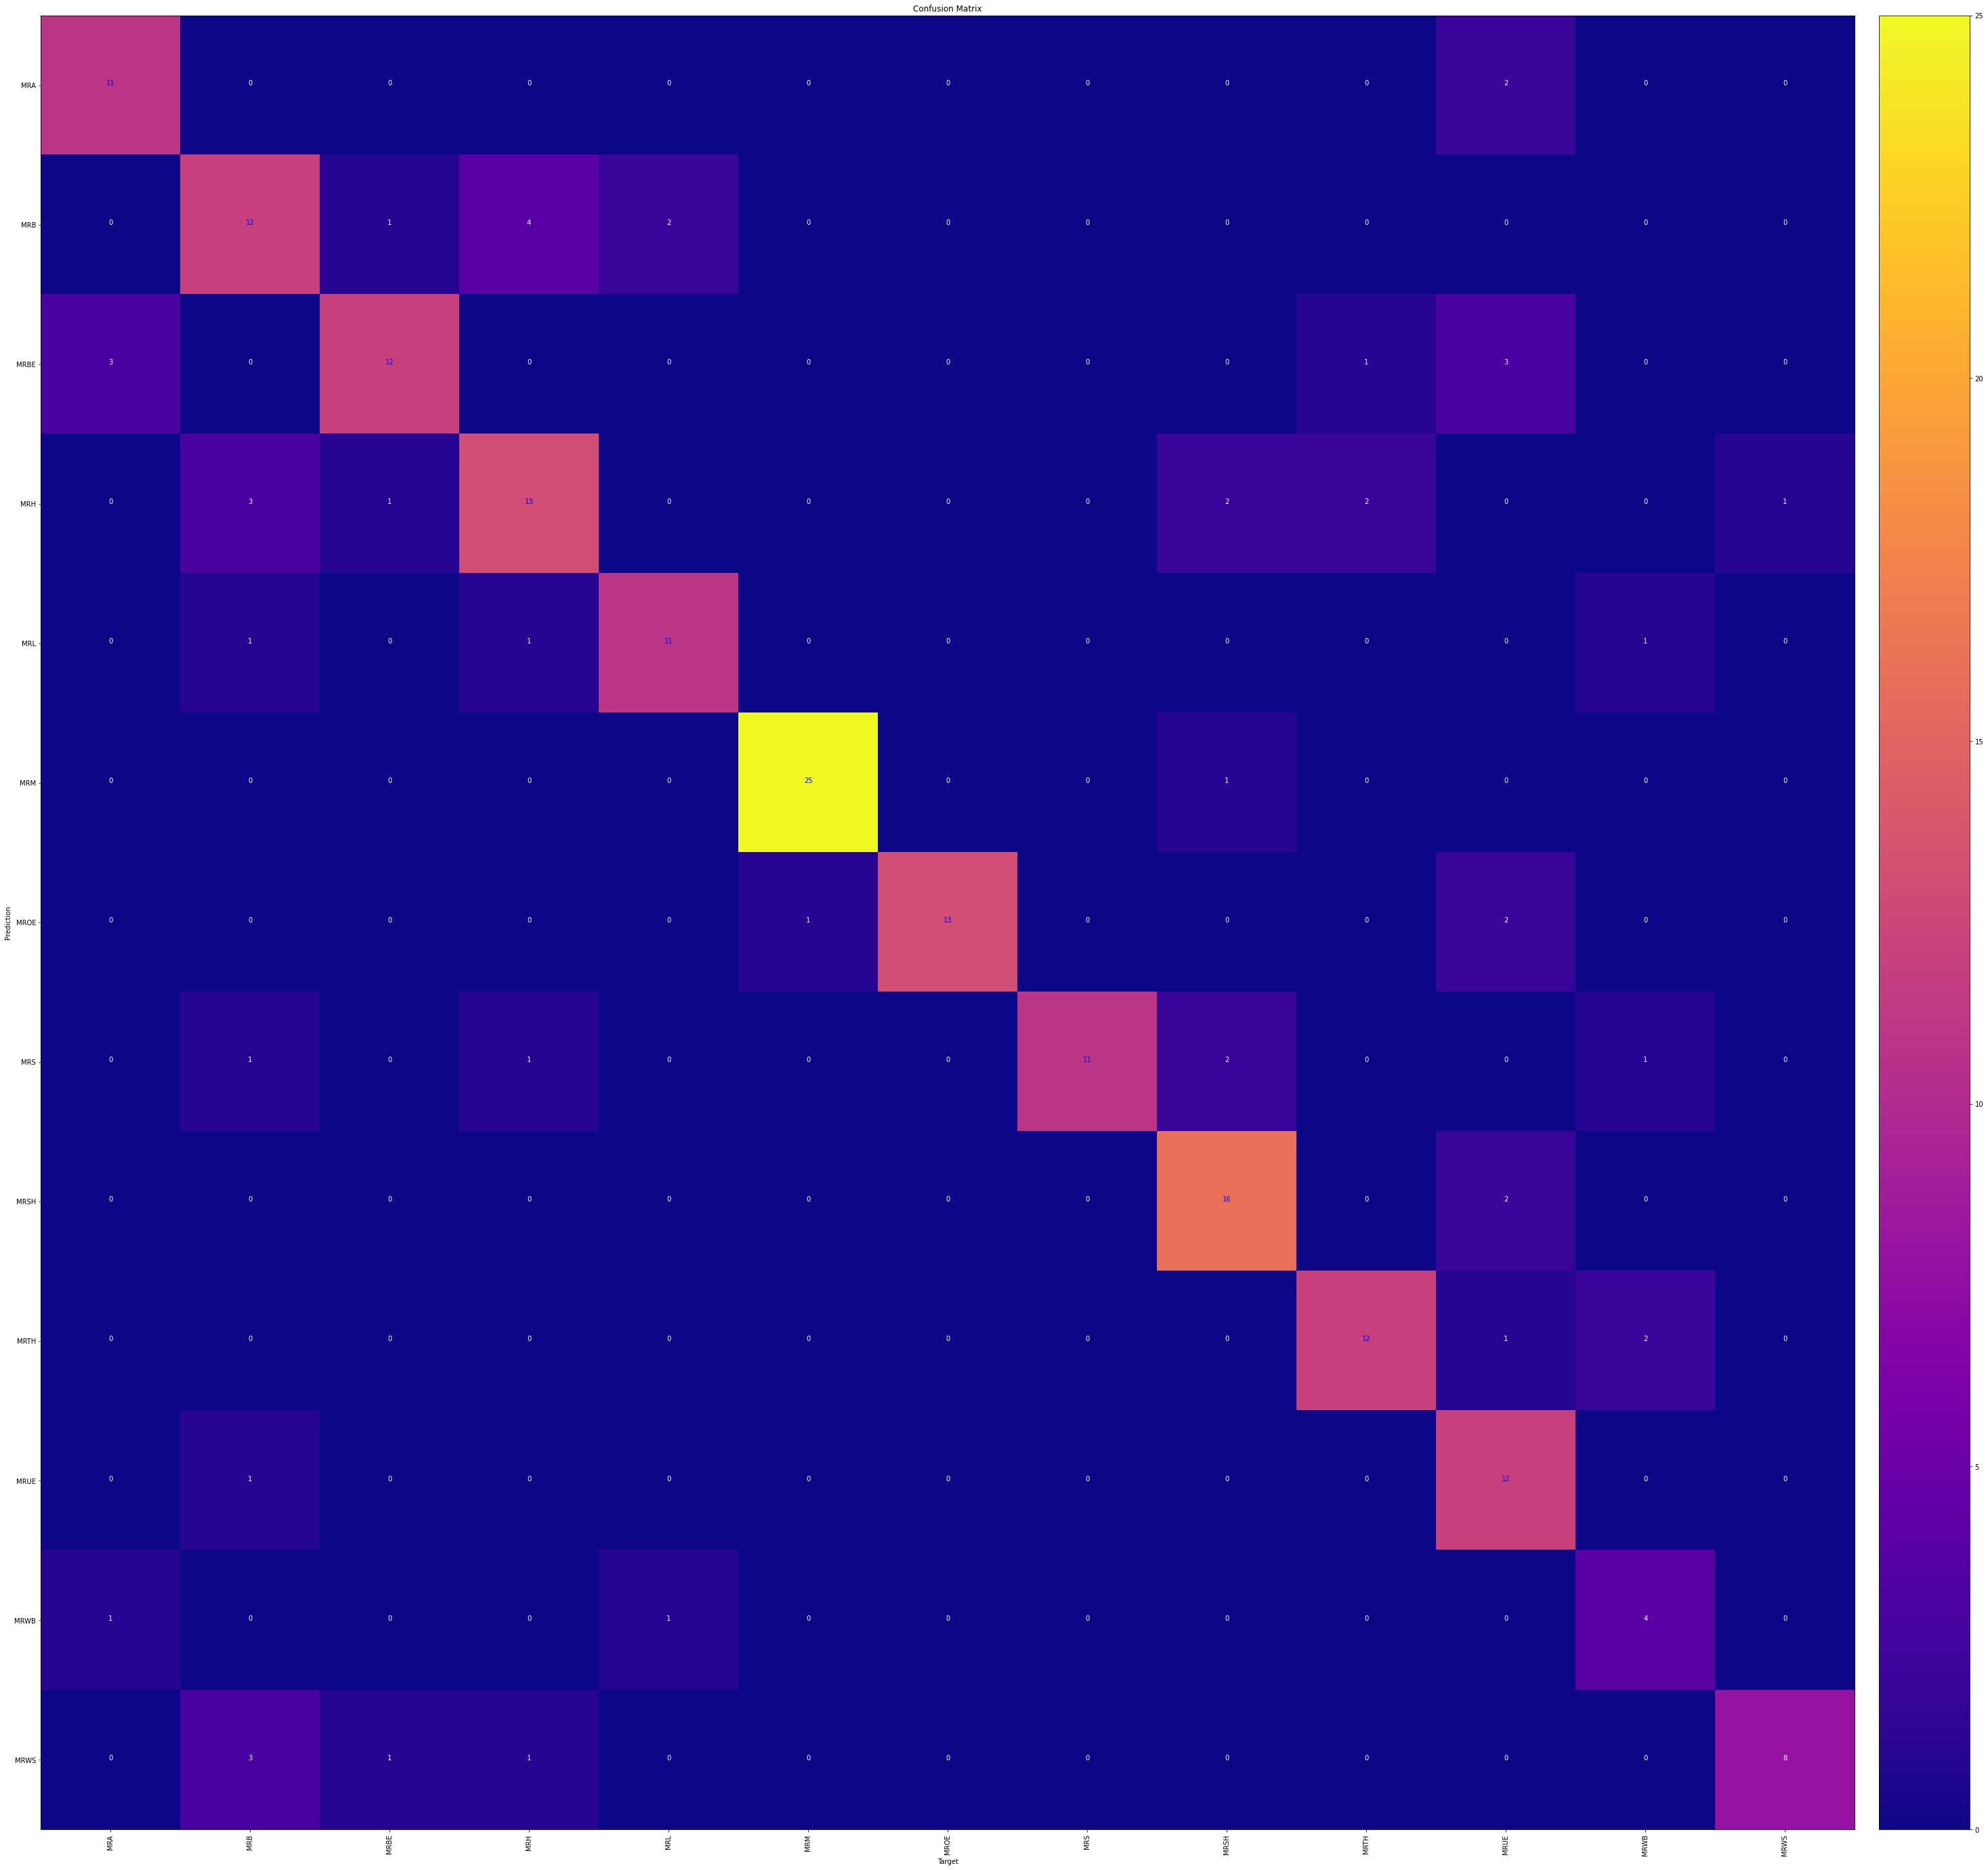

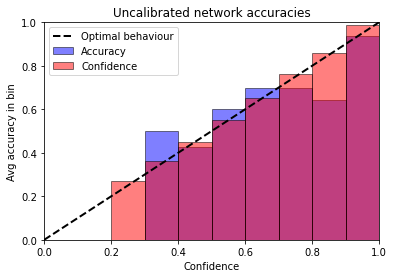

Optimal temperature: 1.517
After temperature - NLL: 0.695, ECE: 0.047


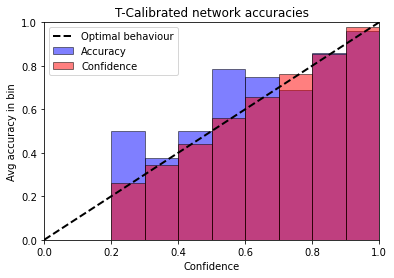

Temperature: T= 1.5172748565673828
n_classes:  13
Loss:0.6828486126985549,Accuracy:80.95238095238095%


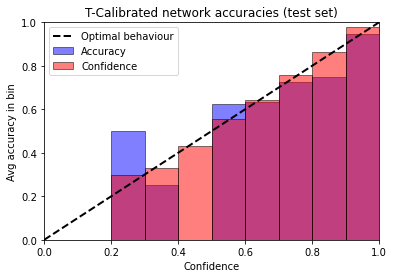

[79.52380952380952, 79.52380952380952, 84.76190476190476, 76.19047619047619, 80.95238095238095] 80.19047619047619 (74.7610747501699, 85.61987763078248)


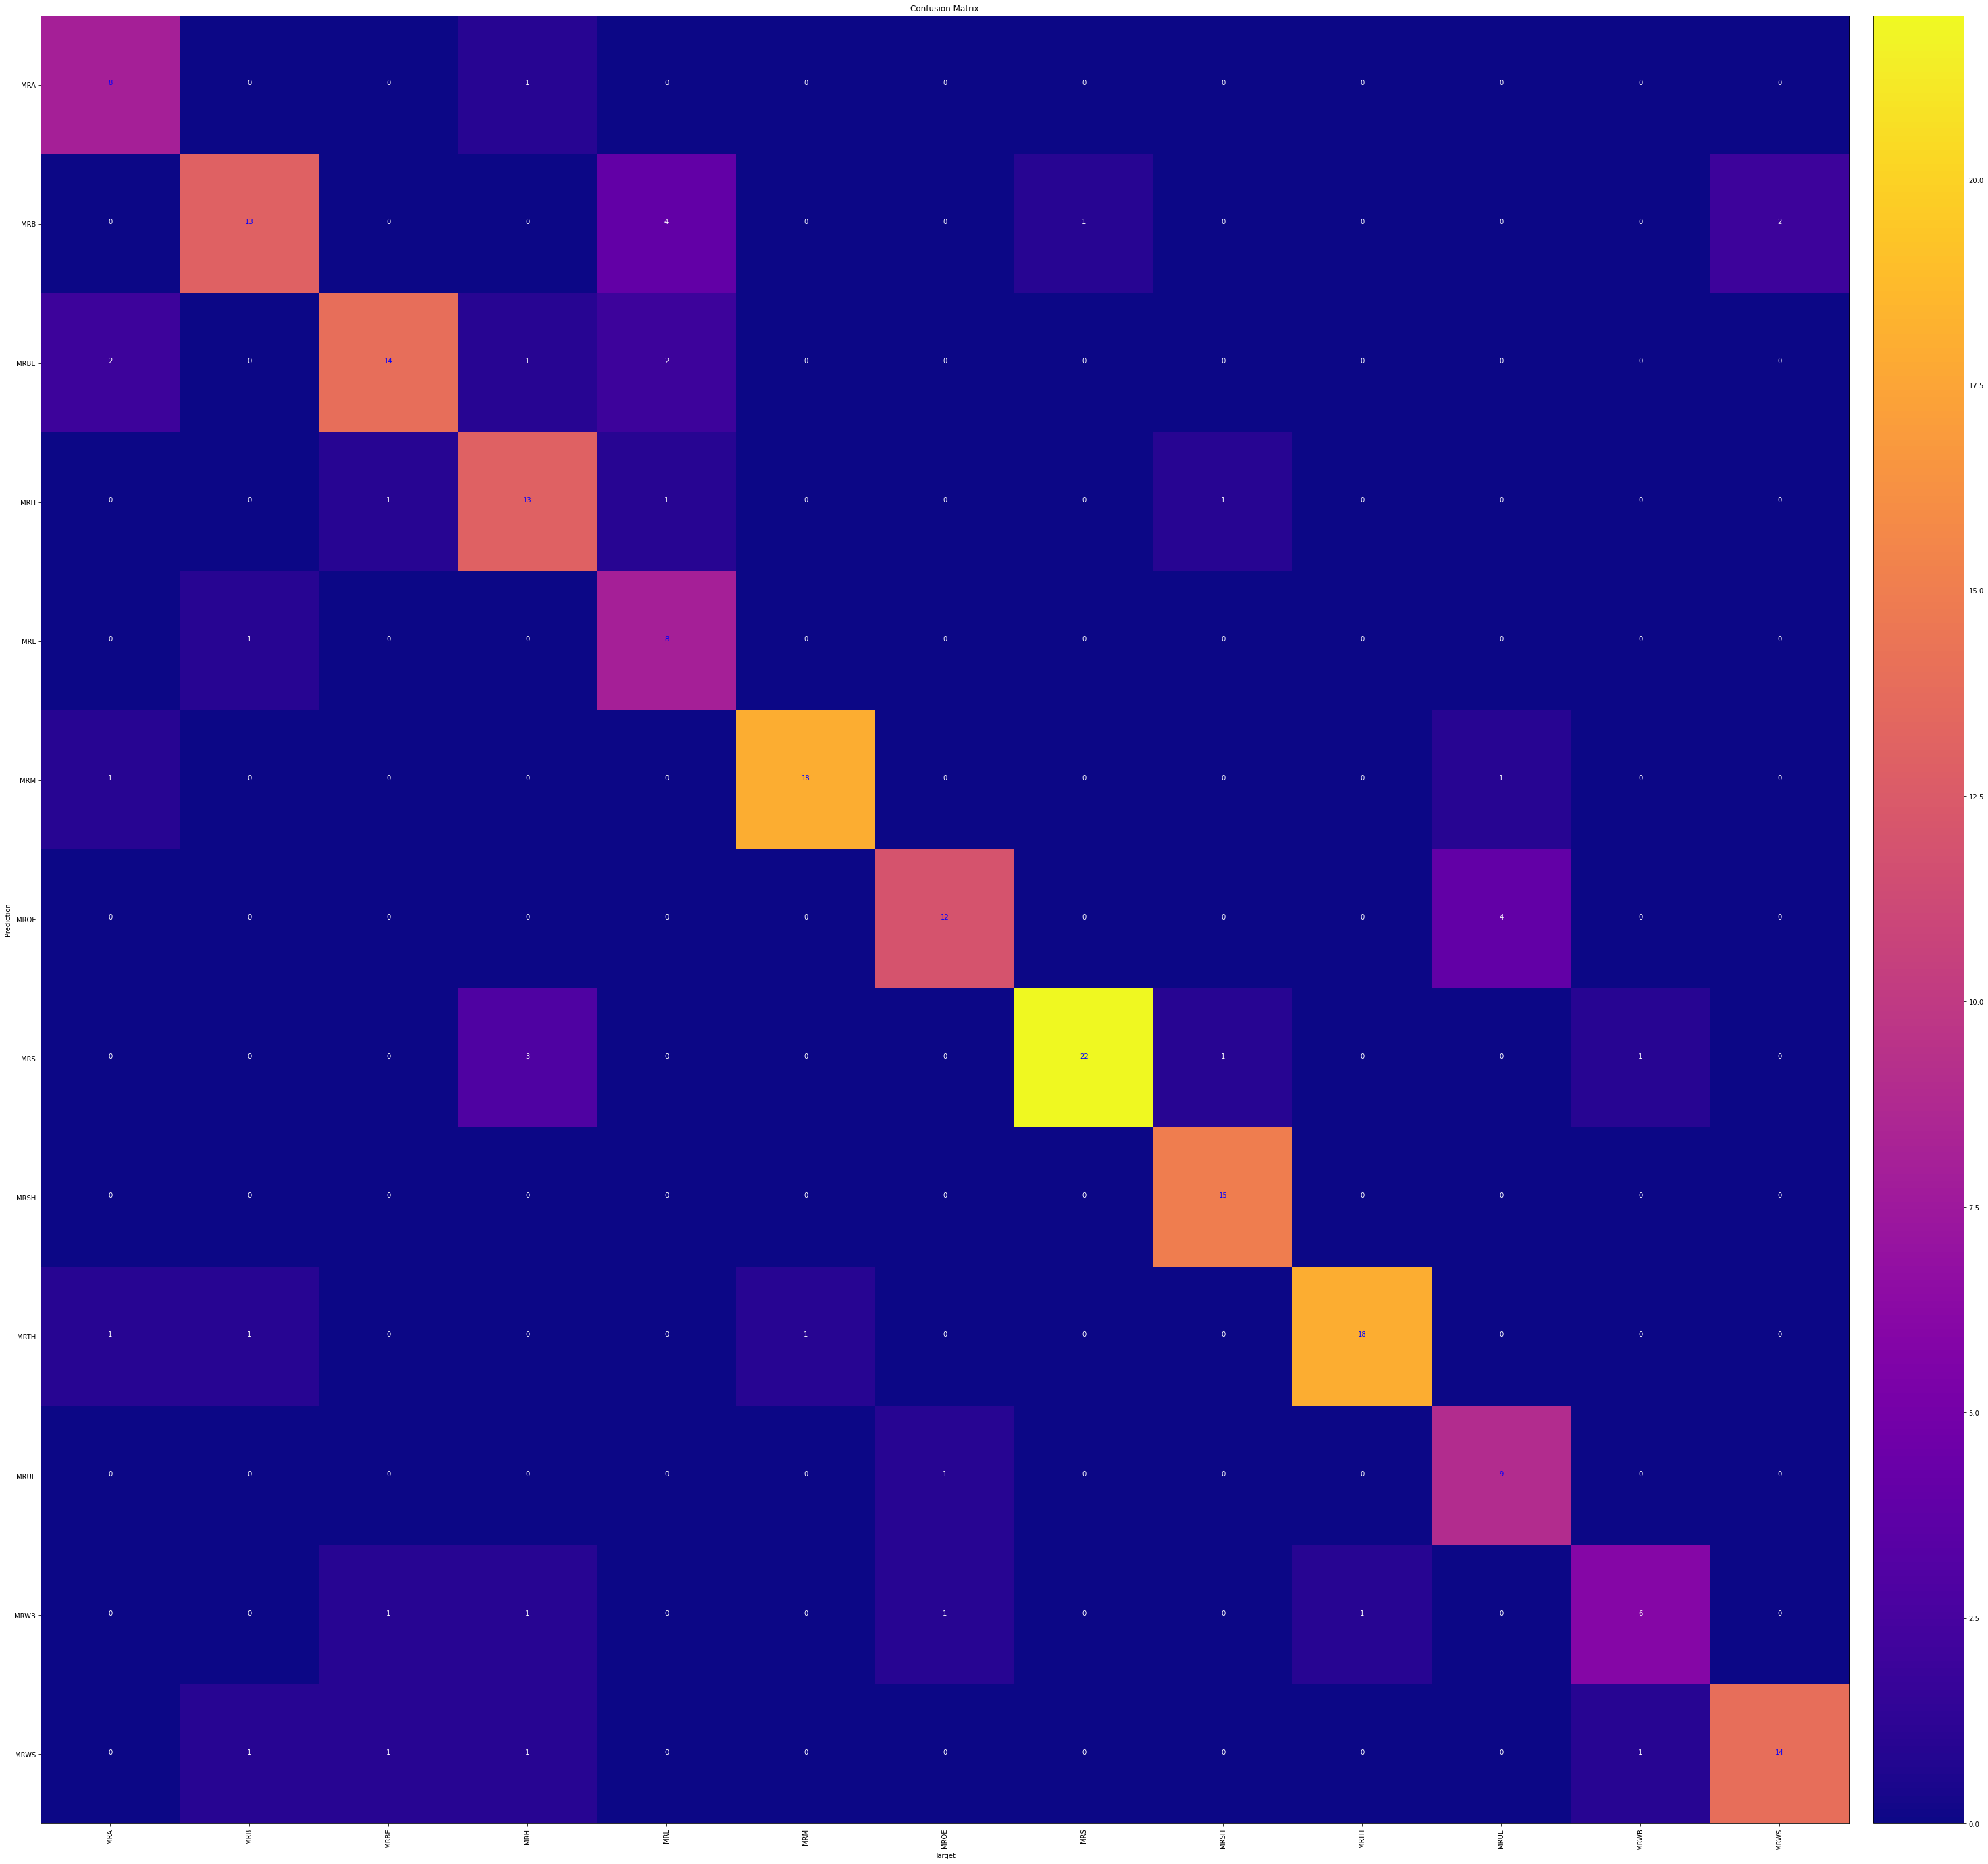

In [8]:
def ffcv(dataset, nc, smap, saveloc, minacc=0.0):
    # does five-fold cross-validation for the network training
    accuracies = []
    
    for k in range(5):
        
        temp_inds = get_indices(lower=int(0+k*(vs+ts)), upper=int(vs+k*(vs+ts)), length=dl)
        test_inds = get_indices(lower=int(vs+k*(vs+ts)), upper=int((k+1)*(vs+ts)), length=dl)
        train_inds = [i for i in range(dl) if not (i in temp_inds or i in test_inds)]

        trainset = torch.utils.data.Subset(dataset, train_inds)
        tempset = torch.utils.data.Subset(dataset, temp_inds)
        testset = torch.utils.data.Subset(dataset, test_inds)

        trdist = [targets for _, targets, _ in trainset]
        tmdist = [targets for _, targets, _ in tempset]
        tedist = [targets for _, targets, _ in testset]

        train_loader = torch.utils.data.DataLoader(trainset, batch_size=24, num_workers=4, shuffle=True, drop_last=True)

        tempset.training = False
        temp_loader = torch.utils.data.DataLoader(tempset, batch_size=24, num_workers=4, shuffle=True)

        testset.training = False
        test_loader = torch.utils.data.DataLoader(testset, batch_size=24, shuffle=True)
        
        # import a resnet, freeze it, swap in final layer
        RN_model = torch.nn.DataParallel(torchvision.models.resnet152(pretrained=True)).to(device)
        for param in RN_model.parameters():
            param.requires_grad = False
        for param in RN_model.module.layer4.parameters():
            param.requires_grad = True
        for param in RN_model.module.avgpool.parameters():
            param.requires_grad = True
        num_ftrs = RN_model.module.fc.in_features
        RN_model.module.fc = nn.Linear(num_ftrs, nc)

        # training hyperparameters
        lr = 1e-4 # learning rate
        lr_decay = lambda current_epoch: 0.99**current_epoch # learning rate decay function
        w_decay = 1e-4 # weight decay

        # conditions and schedules
        esa = True # early stopping allowed
        vis = 5   # how many epochs must plateau before break
        imp = 0.99 # suggested loss improvement to continue training
        def training_converged(lel, vis, imp):
            return sum(x for x in lel[-2*int(vis):-1*int(vis)])/vis * imp < sum(x for x in lel[-1*int(vis):])/vis

        wda = 0.5  # at which fraction of average early loss should weight_decay becomes active

        # train
        lel = []
        for epoch in range(1000):
            # weight decay active?
            if epoch != 0:
                if el <= wda * lel[0]:
                    weight_decay = w_decay
                else:
                    weight_decay = 0
            else:
                weight_decay = 0

            # train model
            el = train_model(model = RN_model,
                        current_epoch = epoch,
                        train_loader = train_loader,
                        lr = lr,
                        lr_decay = lr_decay,
                        weight_decay = weight_decay)

            # track average loss during epoch                                                    
            lel.append(el)

            # end training due to convergence?
            if epoch > vis:
                print("Recent average training loss: "+str(sum(x for x in lel[-1*int(vis)-1:-1])/vis))
                print("Current average training loss: "+str(sum(x for x in lel[-1*int(vis):])/vis))
            if epoch >=2*vis:
                if training_converged(lel, vis = vis, imp = imp):
                    if esa:
                        print("Network parameters appear to have converged, aborting training.")
                        # training has not improved loss to factor imp compared to avg of the last vis epochs, end training
                        break
                    else:
                        print("Continuing training. Warning: Convergence satisfies user-specified conditions already.")
                else:
                    print("Continuing training.")
                    
        #calibrate temperature
        RN_Tmodel = calibrate_model(model = RN_model, temp_loader = temp_loader)
        
        #test model
        test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
        print("Temperature: T=", RN_Tmodel.temperature.item())
        predictions, probabilities, targets, accuracy = test_model(model = RN_Tmodel,
                                                         test_loader = test_loader,
                                                         nc = nc,
                                                         mapfile = smap,
                                                         print_mistakes = False,
                                                         plot_mistakes = False)

        if all(accuracy > old_acc for old_acc in accuracies) and accuracy > minacc:
            print("New best model! Accuracy: ", accuracy)
            torch.save(RN_Tmodel, saveloc)
        accuracies.append(accuracy)
    return accuracies

accs = ffcv(dataset=dataset, 
            nc=13, 
            smap="./MR_only.json", 
            saveloc="./ResNet_MR_only.pth",
            minacc=80.0)
print(accs, np.mean(accs), (np.mean(accs)-1.96*scipy.stats.sem(accs),np.mean(accs)+1.96*scipy.stats.sem(accs)))